# 0. Marking.

***IMPORTANT***: Save a copy of this notebook into your Drive before you start.
- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).
- **We assume you will use the provided seeds. If you do not, please save all seeds that you use in the provided enum.**

Please submit a zip file containing (a) a text file with a publicly visible link to your notebook in Google Colab; (b) a downloaded copy (ipynb) of your notebook. You may treat this as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

# 1) Introduction

Welcome to the third lab session in our FL course.
We now know how to “federate” a centralised ML model and have learned some tools to deal with data heterogeneity.

During this session, we will try to put our hands on system heterogeneity in simulating FL. However, assuming you want to produce an FL system that will be deployed in the real world, taking into account data heterogeneity is often not enough. 

Client hardware may be correlated with the underlying data---e.g. a smartphone's camera impacts image characteristics---or with which data is used. For example, clients with less reliable internet connections from specific regions of the world are more likely to drop out, making their region underrepresented in training. Thus, the limits placed on computation time or the assumptions made in applying a synchronous or asynchronous algorithm affect model performance, fairness, or scalability. 

Developers may want to simulate their FL pipelines in a controlled environment in which natural system characteristics are modelled in order to be able to understand such trade-offs.

What should we take into account, then?
Clients' availability, training time, communication bandwidth, and other factors sometimes impact natural FL systems unexpectedly.
Developers usually set up constraints for selecting clients to account for most of these factors, but in the worst case, these may result in not completing even a single round. 
On the other hand, relaxing some constraints produces long round completion times, and eventually, the FL model cannot reach convergence in a reasonable interval.

Before we begin modelling such concerns, we shall investigate data regarding real-world system characteristics from the two following papers:
1. [Papaya: Practical, Private, and Scalable Federated Learning](https://arxiv.org/abs/2111.04877)
2. [Towards Federated Learning at Scale: System Design](https://arxiv.org/abs/1902.01046)

# 2) Behavioural patterns of real-world FL systems

The following plot was extracted from the Papaya paper (1) mentioned above.
The takeaway is that in natural settings, devices are very heterogeneous, and the same model could take different amounts of time to train on various clients. Since the distribution is neither Gaussian nor uniform, accounting for such behaviour is non-trivial. As a result, developers often have to make imperfect choices when selecting between synchronous and asynchronous FL algorithms and their parameters. 


![client_execution_time](https://drive.google.com/uc?id=1-YwC63F2gFJrsM1KxoqJMgu-GAAgvjQx)


In the case of synchronous training, they may select clients based on hardware, set time limits for round completion, and incorporate partially trained client models that have not reached the necessary step/epoch count. 

Besides tackling the previously discussed data heterogeneity, FedProx was designed to better incorporate partially trained models from stragglers by limiting their impact upon the aggregation. The dual purpose of FedProx illustrates the interdependence of systems and data heterogeneity.

In the case of asynchronous training, all updates **could** be considered; however, model staleness and a significant bias towards faster clients become major issues. For example, clients who return updates based on an older model may have had more data to train on or simply slower internet.  If they have more data, they might provide more **statistical utility** than fast clients and thus improve final accuracy. Alternatively, they might have valuable data from underrepresented or remote regions if they have slower internet. If you are curious and want more insights about asynchronous training in FL, we point to the most prominent example: [FedBuf](https://arxiv.org/abs/2106.06639).

In an extreme case of hardware heterogeneity, clients with high-end hardware may guide the model to the detriment of those with better data or those belonging to relevant subgroups. Due to such difficulties, asynchronous FL has been historically more difficult to implement and less preponderantly used than one may expect, given its potential benefits. 

##### ! **Question 1 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. In the context of a complete synchronous FL training period composed of multiple rounds, when do you think it would be appropriate to oversample fast/slow clients? Should it be more appropriate for the early or late training phases? Think of which characteristics are essential for convergence in the early versus late rounds. 
2. Can you think of a heuristic for modifying the time threshold across rounds that considers your previous answer?

1) When appropriate during training to oversample fast/slow clients 
- Start by oversampling fast clients as what matters most is speed of update (as the model starts a very long way away from the optimum so the direction for the updates is likely to be similar across all clients)
- End by oversampling slower clients as the direction of model updates now matters a lot more. At this stage we are care more about "fine-tuning" and gradient accuracy so we want the most statistical utility

2) Heuristic for modifying time threshold

- Look at the rate at which loss is decreasing, intially this should be high (so continue oversampling fast clients) but as it slows down start introducing more slow clients)
- Could additionally select a few slow clients every few rounds during initial training and compare the direction of the model updates they find with the ones the fast clients find. If they are similar then keep using fast clients, but if they diverge then there is benefit to start using more slow ones (NOTE: no need to wait for these slow updates to continue with training, they can be thrown away after comparison to avoid increasing round length)

##### ! **Question 2 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What parallels can be drawn between asynchronous SGD and asynchronous FL? Are there any methods which may help with both?
2. How do you think a system using a buffer to accumulate gradient updates received asynchronously, such as [FedBuf](https://arxiv.org/pdf/2106.06639.pdf), behaves?

1) Parallels with async SGD and async FL
- Both meet challenge of stale gradients where faster updates may have reached model already
- Both need way to incorporate gradients based on the previous model so not throwing away wasted work

2) Predictions for how using buffer to accumulate gradients behaves
- Buffering faster than sync as dont need to wait for stragglers to update model]
- Buffering also possibly faster than async as model aggregation takes non-zero time so batching the work up could save time here if (especially as model updates are likely delivered in bursts)
- However, buffering will undersample slow clients as they may still be working on previous rounds when the buffer fills up and the server selects new clients BUT the slow client updates will be less stale than fully async (as fewer updates made between training start and update being delivered)]

## 2.1 Cyclical patterns

The plot below is taken from paper (2) mentioned above and encapsulates the reliability of client training. In the context of mobile devices, we can observe a cyclic daily trend for each category plotted while the delta between the categories is partly conserved. Thus, according to the number of clients we expect to finish training, we can adapt our training parameters, such as a completion-time threshold. 

If the federation included a more diverse set of devices operating in different domains or across a wider geographic area, the number of completing, aborted or dropped-out devices may not show the same synchronised patterns. 

![aborted_completed_dropped](https://drive.google.com/uc?id=1-NsWiw4-GM01OBYo2Qi_zSuOsVfjHFHc)


These plots from paper (2) show a more clear cyclic trend in the participation rate, completion rate and network utilisation of clients depending on the day-night cycle. It is fair to say that these measurements were taken from devices in the same time zone and reflect common smartphone usage patterns related to humans' sleep and activity cycles.

![connected_round_completion](https://drive.google.com/uc?id=1-NsGPsSfrjM5EUVk-9-OGRgL-IZbUEoh)


![network_traffic](https://drive.google.com/uc?id=1-ZQzDbmvXzNgcLw3xj8k3jhfN7ivlhdv)


#### ! **Question 3 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What would happen to device availability if we scaled the federated network globally? 
2. How would the time of day interact with the client data and system characteristics in this new global federated network?

1) Affect on availability of scaling to be global
- Evens out availability because the peaks and troughs will be at different times in different countries
- However different time zones may have different numbers of people so this evening out will not be perfect
- Additionally people may follow different usage patterns in different cultures (not sure unless do an experiment to test)

2) Client data and system characteristics in global system at different times
- At different times, clients will mostly be in certain part of the world
- This will affect data on available clients (e.g. if doing next word prediction, users will by typing different langauges at different times / in different styles of same language)
- Also affect system characteristics - people in less economically developed countries may have devices with less powerful compute abilities, increasing training time, additionally infrastructure differnces would affect communication bandwidth

#### ! **Question 4 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

Beyond shifts in the devices used at a specific time, on a long-enough timescale, FL also suffers from **non-cyclical** changes in the underlying hardware and data distributions which can lead to them getting desynced. For example, users may transfer their old data to a new device with more powerful sensors and thus create two “tasks'' instead of one. Furthermore, they can delete portions of the older data over time and shift the balance between the two tasks. 

1. For FL systems with more powerful and long-lasting clients, one potential method for handling such data and hardware shift is maintaining a persistent local model trained concurrently with the federated model---e.g. via [mutual knowledge distillation](https://arxiv.org/abs/1706.00384). This model may regularise the federated one and encodes valuable information about the data distribution accumulated at different points in time.  Considering that such a model never leaves the client and thus does not have significant privacy concerns, what techniques would you apply to make it as **informative to the federated model as possible?** 

2. Assuming that the federated network has changed too much for an old federated model to perform well, how would you use the old model to bootstrap a new one?

For both components of the question, you may draw inspiration from techniques used in [continual learning](https://arxiv.org/pdf/1909.08383.pdf), [mutual learning](https://arxiv.org/abs/1706.00384) or any other relevant field of ML.

1) How to make local model as informative to federated model as possible
- Oversample data that federated model struggles with - to fine tune the local model to be as useful as possible
- Constrain how much the model changes over time using knowledge distillation (similar to last question of Lab2) as is done with continual learning, to prevent the model forgetting how to classify data that has been deleted
- Could keep old versions of the model on the client that are no longer updated but used to prevent knowledge from eventually leaving the local model (e.g. by soemtimes acting as the teacher during knowledge distillation for the newer local model)

2) How to use old model to bootstrap a new one
- As well as using the class labels during training, clients could use the predictions from the old model as additional soft targets to get the benefits of knowledge distillation, speeding up the initial training
- It is ok if the new model performs less well than the previous one with old data (as the quesiton premise is that the network has shifted such that this is no longer a useful property)


# 3. Modelling system heterogeneity

## Imports (RUN)

The following cell will download the relevant python packages using `pip`.

In [1]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified; it is working anyway.
# ! pip install --quiet --upgrade "pip"
# ! pip install --quiet 'flwr[simulation]' torch torchvision matplotlib gdown tqdm seaborn torchsummary
# # The following is just needed to show the folder tree
# ! apt-get install -qq tree

In [2]:
## Imports
import csv
import numbers
import os
import random
import pickle
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *

import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics, Config, GetPropertiesIns, GetPropertiesRes, MetricsAggregationFn
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, Server
from flwr.server.client_manager import SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr.server.strategy import FedAvgM as FedAvg
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    server,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        server=server,
        config=config,
        strategy=strategy,
    )

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

PathType = Optional[Union[Path, str]]

def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

2023-03-21 21:46:48.698916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In the following cell, we will download the relevant file we need for this session.
Feel free to look into this material if you want.
There is nothing new compared to Lab 2.

### Dataset

In [3]:
# home_dir = Path("/content")
home_dir = Path("/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/FedBuffExperiments")
# home_dir = Path("/Users/lorenzosani/My drive (ls985@cam.ac.uk)/Teaching/FL_2022-2023/")
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"
dataset_dir: Path = home_dir / "femnist"
# dataset_dir = Path("/Users/lorenzosani/tmp/femnist/femnist")
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [4]:
# Download the compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )
    
# Decompress dataset 
if not dataset_dir.exists():
  !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Dataset extracted in {dataset_dir}")

### Python files

In [6]:
# if not (home_dir / "femnist_dataset.py").exists():
#     id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "femnist_dataset.py"),
#     )
# if not (home_dir / "client.py").exists():
#     id = "1lvEAVxgsc8T4_cJuqymJLyHO5cxS5KCD"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "client.py"),
#     )
# if not (home_dir / "client_utils.py").exists():
#     id = "1eIhCgEKh4zCX-63Ax35kCSV4UNo9Cqzt"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "client_utils.py"),
#     )
# if not (home_dir / "client_manager.py").exists():
#     id = "1-XZKJ2FPwHZoMA0Dr4bZ4YC4bM_qfD2r"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "client_manager.py"),
#     )
# if not (home_dir / "strategy.py").exists():
#     id = "1-WTr8NxLcNOXouUxM8ckg8cG9n5G8v8f"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "strategy.py"),
#     )

# if not (home_dir / "statistical_utility.csv").exists():
#     id = "173j_Cug-o845zX-HD01mN4neHA-l47OG"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "statistical_utility.csv"),
#     )

In [ ]:
from client import FlowerRayClient, get_flower_client_generator
from client_manager import CustomClientManager
from strategy import FedAvgTraces
from client_utils import get_network_generator_cnn, get_model_parameters, aggregate_weighted_average, get_federated_evaluation_function,get_default_test_config, get_default_train_config

## Extract system traces

# RUN

To model system heterogeneity, we will use a collection of actual device traces and capabilities extracted by another FL framework: [FedScale](https://github.com/SymbioticLab/FedScale). Unfortunately, these traces are not directly coupled to the FEMNIST dataset we have been using. As such, they cannot represent an intrinsic relation between data and system characteristics; we have to devise a mapping scheme between them. Generally, the pervasive lack of datasets synced to hardware characteristics in Federated Learning makes simulations unreliable as a source of guidance for production scenarios.


A complete description of this data is available in [FedScale's](https://arxiv.org/abs/2105.11367) [paper](https://arxiv.org/abs/2105.11367) Sec. 3.2. Also, inside the folder you will download, there is a ``README.md`` file containing the minimal description of the files inside the folder.

The first type of trace represents device communication and computation as floating point numbers. They can calculate a theoretical computation speed for each client for the given model, batch size and the number of batches. 

```
{
  'computation': FP32, 
  'communication': FP32,
}
```

The inherent assumption of the formula we shall use is that the relative ordering of devices does not change according to the task. Even if performance changes between tasks by orders of magnitude---and recent papers indicate that it can---as long as the ordering is conserved, we can adjust the thresholds of our experiments and obtain broadly consistent results. Explicitly, we assume that if one device performed inference faster than another in the original benchmark, it should do so for any model and data combination. However, this is not guaranteed to hold in a modern hardware landscape, and we would ideally need regularly updated system traces for every kind of data---e.g. image, text.

A second type of trace contains data on client activity and is used to determine when it can be selected for training.

```
{
  'duration': INT, 
  'inactive': [INT], 
  'finish_time': INT, 
  'active': [INT], 
  'model': STRING
}
```

In [9]:
# Download compressed dataset
if not (home_dir / "device_info.tar.gz").exists():
    print("ERRROR: you must download this manually!")
    ## No longer on google drive!!
    # id = "19_WiwaHnG4iy9BBSAVwalsSSgM7RuNag"
    # gdown.download(
    #     f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
    #     str(home_dir / "device_info.tar.gz"),
    # )
    ## Instead manually download from https://github.com/SymbioticLab/FedScale/tree/master/benchmark/dataset/data/device_info
# Decompress dataset 
if not devices_info_dir.exists():
  !tar -xf {str(home_dir)}/device_info.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Devices' info extracted in {devices_info_dir}")

Devices' info extracted in /home/wash/LARGE/Work/L361_project/flower_fedbuff_project/FedBuffExperiments/device_info


We will implement three functions which will help us in the following discussion.
1. The first ``get_devices_info`` can be used to put the info we just downloaded into ``pandas`` ``DataFrame`` structures.
2. The second ``isActive`` can compute whether a client is active, given its device traces and the virtual clock. 
3. Finally, the third function ``get_client_
`` is just computing the estimates for communication time and computation time of the client with the assumptions outlined above while incorporating a correction factor.

In [ ]:
def get_devices_info(
    root_dir: Path,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """The function retrieves two pandas data frames containing
    traces and capabilities of clients' devices.

    Args:
        root_dir (Path): path to the folder containing such traces.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: couple of dataframes containg the requeste info
    """    
    cbt_path = root_dir/'client_behave_trace'
    cdc_path = root_dir/'client_device_capacity'
    with open(cbt_path, 'rb') as f:
        client_behave_trace = pd.DataFrame(pickle.load(f)).transpose()
    with open(cdc_path, 'rb') as f:
        client_device_capacity = pd.DataFrame(pickle.load(f)).transpose()
    return client_behave_trace, client_device_capacity


Determining whether a client is active requires considering the cyclical behaviour described above. Specifically, our clock is defined by the `finish_time` integer inside the traces' data frame; the next cycle begins once the finish time is exceeded. We normalise all times by this ``finish_time`` value using the modulo operator. This normalised time allows us to maintain a virtual clock for client synchronisation in FL.

Given the normalised time, each client is a sequence of active and inactive periods that wraps back at the end. The first inactive period is always chronologically after the first active period. However, not all the traces start at time 0. For consistency, we have considered the period between 0 and the beginning of the first active period to be **inactive**. This convention fits the idea that a client must join the federation before they can become active within it. 

A given client is considered active at the **start of a round** if its most recent active period before the current time is later than its most recent inactive period.

>**IMPORTANT**: Activity at the start of the round **does not imply activity throughout the round**.

In [ ]:
def isActive(
    single_client_traces: Dict[str, Any],
    current_clock_time: int,
    ) -> bool:
    """The function returns a boolean describing whether the client is active or not.
    It returns True when `single_client_traces` are not given.
    The current (virtual) clock time must pass as a parameter.

    Args:
        single_client_traces (Dict[str, Any]): dictionary describing client device traces.
        current_clock_time (int): parameter that describes current (virtual) clock time.

    Returns:
        bool: True is the client is active, False elsewhere.
    """    
    # If no traces are given, return True
    if single_client_traces is None:
        return True
    # Get the normalized time when the `current_clock_time` is
    # greater than `single_client_traces['finish_time']`, nothing
    # happens if `current_clock_time` < `single_client_traces['finish_time']`
    normalized_time = current_clock_time % single_client_traces['finish_time']
    # Get the highest single_client_traces['active'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['active'].sort()
    active_time = -1
    for t in single_client_traces['active']:
        active_time = t if t <= normalized_time else active_time
    # print(f"Highest active time: {active_time}")
    # Get the highest single_client_traces['inactive'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['inactive'].sort()
    inactive_time = -1
    for t in single_client_traces['inactive']:
        inactive_time = t if t <= normalized_time else inactive_time
    # print(f"Highest inactive time: {inactive_time}")

    return active_time > inactive_time

Estimating a given client's time to finish the workload is more straightforward, given our assumption of universal computation performance **across** tasks. However, one relevant detail is the need to double-count communication costs in the equation as the model needs to be transmitted both forwards and backwards. Please do not concern yourself with the normalisation of compute nor the scaling ``augmentation_factor`` unless you consider it necessary for a future experiment.

One variable which will require tuning is `model_size_scale_factor`, as it allows us to model how the computation-communication trade-off changes when we increase or decrease the size of an actual ML model. For the rest of this lab the size of the model shall be assumed to be in MB. 

In [ ]:
def get_client_completion_time(
    single_client_device_capacity: Dict[str, Any],
    batch_size: int,
    n_batches: int,
    model_size: float,
    augmentation_factor: float = 3.0,
    model_size_scale_factor: float = 1.0
) -> Dict[str, float]:
    """The function computes the computation and communication latency of the client.
    These values are computed as follows:
    
    - Computation latency: `single_client_device_capacity['computation']` is the inference latency of models (ms/sample).
                            We compute the computation latency as the inference latency times the number of samples processed.
                            As reported in many papers, backwards-pass takes around 2x the latency, so we multiply it by 3x.
    - Communication latency: `single_client_device_capacity['communication']` represents the bandwidth of the device (kB/s).
                            We then compute the communication latency as the ratio between twice the size of the model and
                            the bandwidth of the device.
            
    Args:
        single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
        batch_size (int): batch size used during local client training.
        n_batches (int): number of batches trained by the client.
        model_size (float): an estimate of the size of the model in MB.
        augmentation_factor (float, optional): _description_. Defaults to 3.0.

    Returns:
        Dict[str, float]: dictionary containing estimates for time spent by the client in computation and communication.
    """
    return {'computation': augmentation_factor * batch_size * n_batches * float(single_client_device_capacity['computation'])/1000.,
            'communication': 2 * model_size_scale_factor * model_size * 1000 / float(single_client_device_capacity['communication'])}


In [ ]:
client_behave_trace, client_device_capacity = get_devices_info(devices_info_dir)

# DO NOT RUN

### Analyse what's inside these traces

In the following few cells, we will analyse the traces regarding the distributions of the overall population.
The quantities we are primarily interested in are the `duration` and `finish_time` from `client_behave_trace`.

If we plot the duration of training for clients, the distribution should resemble the first plot we saw in this notebook. This `duration` value could be interpreted as the client execution time since it represents the sum of the outputs of `get_client_completion_time` for “standard” values of `batch_size` and `num_batches`. Unfortunately, the FedScale authors did not give any information about how they derived these “standard” values. Therefore, we cannot extract more detail about the following plot's assumptions. 

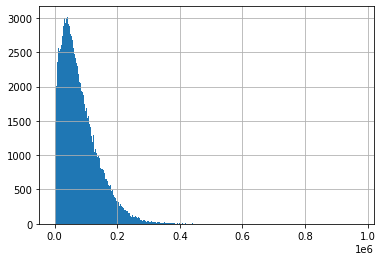

In [ ]:
client_behave_trace.duration.hist(bins='auto'); plt.show()

The subsequent distribution should show us how different the activity cycles recorded in the traces are. Due to the considerable variation in finish times, it was necessary to use the `finish_time` as a normalisation factor above to simulate devices operating in the same period. 

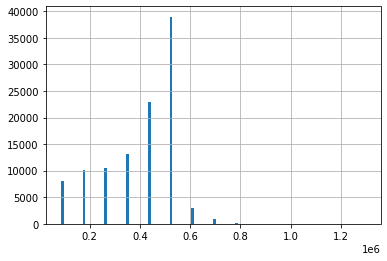

In [ ]:
client_behave_trace.finish_time.hist(bins='auto'); plt.show()

One of the choices we had to make when modelling client activity concerned handling the period between 0 and when a client first becomes active; we can now inspect the motivating factors behind treating that period as inactive. 

Our choice was theoretically justifiable and practical given the start-times distribution we see below. The peak around 0 is natural, given that this was when the recording started. However, it may create difficulties during FL simulations as it would allow many clients to be available immediately for the first few rounds. Additionally, as all clients would be right at the beginning of their active period for the first round, it would create a scenario with minimal drop-out rates.  

>By treating everyone who starts later than 0 as inactive at the start, we lower the potential bias towards the early rounds that a simulation may have. 

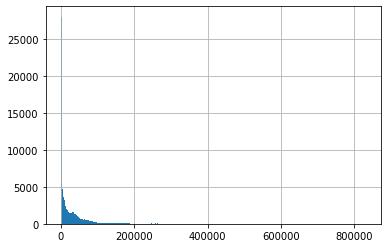

In [ ]:
# New column containing the start time of 
# each client defined as the beginning
# of their first active period
client_behave_trace['first_active'] = client_behave_trace['active'].map(lambda x: x[0])
client_behave_trace.first_active.hist(bins='auto'); plt.show()

#### ! **Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Randomly sample 100 behavioural traces from `client_behave_trace`. Sample without replacement. Plot the total number of active and inactive clients over time for 600000 seconds using steps of 10 seconds.
2. Sort `client_behave_trace` by `finish_time` in **ascending** order. Call it `ft_sorted_client_behave`. Repeat point (1) using `ft_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
3. Sort `client_behave_trace` by `duration` in **descending** order. Call it `dur_sorted_client_behave`. Repeat point (1) using `dur_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
4. Compare the three plots. What do you observe? What are the implications of performing FL with such populations?


1) Plot of num clients active over 600,000 second period (Random sample)

In [ ]:
fast_isActive =  np.vectorize(isActive,signature="(),()->()")

In [ ]:
def get_num_avail(df, client_idxs, times):
  return np.vstack(
      np.array(
          pd.DataFrame(df, index=client_idxs)
          .apply(lambda x: fast_isActive(dict(x),times), axis=1)
      )
  ).sum(axis=0)

In [ ]:
p1_client_idxs = np.random.choice(np.arange(1,107750),100, replace=False,)
p1_times = np.arange(0,600000,10)
p1_num_avail = get_num_avail(client_behave_trace, p1_client_idxs,p1_times)

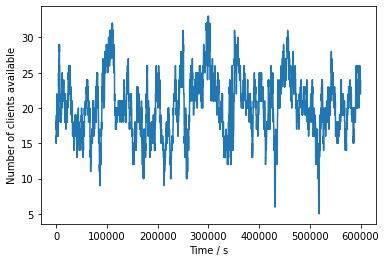

In [ ]:
plt.plot(p1_times,p1_num_avail)
plt.xlabel("Time / s")
plt.ylabel("Number of clients available")
plt.show()

2) Plot of num clients active over 600,000 second period (earliest finish)

In [ ]:
ft_sorted_client_behave = client_behave_trace.sort_values("finish_time")

In [ ]:
p2_client_idxs = np.array(ft_sorted_client_behave.index[:100])
p2_times = np.arange(0,600000,10)
p2_num_avail = get_num_avail(client_behave_trace, p2_client_idxs, p2_times)

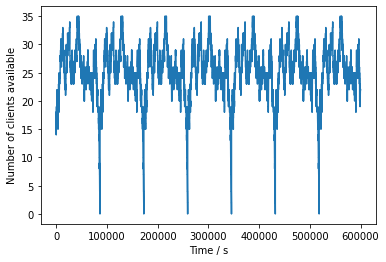

In [ ]:
plt.plot(p2_times,p2_num_avail)
plt.xlabel("Time / s")
plt.ylabel("Number of clients available")
plt.show()

In [ ]:
np.array(ft_sorted_client_behave.loc[p2_client_idxs].finish_time)

array([86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400], dtype=object)

3) Plot of num clients active over 600,000 second period (longest duration)

In [ ]:
dur_sorted_client_behave = client_behave_trace.sort_values("duration",ascending=False)

In [ ]:
p3_client_idxs = np.array(dur_sorted_client_behave.index[:100])
p3_times = np.arange(0,600000,10)
p3_num_avail = get_num_avail(client_behave_trace, p3_client_idxs, p3_times)

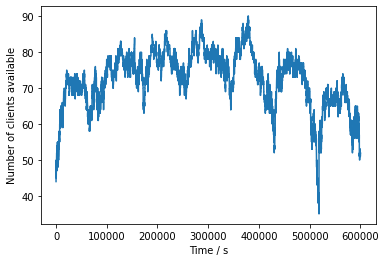

In [ ]:
plt.plot(p3_times,p3_num_avail)
plt.xlabel("Time / s")
plt.ylabel("Number of clients available")
plt.show()

4) Compare the three plots

- The first plot shows a fairly random graph of client availablilty with roughly 15-25% of clients available at any time. A 24 hour cyclical pattern (86400 seconds) can almost be seen, where there a lot more clients available at certain times of day

- The second plot shows 100 clients who are conencted for exactly 1 day. Because of how isActive is defined they therefore follow a perfect 24 hour cyclical pattern and at the start of each cycle there are no clients available (normalized_time = 0). The peaks are at 35% availability and the troughs at 15% (ignoreing the artificial 0s) - slightly higher than the genral population

- The third plot shows slow clients (which take a long time to respond with updates. They also display a 24-cyclical pattern of availability but is it less pronounced than in the other graphs. These clients are generally more active, with each day having long periods with over 60% availability. There is also a weekly trend visible here, with more clients available on some days of the week (the graph shows around 7 days) than on others.

- This data suggests that if the clients are connected for short periods, then there arre large fluctuations in the numbers of clients avaiable at different times - meaning training might be easier at certain times of day.

- It also suggests that slow clients tend to be more reliably available - i.e. are less likely to fail to respond with updatas each round, and also are available throughout the day. However, this could lead to longer rounds as the server has to wait longer.


#### ! **Question 6 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences each**. **No code** is needed)

1. In light of your consideration about question (5) above, what do you think could happen when reverting the ordering in point (2) and point (3)? Focus on the plots.
2. What are the implications of the FL training with such populations? Refer to populations with reverse ordering in point (2) and point (3).

1) What would be seen if sorted in reverse order
- Clients with early finishing times had a slightly higher average availability and followed a more regular pattern than the average client, so I would expect that clients with later finishing times had slightly below average availability and followed a less rigid pattern (but still roughly follow a 24 hour cycle)
- Clients with long durations were very highly available compared to average so I would expect clients with short durations to be very rarely available.

2) Implication for training on these populations
Assuming my predictions are correct:
- Clients that connect for a long time: Fewer of these will be available at any time, so to get the same number of available clients each round more clients will need to be connected to the network.
- Clients that take a short time to run: These will be very rarely available however they will respond with updates much quicker than other clients and may spend a lot of their time idle (if synchronous aggregation). Depending on the relative timing between duration and length of availability period, these clients may be more likely to drop out mid-round.

### Analyse what's inside device capabilities

In the next few cells, we will analyse the content of `client_device_trace`.
Primarily, we will focus on the distribution of `computation` and `communication` on the clients and the afferent trade-off between the two, given a specific model size. 

As we could have imagined, the devices' computational capabilities are highly heterogeneous. For example, despite the consistent peak at around 25 ms/sample, there is a relevant part of the population of devices with values 6 to 8 times higher. Suppose such heterogeneity in computation was related to factors influencing the data distribution. In that case, it could induce significant bias in the model training procedure, which would have to be considered by the developer. 

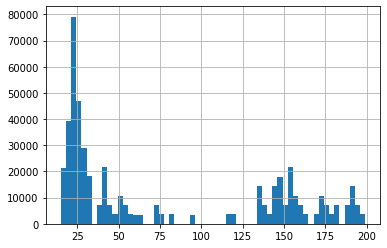

In [ ]:
client_device_capacity.computation.hist(bins='auto'); plt.show()

The communication capabilities are also very heterogeneous, as expected. Despite the distribution having a more apparent peak with a shorter tail, some devices have communication capabilities orders of magnitude higher than the peak of the distribution. 

Geographic variance in network speed is non-uniform and related to the data a given client may contain.

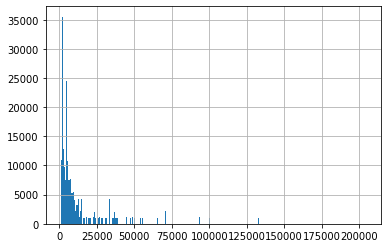

In [ ]:
client_device_capacity.communication.hist(bins='auto'); plt.show()

In [ ]:
client_device_capacity.communication.mean()

13736.140238980068

#### ! **Question 7 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)


Looking carefully at the number in the y-axis, some of you may have noticed that the number of samples retrieved from `client_behave_trace` is not the same as that retrieved from `client_device_capacity`. Given this fact, we may wish to investigate if they are drawn from the same population of devices.
1. Plot communication and computation mapped one-to-one using the entirety of `client_device_capacity`. 
  * Do you notice any correlation between the two traces as given?
2. Fix two different thresholds for computation, and plot the histogram of communication costs from the previous mapping using only traces whose computation falls below the given threshold. 
  * Do these histograms look different from one another? 
  * Do they look different from the overall communication histogram?
3. Fix two communication thresholds and plot the histograms of computation costs of traces with communication values falling below the thresholds.
  * Do these histograms look different from one another? 
  * Do they look different from the overall computation histogram?

1) Plot communication and computation and look for correlation

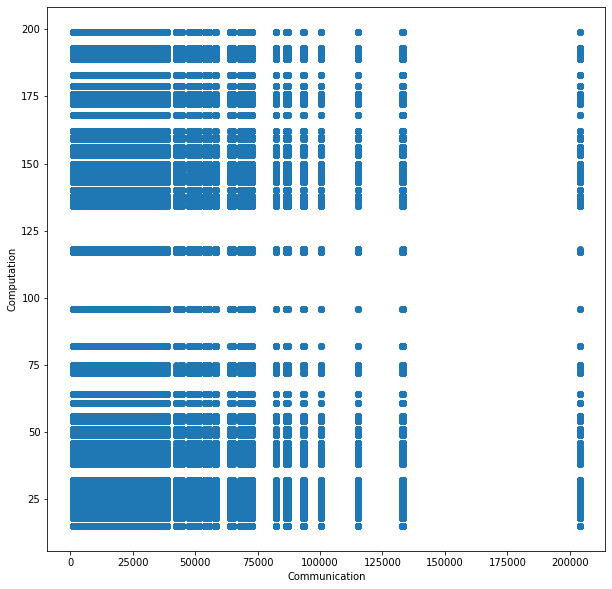

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(client_device_capacity.communication),np.array(client_device_capacity.computation))
plt.xlabel("Communication")
plt.ylabel("Computation")
plt.show()

- There does not seem to be any correlation between the communication and computation for the two traces

2) Fix 2 thresholds for max computation and compare histograms of communication

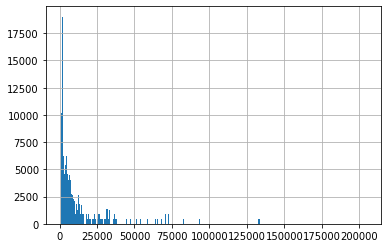

In [ ]:
client_device_capacity[client_device_capacity.computation<30].communication.hist(bins='auto'); plt.show()

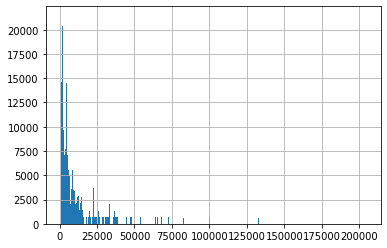

In [ ]:
client_device_capacity[client_device_capacity.computation<125].communication.hist(bins='auto'); plt.show()

- They look the same as eachother and the overall histogram

3) Fix 2 thresholds for max communication and compare histograms of computation

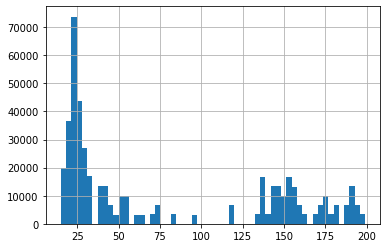

In [ ]:
client_device_capacity[client_device_capacity.communication<40000].computation.hist(bins='auto'); plt.show()

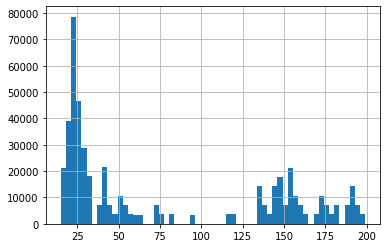

In [ ]:
client_device_capacity[client_device_capacity.communication<125000].computation.hist(bins='auto'); plt.show()

- They look the same as eachother and the overall histogram

The mismatch between the two types of traces is because the authors of FedScale have combined two separate datasets to construct the files. They used [AI benchmark](https://arxiv.org/abs/1910.06663) to obtain the performance capabilities of mobile devices and [MobiPerf](https://www.measurementlab.net/tests/mobiperf/) to gather the availability traces. 

Similarly to the mismatch between traces and data we have previously discussed, experiments using performance and availability traces collected from separate devices may not generalise to the real world. However, since we do not yet have the large-scale datasets necessary to model FL systems accurately, we will have to accept this inconsistency. 

In [ ]:
print(f"The number of samples in `client_behave_trace` is {len(client_behave_trace)}")
print(f"The number of samples in `client_device_capacity` is {len(client_device_capacity)}")

The number of samples in `client_behave_trace` is 107749
The number of samples in `client_device_capacity` is 500000


Because the clients do not come from the same population, we need to devise a method for synchronising them.
The most straightforward procedure we can devise is to sample `len (client_behave_trace)` data points from `client_device_capacity` uniformly. Many other methods that can extract distributions with particular characteristics are possible, but we will do this for brevity.

# RUN

In [ ]:
# NOTE: setting random state does NOT make this return the same thing every run!
client_device_capacity = client_device_capacity.sample(len(client_behave_trace), replace=False, random_state=Seeds.DEFAULT)
client_device_capacity

,computation,communication
47207,193.0,69699.145846
461140,183.0,2839.221328
142018,25.0,2691.448988
87018,143.0,19808.991593
141996,18.0,23756.694131
...,...,...
49123,50.0,13702.634065
177902,149.0,3958.580828
118303,74.0,1696.431054
222990,64.0,31429.813032


# DO NOT RUN

We can plot the distributions from `client_device_capacity` to see if the sampling procedure has succeeded before we apply it in our experiments.

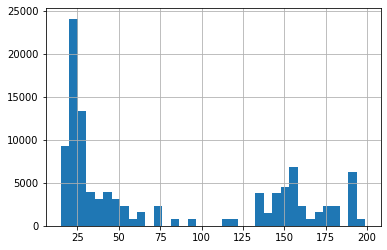

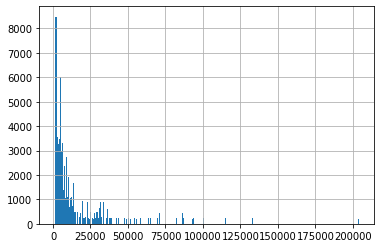

In [ ]:
client_device_capacity.computation.hist(bins='auto'); plt.show()
client_device_capacity.communication.hist(bins='auto'); plt.show()

For later experiments, you will have to use a computation threshold to select clients. The following plot is likely the most revealing if you wish to understand better the impact a particular computation threshold will have on the number of clients that may be included in a given round. Pay particular attention to the sharp increase at the start of the plot.

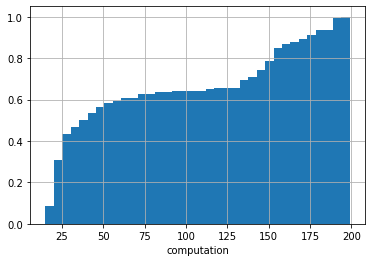

In [ ]:
client_device_capacity.computation.hist(bins='auto', cumulative=True, density=True); plt.xlabel("computation"); plt.show()

#### ! **Question 8 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

We have just extracted and analysed the device capabilities of our population and obtained some idea about how communication and computation capabilities are distributed. However, the exact trade-off depends on `model_size`, `batch_size` and `n_batches`. Since `batch_size*n_batches` is fixed to equal the local dataset size, `model_size` requires closer attention for our modelling of FL systems to be informative. Specifically, we want both communication and computation to have detectable impacts on your FL experiments and their interaction shifts as you scale a network.

Our function `get_client_completion_time` can help us observe the trade-off between computation and communication without running costly FL experiments. For the following question, assume that `batch_size=32`, `n_batches=64` stay fixed.

1. Compute the average client completion time for different values of `model_size`. The average is intended to be over the population described by `client_device_capacity`. Choose at least 100 different values of the `model_size` in the interval `[0,2000] MB`.
2. Plot your results from (1) as explained here: from (1) you will have the average communication latency (`a`), the average computation latency (`b`), and you can compute their sum (`c`). Then, plot those three curves (`a`, `b`, and `c`) in the same graph VS model size. The intersection point between `a` and `b` must be visible. What does it represent?
3. Extract the model size from the intersection point in (2). 


>**You are required** to use the intersection parameter throughout the rest of this work.


1) Compute average client completion times

- Note: doing this using get_client_completion time is painfully slow...
- On the other hand using numpy this can be done very fast!
- computation not affected by model size so just need to calculate the average once
- communication we do need to work out for each size but this can be made fast using np.vectorize()

In [ ]:
## FROM `get_client_completion_time`
#'computation': augmentation_factor * batch_size * n_batches * float(single_client_device_capacity['computation'])/1000.,
#'communication': 2 * model_size_scale_factor * model_size * 1000 / float(single_client_device_capacity['communication'])}

In [ ]:
mean_computation = np.array(client_device_capacity.computation).mean() # invariant on model size
all_communications = np.array(client_device_capacity.communication)

In [ ]:
def get_avg_communication(model_size):
  return (2.0 * 1.0 * model_size * 1000.0/all_communications).mean()
get_avg_communication = np.vectorize(get_avg_communication)

In [ ]:
model_sizes = np.arange(0,2000)
a = 3.0 * 32 * 64 * mean_computation/1000.0
b = get_avg_communication(model_sizes)
c = a + b

2) Plot  times on a graph

- The intersection point is when equal amounts of time are spent on communication and computation 

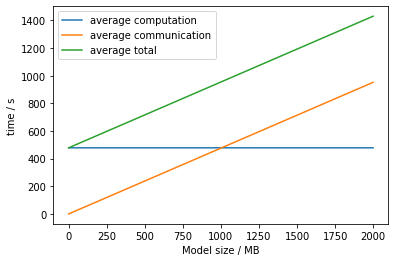

In [ ]:
plt.plot(model_sizes,np.full(len(model_sizes),a), label="average computation")
plt.plot(model_sizes,b, label="average communication")
plt.plot(model_sizes,c, label="average total")
plt.xlabel("Model size / MB")
plt.ylabel("time / s")
plt.legend()

3) Find the intersection point

In [ ]:
# b = poly[0]*model_size + poly[1]
poly = np.polyfit(model_sizes,b,1)
# b == a when model_size = (a-poly[1])/poly[0]
intersect_size = (a-poly[1])/poly[0]
# Check that difference basically zero at this point
print(f"At model_size = {intersect_size} time difference is {get_avg_communication(intersect_size)-a:.15f}")

At model_size = 1004.5082782491909 time difference is -0.000000000000284


- Intersection at 1004.508 MB (may vary slightly between runs of this notebook as pandas doesn't choose the same random set of traces each time)

# 4. Implementing system traces in the simulation

# RUN

To implement our system traces into the Flower simulator to model a real FL federation, we need to extend the abstraction of `FlowerRayClient`. The new version of the abstraction shall include the information we have extracted from the traces. Achieving this will require creating a new class `FlowerRayClientTraces`, which inherits from `FlowerRayClient`.

The new class will have minimal new attributes and functions needed to model the actual system accurately. We will simulate clients dropping out of the federation by throwing exceptions and allowing Flower to accept failures.

The `get_flower_client_generator` function will be modified to return a generator of `FlowerRayClientTraces` instead of `FlowerRayClient`. In addition, we will pass the traces that must be coupled to the clients as parameters.

## Implementation

We will also use previously unrevealed Flower features, such as client properties and criteria, so pay attention to those details. In short, clients can return properties to a criterion after they have been instantiated. The criterion then decides if the client should be included in the next federated round based on those properties.

In [ ]:
class FlowerRayClientTraces(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        single_client_device_capacity: Dict[str, Any],
        single_client_traces: Dict[str, Any],
        verbose: bool = False,
    ) -> None:
        """Function to initialise the client with its unique id
        and the directory from which it can load its data.
        Device capabilities and traces are also passed to the client.

        Args:
            data_dir (Path): path to the dataset folder.
            cid (int): Unique client id for a client used to map it to its data partition
            partition_dir (Path): The directory containing data for each client/client id
            model_generator (Callable[[], Module]): The model generator function
            single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
            single_client_traces (Dict[str, Any]): dictionary describing client device traces.
            verbose (bool): boolean describing whether the client should print or not.
        """
        super().__init__(cid, data_dir, partition_dir, model_generator)
        self.device_capacity = single_client_device_capacity
        self.trace = single_client_traces
        self.verbose = verbose
        self.properties: Dict[str, Scalar] = { # type: ignore
            "tensor_type": "numpy.ndarray",
            "cid": self.cid,
            "device_capacity": self.device_capacity,
            "traces": self.trace,
            }

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict.
        Before training, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """

        # We need to include model size to compute communications costs
        # As part of our systems-aware simulation
        # Importantly, since Flower now accepts failures this will only cause the client to return a failure
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # We need to compute the number of samples in the training set
        # As such we set n_batches to the number of batches which the set contains
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(int(config['epochs'])*self.get_train_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )
        # Add up the communication and computation times
        total_time = completion_time['communication']+completion_time['computation']

        # Store the result in the trace
        self.trace['duration'] = total_time

        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        params, n_samples, results = super().fit(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return params, n_samples, results

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[float, int, dict]:
        """Function which receives and tests a model on the local client data using parameters from the config dict
        Before testing, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns:
            Tuple[float, int, dict]: Returns the loss accumulate during testing, the size of the local dataset and other metrics such as accuracy
        """
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # Estimate time based on number of batches in dataset
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(self.get_test_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )

        # Compute total time
        total_time = completion_time['communication']+completion_time['computation']

        # Store result in trace
        self.trace['duration'] = total_time
        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        loss, n_samples, results = super().evaluate(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return loss, n_samples, results

In [ ]:
def get_flower_client_with_traces_generator(
    clients_device_capacity: List[Dict[str, Any]],
    clients_traces: List[Dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        clients_device_capacity (List[Dict[str, Any]]): list containing the clients device capabilities.
        clients_traces (List[Dict[str, Any]]): list containing the clients traces.
        data_dir (Path): path to the datasßet folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """
    def client_fn(cid: str) -> FlowerRayClientTraces:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClientTraces: client instance.
        """
        print(f"Getting client with id {cid}")
        client = FlowerRayClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data mapping
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid), # type: ignore
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the verbosity to False
            verbose=False,
        )
        
        client.device = get_device()
        return client

    return client_fn

# 5. Setting up selection criteria

# RUN

Selection criteria in FL may be varied; examples of such criteria include:
1. The client's hardware capabilities; if they cannot train a given model (i.e., they lack a necessary accelerator), they should not be selected.
2. Network and battery conditions; if the client is a phone which lacks access to power and free Wi-Fi, it should not be selected.
3. Statistical utility; if a client seems likely to have data which interests us---based on previous selection or other characteristics such as provenance region---it should be selected to the detriment of other clients. 

>This lab shall focus on the first type of criteria. However, we shall build correlations between statistical utility and computational ability throughout to test how their inter-connection **could** impact FL under various assumptions.

## Implement selection criteria using the Criterion object

In the following cell, an example of a `Criterion` object is provided.
Note that this does not discriminate between clients beyond checking their availabilities, but it is still helpful to understand how it functions.  For later questions, you may desire to impose a selection criterion in your client selection based on this template.

Be aware that using one of these objects implies additional communication between the client and the server. However, we will assume in our modelling that this communication is near-immediate (constant relative to the client dataset size) and is not affecting the federation by any means. 

It is worth mentioning that the potential design space of criteria in Flower is limited by the requirement of only communicating once with the client and only being able to receive data from the client's properties. These constraints make it impossible for the server to communicate data to the client at the criterion level so that the client may make dynamic decisions regarding participation. Furthermore, without a persistent communication channel, the criterion may become false before the round begins, and the client has no means of informing the server. 

To overcome these limitations, it would be valuable to expand and enhance the current implementation that Flower has under the hood for a potential Part II project. 

In [ ]:
class TemplateCriterion(Criterion):
    """This class implements the Template criterion."""
    
    def __init__(self, **kwargs: Any) -> None:
        """Initializes the Template criterion.

        Args:
            **kwargs (Any): additional arguments.
        """
        super().__init__(**kwargs)

        """
            Put here the logic to set global parameters
            for selection, s.a. thresholds.
        """
        
    def select(self, client: ClientProxy) -> bool:
        """Selects the client that receives.
        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns:
            bool: True if the client is selected, False otherwise.
        """        
        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
            }
        ins: GetPropertiesIns = GetPropertiesIns(
            config=request_properties
        )
        # This contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: This object receives the current virtual clock from the server
        # in the CustomClientManager
        print(self.current_virtual_clock) # type: ignore

        """
            Put here the logic to select the client.
        """
        
        return True

Here follows the implementation of `ActivityCriterion`, a `Criterion` object that selects clients based on their activity evaluated at the selection time.
>Selecting clients using this does not guarantee they will not drop out during the local training phase.

In [ ]:
class ActivityCriterion(Criterion):
    """This class implements the Template criterion."""
    
    def __init__(self) -> None:
        """Initializes the Template criterion."""
        self.current_virtual_clock = 0
    
    def select(self, client: ClientProxy) -> bool:
        """Selects the client that receives if it is active.
        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns:
            bool: True if the client is selected, False otherwise.
        """        
        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
            }
        ins: GetPropertiesIns = GetPropertiesIns(
            config=request_properties
        )
        # This contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: here we use `isActive` to check if the client is active at the current time step
        return isActive(value.properties['traces'], self.current_virtual_clock) # type: ignore

The following cell is meant to initialise the model.

In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

Given that you have determined the intersection point within the traces we use, it is reasonable to consider the actual size of our model in MB. For this, we shall use the `torchsummary` package. 

>**KEEP USING THE INTERSECTION MB VALUE DETERMINED ABOVE**

In [ ]:
import torchsummary
torchsummary.summary(seed_net_cnn.to(get_device()), (1, 28, 28), device=get_device())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 62]           5,270
Total params: 48,846
Trainable params: 48,846
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.19
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


As we can see, the network we have selected for demonstration purposes in this lab is tiny and should thus result in meagre communication costs relative to computation. However, the balance between computation and communication would likely not be so one-sided in a production system.

Thus far, we have treated the two costs as equivalent in terms of their impact on the overall training time of the FL system. However, the two are not always symmetrical in terms of costs. For example, if the entity running the federation does not own nor pay for the resources of the underlying devices---as is the case in many scenarios involving smartphones---then computation on-edge incurs zero monetary costs. At the same time, models' storage and transmission scales with the size and number of networks. Furthermore, while we only account for model size in the communication costs, a larger model requires more operations per training step and more training steps overall to train. 

All of these factors guide FL to be biased towards using architectures with a lower footprint, reducing model size via quantisation, and clustering clients into small groups that have similar data---which a small network can quickly learn from. 

We also need the `federated_evauation_function` to be used in the server for evaluating the model on the `val` set. 

In [ ]:
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

Here the function to generate clients is provided. Note that if you want to use a different `client_device_capacity` or `client_behave_trace`, you need to change the parameters here and re-execute the cell.

In [ ]:
client_device_capacity.shape, client_behave_trace.shape

((107749, 2), (107749, 5))

In [ ]:
# NOTE: we are using here the `get_flower_client_with_traces_generator`
num_total_clients = 3229
sampled_cdc = client_device_capacity.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)
sampled_cbt = client_behave_trace.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)

flower_client_with_traces_generator: Callable[
    [int], FlowerRayClientTraces
] = get_flower_client_with_traces_generator(
    clients_device_capacity=sampled_cdc.to_dict('records'), # type: ignore
    clients_traces=sampled_cbt.to_dict('records'), # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition) # type: ignore

The following cell contains the vast majority of the hyperparameters for the FL training. Notice the addition of a model size and virtual clock in the configs and the `accept_failures` = True` parameter.

In [ ]:
train_config = get_default_train_config()
train_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })
test_config = get_default_test_config()
test_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config # type: ignore

num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

accept_failures = True
min_fit_clients = 2
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
# maximum amount of resources that a client can take
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0,
    "num_cpus": 1,
}

strategy = FedAvgTraces(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=federated_evaluation_function,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

Since we have introduced a `Criterion` object, we need to use both a `Server` and a `ClientManager`. The `Server` orchestrates training over selected clients while the `ClientManager` is tasked with providing it with the lists of clients used for a given round. Consequently, they will wrap our `Criterion` with all the utilities to let the FL simulation use it.

In [ ]:
criterion = ActivityCriterion()
client_manager = CustomClientManager(criterion=criterion, seed=Seeds.DEFAULT)
server = Server(
    client_manager=client_manager,
    strategy=strategy,
)

We may finally launch the simulation with enhanced abilities to select clients based on traces and to have them drop out according to their activity and execution duration.

# DO NOT RUN

In [ ]:
hist = start_seeded_simulation(
    client_fn=flower_client_with_traces_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    server=server,
    config=ServerConfig(num_rounds=10),
    strategy=strategy,
)

WARNING flwr 2023-02-19 19:58:52,482 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-19 19:58:52,566 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-19 19:58:59,652	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-19 19:59:02,022 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3991689216.0, 'GPU': 1.0, 'memory': 7983378432.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3991689216.0, 'GPU': 1.0, 'memory': 7983378432.0}
INFO flwr 2023-02-19 19:59:02,074 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-19 19:59:02,079 | server.py:266

(launch_and_get_properties pid=25443) Getting client with id 2530
(launch_and_get_properties pid=25487) Getting client with id 2184
(launch_and_get_properties pid=25530) Getting client with id 2907
(launch_and_get_properties pid=25576) Getting client with id 1498
(launch_and_get_properties pid=25623) Getting client with id 2338
(launch_and_get_properties pid=25667) Getting client with id 2399
(launch_and_get_properties pid=25709) Getting client with id 2997


DEBUG flwr 2023-02-19 19:59:29,887 | server.py:215 | fit_round 1: strategy sampled 3 clients (out of 3229)
DEBUG:flwr:fit_round 1: strategy sampled 3 clients (out of 3229)


Sampled the following clients:  ['2907', '2338', '678']
(launch_and_get_properties pid=25749) Getting client with id 678


DEBUG flwr 2023-02-19 19:59:32,775 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=25794, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-15-a218b4825aa9>", line 79, in fit
Exception: Client 2338 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=25794, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    retu

(launch_and_fit pid=25794) Getting client with id 2338
(launch_and_fit pid=25795) Getting client with id 678


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=25872) Getting client with id 2907


 88%|████████▊ | 7/8 [00:06<00:00,  2.40it/s]
DEBUG flwr 2023-02-19 19:59:48,139 | server.py:229 | fit_round 1 received 2 results and 1 failures
DEBUG:flwr:fit_round 1 received 2 results and 1 failures
INFO flwr 2023-02-19 19:59:48,143 | strategy.py:186 | Completion times of clients: [511.7667562372511, 1087.5163560740814]
INFO:flwr:Completion times of clients: [511.7667562372511, 1087.5163560740814]
INFO flwr 2023-02-19 19:59:48,149 | strategy.py:188 | Maximum completion time of clients: 1087.5163560740814
INFO:flwr:Maximum completion time of clients: 1087.5163560740814
100%|██████████| 891/891 [00:13<00:00, 65.62it/s]
INFO flwr 2023-02-19 20:00:01,755 | server.py:116 | fit progress: (1, 3312.4166975021362, {'accuracy': 0.07969133637320239}, 49.24014277800006)
INFO:flwr:fit progress: (1, 3312.4166975021362, {'accuracy': 0.07969133637320239}, 49.24014277800006)
INFO flwr 2023-02-19 20:00:01,767 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f56d52cca90

(launch_and_get_properties pid=26456) Getting client with id 2530
(launch_and_get_properties pid=26505) Getting client with id 2184
(launch_and_get_properties pid=26552) Getting client with id 2907
(launch_and_get_properties pid=26594) Getting client with id 1498
(launch_and_get_properties pid=26636) Getting client with id 2338
(launch_and_get_properties pid=26675) Getting client with id 2399
(launch_and_get_properties pid=26719) Getting client with id 2997


DEBUG flwr 2023-02-19 20:00:20,494 | server.py:165 | evaluate_round 1: strategy sampled 2 clients (out of 3229)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 3229)


Sampled the following clients:  ['2907', '678']
(launch_and_get_properties pid=26761) Getting client with id 678
(launch_and_evaluate pid=26811) Getting client with id 2907
(launch_and_evaluate pid=26812) Getting client with id 678


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
DEBUG flwr 2023-02-19 20:00:32,513 | server.py:179 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
INFO flwr 2023-02-19 20:00:32,518 | strategy.py:186 | Completion times of clients: [987.1963560740813, 28.69475623725114]
INFO:flwr:Completion times of clients: [987.1963560740813, 28.69475623725114]
INFO flwr 2023-02-19 20:00:32,521 | strategy.py:188 | Maximum completion time of clients: 987.1963560740813
INFO:flwr:Maximum completion time of clients: 987.1963560740813
INFO flwr 2023-02-19 20:00:32,531 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f56d52cca90>
INFO:flwr:Sampling using <__main__.ActivityCriterion object at 0x7f56d52cca90>
100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


(launch_and_get_properties pid=26976) Getting client with id 1573
(launch_and_get_properties pid=27015) Getting client with id 2992
(launch_and_get_properties pid=27059) Getting client with id 2286
(launch_and_get_properties pid=27101) Getting client with id 2763
(launch_and_get_properties pid=27145) Getting client with id 1616
(launch_and_get_properties pid=27191) Getting client with id 194
(launch_and_get_properties pid=27237) Getting client with id 75
(launch_and_get_properties pid=27279) Getting client with id 1746
(launch_and_get_properties pid=27325) Getting client with id 796
(launch_and_get_properties pid=27363) Getting client with id 1274
(launch_and_get_properties pid=27406) Getting client with id 1444


DEBUG flwr 2023-02-19 20:00:57,711 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3229)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 3229)


Sampled the following clients:  ['75', '796', '2035']
(launch_and_get_properties pid=27449) Getting client with id 2035
(launch_and_fit pid=27496) Getting client with id 75
(launch_and_fit pid=27497) Getting client with id 796


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


(launch_and_fit pid=28032) Getting client with id 2035


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]
DEBUG flwr 2023-02-19 20:01:24,322 | server.py:229 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-02-19 20:01:24,330 | strategy.py:186 | Completion times of clients: [296.5387975793243, 104.8773233736289, 2934.0096853169944]
INFO:flwr:Completion times of clients: [296.5387975793243, 104.8773233736289, 2934.0096853169944]
INFO flwr 2023-02-19 20:01:24,335 | strategy.py:188 | Maximum completion time of clients: 2934.0096853169944
INFO:flwr:Maximum completion time of clients: 2934.0096853169944
100%|██████████| 891/891 [00:16<00:00, 55.26it/s]
INFO flwr 2023-02-19 20:01:40,505 | server.py:116 | fit progress: (2, 3275.9637291431427, {'accuracy': 0.005506839705366538}, 147.98993869399965)
INFO:flwr:fit progress: (2, 3275.9637291431427, {'accuracy': 0.005506839705366538}, 147.98993869399965)
INFO flwr 2023-02-19 20:01:40,516 | client_manager.py:49 | Sampling using <__main__.

(launch_and_get_properties pid=28397) Getting client with id 1573
(launch_and_get_properties pid=28438) Getting client with id 2992
(launch_and_get_properties pid=28486) Getting client with id 2286
(launch_and_get_properties pid=28526) Getting client with id 2763
(launch_and_get_properties pid=28574) Getting client with id 1616
(launch_and_get_properties pid=28618) Getting client with id 194
(launch_and_get_properties pid=28657) Getting client with id 75
(launch_and_get_properties pid=28699) Getting client with id 1746


DEBUG flwr 2023-02-19 20:02:01,301 | server.py:165 | evaluate_round 2: strategy sampled 2 clients (out of 3229)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 3229)


(launch_and_get_properties pid=28745) Getting client with id 796
Sampled the following clients:  ['75', '796']
(launch_and_evaluate pid=28789) Getting client with id 75
(launch_and_evaluate pid=28790) Getting client with id 796


 50%|█████     | 1/2 [00:10<00:10, 10.84s/it]
DEBUG flwr 2023-02-19 20:02:19,601 | server.py:179 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
INFO flwr 2023-02-19 20:02:19,610 | strategy.py:186 | Completion times of clients: [1674.1056853169944, 86.87479757932427]
INFO:flwr:Completion times of clients: [1674.1056853169944, 86.87479757932427]
INFO flwr 2023-02-19 20:02:19,619 | strategy.py:188 | Maximum completion time of clients: 1674.1056853169944
INFO:flwr:Maximum completion time of clients: 1674.1056853169944
INFO flwr 2023-02-19 20:02:19,639 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f56d52cca90>
100%|██████████| 2/2 [00:10<00:00,  5.48s/it]
INFO:flwr:Sampling using <__main__.ActivityCriterion object at 0x7f56d52cca90>


(launch_and_get_properties pid=28990) Getting client with id 2278
(launch_and_get_properties pid=29035) Getting client with id 185
(launch_and_get_properties pid=29086) Getting client with id 2730
(launch_and_get_properties pid=29125) Getting client with id 2021
(launch_and_get_properties pid=29178) Getting client with id 2517
(launch_and_get_properties pid=29224) Getting client with id 1401


KeyboardInterrupt: ignored

Let us investigate the new history object you will use to determine the behaviour of your execution. Notice the addition of a completion time for each client, as they are meant to execute in parallel. The highest completion time represents the duration of a round. Our new strategy and criterion this principle to maintain the `current_virtual_clock`; you may investigate the implementation further by looking into the python files. 

In [ ]:
hist

#### ! **Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Now that we can run a whole synchronised system-aware simulation, it is time we consider how different relations between data and systems characteristics will affect the behaviour of an FL experiment. 

1. Using a mapping function as previously, map the clients with the most computational ability (sort the traces provided to the client generator) to the smallest dataset sizes---corresponding to new devices having less stored data than older ones. Then, use a value of the threshold for computation `threshold=16`, plot the **running sum of samples** included across rounds, **the running sum of compute units** and **reported loss values** against the virtual clock time as the x-axis.

2. Repeat the previous experiment (1), changing the mapping to associate the clients with the most computational ability to the largest dataset sizes--you just need to reverse the ordering of the previous client mapping.

3. Looking at the loss values, total sample count, total compute and virtual clock time, which ordering seems the most efficient at reaching a given loss value in terms of virtual clock time? Explain the trade-offs you observe. 


##### 1) Map clients with MOST computation ability (i.e. lowest value for computation latency) to SMALLEST datasets.
- Then select ONLY clients with LESS THAN 16 for compute
- (This selects clients with SMALLEST datasets)
- Plot sum of samples included, sum of compute units and reported loss against virtual time
- NOTE: Doing this with a criterion alone is PAINFULLY slow!! So I have "prefiltered" clients with fast enough computation to make this take less long to run

##### Generate data

In [ ]:
#@title Copy of client generator for q9 (reduces scrolling)

def q9_get_flower_client_with_traces_generator(
    clients_device_capacity: List[Dict[str, Any]],
    clients_traces: List[Dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    def client_fn(cid: str) -> FlowerRayClientTraces:
        print(f"Getting client with id {cid}")
        client = FlowerRayClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data mapping
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid), # type: ignore
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the verbosity to False
            verbose=True,
        )
        
        client.device = get_device()
        return client

    return client_fn

q9_flower_client_with_traces_generator: Callable[
    [int], FlowerRayClientTraces
] = q9_get_flower_client_with_traces_generator(
    clients_device_capacity=sampled_cdc.to_dict('records'), # type: ignore
    clients_traces=sampled_cbt.to_dict('records'), # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition) # type: ignore

In [ ]:
#@title create new generator that leads to desired mapping 
%%capture

# Work out the current mapping from id to amount of data
client_to_num_sample: List[Tuple[int, int]] = [
    (i, q9_flower_client_with_traces_generator(i).get_train_set_size())
    for i in range(num_total_clients)
]
# Order by increasing amounts of data
client_to_num_sample.sort(key=lambda p: p[1])

# Give generator device capacities in increasing order of computation latency
# AND mapping function for increasing amounts of data
# Note: ordering of client_traces meaningless as not correlated with device capacities
# so fine to use random ordering

increasing_sorted_client_cids = [cid for cid, num_samples in client_to_num_sample]
q9_p1_client_generator: Callable[
    [int], FlowerRayClientTraces
] = q9_get_flower_client_with_traces_generator(
    clients_device_capacity=sampled_cdc.sort_values("computation",ascending=True).to_dict('records'), # type: ignore
    clients_traces=sampled_cbt.to_dict('records'), # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition,
    mapping_fn = lambda compute_idx: increasing_sorted_client_cids[compute_idx]) # type: ignore

In [ ]:
#@title test ordering and mapping

print("Checking ordering works")
print(client_to_num_sample[:2], increasing_sorted_client_cids[:2])
print(client_to_num_sample[-2:], increasing_sorted_client_cids[-2:])
print("Checking mapping works")
print(
    q9_p1_client_generator(0).properties["device_capacity"]["computation"],
    q9_p1_client_generator(0).get_train_set_size()
)
print(
    q9_p1_client_generator(1).properties["device_capacity"]["computation"],
    q9_p1_client_generator(1).get_train_set_size()
)
print(
    q9_p1_client_generator(num_total_clients-2).properties["device_capacity"]["computation"],
    q9_p1_client_generator(num_total_clients-2).get_train_set_size()
)
print(
    q9_p1_client_generator(num_total_clients-1).properties["device_capacity"]["computation"],
    q9_p1_client_generator(num_total_clients-1).get_train_set_size()
)

Checking ordering works
[(1528, 16), (628, 19)] [1528, 628]
[(447, 393), (178, 418)] [447, 178]
Checking mapping works
Getting client with id 0
Getting client with id 0
15.0 16
Getting client with id 1
Getting client with id 1
15.0 19
Getting client with id 3227
Getting client with id 3227
199.0 393
Getting client with id 3228
Getting client with id 3228
199.0 418


In [ ]:
get_default_train_config()

{'epochs': 8,
 'batch_size': 32,
 'client_learning_rate': 0.01,
 'weight_decay': 0.001,
 'num_workers': 2}

In [ ]:
#@title create new strategy to reduce criterion running time
def q9_get_strategy(q9_num_total_clients,batch_size):
  train_config = get_default_train_config()
  train_config.update({
          "model_size": 1004.508, # Model size found earlier
          "current_virtual_clock": 0.0,
          "batch_size": batch_size, # MUST change this to min dataset size (to avoid divide by 0 errors)
      })
  test_config = get_default_test_config()
  test_config.update({
          "model_size": 1004.508, # Model size found earlier
          "current_virtual_clock": 0.0,
      })

  on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
  on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config # type: ignore

  num_clients_per_round: int = 3
  num_evaluate_clients: int = 1
  fraction_fit: float = float(num_clients_per_round) / q9_num_total_clients
  fraction_evaluate: float = float(num_evaluate_clients) / q9_num_total_clients

  accept_failures = True
  min_fit_clients = 2
  min_available_clients = 2
  initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
  # maximum amount of resources that a client can take
  client_resources = {
      "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0,
      "num_cpus": 1,
  }

  return FedAvgTraces(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_available_clients=min_available_clients,
      on_fit_config_fn=on_fit_config_fn,
      on_evaluate_config_fn=on_evaluate_config_fn,
      initial_parameters=initial_parameters,
      accept_failures=accept_failures,
      evaluate_fn=federated_evaluation_function,
      fit_metrics_aggregation_fn=aggregate_weighted_average,
      evaluate_metrics_aggregation_fn=aggregate_weighted_average,
  )

q9_num_total_clients = sampled_cdc[sampled_cdc.computation<16].shape[0] # 70
q9_p1_batch_size = 16 # size of smallest dataset
q9_strategy = q9_get_strategy(q9_num_total_clients,q9_p1_batch_size)

In [ ]:
#@title Create computation criterion and Server to use
class ComputationCriterion(Criterion):
    """This class implements the Template criterion."""
    
    def __init__(self, threshold) -> None:
        """Initializes the Template criterion."""
        self.current_virtual_clock = 0
        self.threshold = threshold
    
    def select(self, client: ClientProxy) -> bool:
        """Selects the client that receives if it is active.
        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns:
            bool: True if the client is selected, False otherwise.
        """        
        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
            }
        ins: GetPropertiesIns = GetPropertiesIns(
            config=request_properties
        )
        # This contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: here we use `isActive` to check if the client is active at the current time step
        # NOTE: This object receives the current virtual clock from the server
        # in the CustomClientManager
        # print(f"looking at {value.properties['cid']} but has computation = { value.properties['device_capacity']['computation'] }")
        return (
            value.properties["device_capacity"]["computation"] < self.threshold
            and
            isActive(value.properties['traces'], self.current_virtual_clock) # type: ignore
        )

q9_p1_criterion = ComputationCriterion(16.0)
q9_p1_client_manager = CustomClientManager(criterion=q9_p1_criterion, seed=Seeds.DEFAULT)
q9_p1_server = Server(
    client_manager=q9_p1_client_manager,
    strategy=q9_strategy,
)

In [ ]:
#@title run simulation with custom generator and server

q9_p1_hist = start_seeded_simulation(
    client_fn=q9_p1_client_generator,
    num_clients=q9_num_total_clients,
    client_resources=client_resources,
    server=q9_p1_server,
    config=ServerConfig(num_rounds=10),
    strategy=strategy,
)

WARNING flwr 2023-02-19 21:49:28,594 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-19 21:49:28,654 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-19 21:49:35,206	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 
INFO flwr 2023-02-19 21:49:37,561 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8009490432.0, 'object_store_memory': 4004745216.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8009490432.0, 'object_store_memory': 4004745216.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-02-19 21:49:37,567 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-19 21:49:37,582 | server.py:266

(launch_and_get_properties pid=94809) Getting client with id 68
(launch_and_get_properties pid=94850) Getting client with id 46
(launch_and_get_properties pid=94892) Getting client with id 21
(launch_and_get_properties pid=94937) Getting client with id 42
(launch_and_get_properties pid=95001) Getting client with id 49
(launch_and_get_properties pid=95045) Getting client with id 69
(launch_and_get_properties pid=95086) Getting client with id 39
(launch_and_get_properties pid=95128) Getting client with id 25
(launch_and_get_properties pid=95173) Getting client with id 44


DEBUG flwr 2023-02-19 21:50:13,636 | server.py:215 | fit_round 1: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 1: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['68', '69', '13']
(launch_and_get_properties pid=95211) Getting client with id 13


DEBUG flwr 2023-02-19 21:50:17,981 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=95257, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-15-a218b4825aa9>", line 79, in fit
Exception: Client 1745 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=95257, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    retu

(launch_and_fit pid=95257) Getting client with id 69
(launch_and_fit pid=95257) Client 1745 --- Current virtual clock time: 0.0
(launch_and_fit pid=95257) Client 1745 --- Duration: 446.214177101942
(launch_and_fit pid=95257) Client 1745 --- Traces: {'duration': 446.214177101942, 'inactive': [31, 564, 593, 612, 14867, 14873, 36306, 49904, 82431, 87033, 88719, 101318, 120936, 122616, 140016, 141323, 141344, 141591, 142126, 144025, 149948, 181453, 199201, 229581, 236167, 263493, 403929, 403938, 408496, 414499, 416994, 418178, 418188, 418219, 418246, 418259, 418346, 419057, 419098, 419118, 419145, 419168, 419187, 420512, 423519, 423530, 494391, 501041, 512686, 513170, 513195, 513218, 517127, 517351, 517371, 517384, 517515, 517597, 517661, 517721, 517735], 'finish_time': 518400, 'active': [0, 544, 575, 595, 627, 14871, 33202, 44430, 81673, 85975, 88446, 92910, 120915, 120942, 122617, 140016, 141332, 141570, 141693, 144014, 149938, 173867, 199190, 207442, 229581, 262127, 401958, 403930, 4050

 88%|████████▊ | 7/8 [00:07<00:00,  1.34it/s]
DEBUG flwr 2023-02-19 21:50:35,137 | server.py:229 | fit_round 1 received 2 results and 1 failures
DEBUG:flwr:fit_round 1 received 2 results and 1 failures
INFO flwr 2023-02-19 21:50:35,141 | strategy.py:186 | Completion times of clients: [39.10873941769323, 1006.8065517494814]
INFO:flwr:Completion times of clients: [39.10873941769323, 1006.8065517494814]
INFO flwr 2023-02-19 21:50:35,146 | strategy.py:188 | Maximum completion time of clients: 1006.8065517494814
INFO:flwr:Maximum completion time of clients: 1006.8065517494814
100%|██████████| 891/891 [00:16<00:00, 53.24it/s]
INFO flwr 2023-02-19 21:50:51,916 | server.py:116 | fit progress: (1, 3411.1566348075867, {'accuracy': 0.07969133637320239}, 62.33388857799946)
INFO:flwr:fit progress: (1, 3411.1566348075867, {'accuracy': 0.07969133637320239}, 62.33388857799946)
INFO flwr 2023-02-19 21:50:51,921 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35

(launch_and_get_properties pid=95942) Getting client with id 68
(launch_and_get_properties pid=95983) Getting client with id 46
(launch_and_get_properties pid=96026) Getting client with id 21
(launch_and_get_properties pid=96068) Getting client with id 42
(launch_and_get_properties pid=96107) Getting client with id 49


DEBUG flwr 2023-02-19 21:51:04,502 | server.py:165 | evaluate_round 1: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['68', '69']
(launch_and_get_properties pid=96155) Getting client with id 69
(launch_and_evaluate pid=96202) Getting client with id 69
(launch_and_evaluate pid=96202) Client 1745 --- Current virtual clock time: 1006.8065517494814
(launch_and_evaluate pid=96202) Client 1745 --- Duration: 410.93417710194205
(launch_and_evaluate pid=96202) Client 1745 --- Traces: {'duration': 410.93417710194205, 'inactive': [31, 564, 593, 612, 14867, 14873, 36306, 49904, 82431, 87033, 88719, 101318, 120936, 122616, 140016, 141323, 141344, 141591, 142126, 144025, 149948, 181453, 199201, 229581, 236167, 263493, 403929, 403938, 408496, 414499, 416994, 418178, 418188, 418219, 418246, 418259, 418346, 419057, 419098, 419118, 419145, 419168, 419187, 420512, 423519, 423530, 494391, 501041, 512686, 513170, 513195, 513218, 517127, 517351, 517371, 517384, 517515, 517597, 517661, 517721, 517735], 'finish_time': 518400, 'active': [0, 544, 575, 595, 627, 14871, 33202, 44430, 81673, 85975

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]
DEBUG flwr 2023-02-19 21:51:16,542 | server.py:179 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
INFO flwr 2023-02-19 21:51:16,551 | strategy.py:186 | Completion times of clients: [410.93417710194205, 971.5265517494814]
INFO:flwr:Completion times of clients: [410.93417710194205, 971.5265517494814]
INFO flwr 2023-02-19 21:51:16,554 | strategy.py:188 | Maximum completion time of clients: 971.5265517494814
INFO:flwr:Maximum completion time of clients: 971.5265517494814
INFO flwr 2023-02-19 21:51:16,557 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


(launch_and_get_properties pid=96367) Getting client with id 65
(launch_and_get_properties pid=96405) Getting client with id 41
(launch_and_get_properties pid=96453) Getting client with id 21
(launch_and_get_properties pid=96493) Getting client with id 46
(launch_and_get_properties pid=96540) Getting client with id 31
(launch_and_get_properties pid=96583) Getting client with id 39
(launch_and_get_properties pid=96630) Getting client with id 66
(launch_and_get_properties pid=96678) Getting client with id 25
(launch_and_get_properties pid=96716) Getting client with id 55
(launch_and_get_properties pid=96758) Getting client with id 11
(launch_and_get_properties pid=96800) Getting client with id 62
(launch_and_get_properties pid=96839) Getting client with id 37
(launch_and_get_properties pid=96884) Getting client with id 12
(launch_and_get_properties pid=96925) Getting client with id 20
(launch_and_get_properties pid=96972) Getting client with id 61
(launch_and_get_properties pid=97013) Ge

DEBUG flwr 2023-02-19 21:51:58,708 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['65', '25', '58']
(launch_and_get_properties pid=97149) Getting client with id 58
(launch_and_fit pid=97196) Getting client with id 58
(launch_and_fit pid=97196) Client 1720 --- Current virtual clock time: 1978.3331034989628
(launch_and_fit pid=97196) Client 1720 --- Duration: 911.4978249737421
(launch_and_fit pid=97196) Client 1720 --- Traces: {'duration': 911.4978249737421, 'inactive': [1320, 1782, 2596, 3367, 3575, 5138, 5166, 17716, 18871, 19051, 19062, 19079, 19130, 19136, 19159, 19257, 19539, 19592, 19596, 19656, 19700, 19718, 19742, 19779, 19805, 19858, 20017, 20085, 20092, 20114, 20154, 20169, 20300, 20355, 20389, 20401, 20438, 20498, 20538, 20562, 20579, 20599, 20623, 20634, 20644, 20667, 20687, 20701, 20734, 20780, 20788, 20805, 20849, 20888, 20920, 20931, 20963, 20974, 21036, 21048, 21072, 21090, 21111, 21138, 21190, 21226, 21256, 21286, 21304, 21316, 21360, 21369, 21423, 21430, 32406, 48241, 48324, 62035, 62398, 62408, 79225, 176790, 219896,

100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


(launch_and_fit pid=97729) Getting client with id 25
(launch_and_fit pid=97729) Client 2305 --- Current virtual clock time: 1978.3331034989628
(launch_and_fit pid=97729) Client 2305 --- Duration: 1824.6165021171323
(launch_and_fit pid=97729) Client 2305 --- Traces: {'duration': 1824.6165021171323, 'inactive': [3804, 7971, 25527, 69535], 'finish_time': 86400, 'active': [318, 5878, 25399, 25754], 'model': 'SM-A510F'}
(launch_and_fit pid=97729) Client 2305 --- Predicted completion: 3802
(launch_and_fit pid=97729) Client 2305 --- isActive: True


 88%|████████▊ | 7/8 [00:04<00:00,  2.58it/s]
DEBUG flwr 2023-02-19 21:52:24,894 | server.py:229 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-02-19 21:52:24,900 | strategy.py:186 | Completion times of clients: [911.4978249737421, 434.79129612215047, 1824.6165021171323]
INFO:flwr:Completion times of clients: [911.4978249737421, 434.79129612215047, 1824.6165021171323]
INFO flwr 2023-02-19 21:52:24,905 | strategy.py:188 | Maximum completion time of clients: 1824.6165021171323
INFO:flwr:Maximum completion time of clients: 1824.6165021171323
100%|██████████| 891/891 [00:17<00:00, 50.35it/s]
INFO flwr 2023-02-19 21:52:42,627 | server.py:116 | fit progress: (2, 3165.227629184723, {'accuracy': 0.07969133637320239}, 173.04464800799906)
INFO:flwr:fit progress: (2, 3165.227629184723, {'accuracy': 0.07969133637320239}, 173.04464800799906)
INFO flwr 2023-02-19 21:52:42,634 | client_manager.py:49 | Sampling using <__main__.Co

(launch_and_get_properties pid=98128) Getting client with id 65
(launch_and_get_properties pid=98177) Getting client with id 41
(launch_and_get_properties pid=98218) Getting client with id 21
(launch_and_get_properties pid=98266) Getting client with id 46
(launch_and_get_properties pid=98322) Getting client with id 31
(launch_and_get_properties pid=98368) Getting client with id 39
(launch_and_get_properties pid=98430) Getting client with id 66


DEBUG flwr 2023-02-19 21:53:08,701 | server.py:165 | evaluate_round 2: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['65', '25']
(launch_and_get_properties pid=98476) Getting client with id 25


DEBUG flwr 2023-02-19 21:53:11,748 | ray_client_proxy.py:104 | ray::launch_and_evaluate() (pid=98516, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 205, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 282, in _evaluate
    results = self.numpy_client.evaluate(parameters, ins.config)  # type: ignore
  File "<ipython-input-15-a218b4825aa9>", line 128, in evaluate
Exception: Client 2305 is not active at the current time step
DEBUG:flwr:ray::launch_and_evaluate() (pid=98516, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/usr/local/lib/python3.8/dist-package

(launch_and_evaluate pid=98518) Getting client with id 65
(launch_and_evaluate pid=98518) Client 2540 --- Current virtual clock time: 3802.949605616095
(launch_and_evaluate pid=98518) Client 2540 --- Duration: 400.23129612215047
(launch_and_evaluate pid=98518) Client 2540 --- Traces: {'duration': 400.23129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_evaluate pid=98518) Client 2540 --- Predicted completion: 4202
(launch_and_evaluate pid=98518) Client 2540 --- isActive: True
(launch_and_evaluate pid=98516) Getting client with id 25
(launch_and_evaluate pid=98516) Client 2305 --- Current virtual clock time: 3802.949605616095
(launch_and_evaluate pid=98516) Client 2305 --- Duration: 1795.8165021171324
(launch_and_evaluate pid=98516) Client 2305 --- Traces: {'duration': 1795.8165021171324, 'inactive': [3804, 7971, 25527, 69535], 'finish_time': 86400, 'active': [318, 5878, 25399, 25754], 'model': 'SM-A510F'}
(launch_and_

100%|██████████| 1/1 [00:03<00:00,  3.65s/it]
DEBUG flwr 2023-02-19 21:53:17,348 | server.py:179 | evaluate_round 2 received 1 results and 1 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 1 failures
INFO flwr 2023-02-19 21:53:17,353 | strategy.py:186 | Completion times of clients: [400.23129612215047]
INFO:flwr:Completion times of clients: [400.23129612215047]
INFO flwr 2023-02-19 21:53:17,360 | strategy.py:188 | Maximum completion time of clients: 400.23129612215047
INFO:flwr:Maximum completion time of clients: 400.23129612215047
INFO flwr 2023-02-19 21:53:17,362 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


(launch_and_get_properties pid=98650) Getting client with id 49
(launch_and_get_properties pid=98706) Getting client with id 11
(launch_and_get_properties pid=98760) Getting client with id 28
(launch_and_get_properties pid=98802) Getting client with id 47
(launch_and_get_properties pid=98844) Getting client with id 43
(launch_and_get_properties pid=98886) Getting client with id 59


DEBUG flwr 2023-02-19 21:53:38,846 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['28', '59', '61']
(launch_and_get_properties pid=98931) Getting client with id 61
(launch_and_fit pid=98981) Getting client with id 28
(launch_and_fit pid=98982) Getting client with id 59
(launch_and_fit pid=98982) Client 1841 --- Current virtual clock time: 4203.180901738246
(launch_and_fit pid=98982) Client 1841 --- Duration: 115.48640570494025
(launch_and_fit pid=98982) Client 1841 --- Traces: {'duration': 115.48640570494025, 'inactive': [1953, 2613, 4362, 5880, 5898, 6348, 35108, 91683, 94112, 94425, 119836, 152387, 171820, 173157, 195457, 205897, 205924, 219513, 238882, 258495, 260143, 265246, 266104, 273172, 276273, 293829, 328288, 328316, 328403, 328738, 333673, 341111, 343721, 345965, 350689, 350691, 351236, 352667, 366902, 380020, 380022], 'finish_time': 518400, 'active': [1760, 2173, 2615, 4410, 5881, 5898, 9160, 90606, 91825, 94113, 94426, 148477, 166337, 172079, 179520, 205886, 205913, 205930, 236845, 253567, 258555, 260369, 265294, 273162, 

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


(launch_and_fit pid=99522) Getting client with id 61
(launch_and_fit pid=99522) Client 1870 --- Current virtual clock time: 4203.180901738246
(launch_and_fit pid=99522) Client 1870 --- Duration: 119.12631166281186
(launch_and_fit pid=99522) Client 1870 --- Traces: {'duration': 119.12631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459, 216490, 225143, 232465, 238697, 240911, 246162, 247946, 256406, 262675, 291030, 330289, 338197, 343158, 347137, 349231], 'model': 'R

 88%|████████▊ | 7/8 [00:05<00:00,  1.86it/s]
DEBUG flwr 2023-02-19 21:54:14,046 | server.py:229 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-02-19 21:54:14,051 | strategy.py:186 | Completion times of clients: [119.12631166281186, 932.1882794441809, 115.48640570494025]
INFO:flwr:Completion times of clients: [119.12631166281186, 932.1882794441809, 115.48640570494025]
INFO flwr 2023-02-19 21:54:14,054 | strategy.py:188 | Maximum completion time of clients: 932.1882794441809
INFO:flwr:Maximum completion time of clients: 932.1882794441809
100%|██████████| 891/891 [00:15<00:00, 57.85it/s]
INFO flwr 2023-02-19 21:54:29,490 | server.py:116 | fit progress: (3, 3070.7222635746, {'accuracy': 0.07969133637320239}, 279.9075077359994)
INFO:flwr:fit progress: (3, 3070.7222635746, {'accuracy': 0.07969133637320239}, 279.9075077359994)
INFO flwr 2023-02-19 21:54:29,493 | client_manager.py:49 | Sampling using <__main__.Computatio

(launch_and_get_properties pid=99918) Getting client with id 49
(launch_and_get_properties pid=99964) Getting client with id 11
(launch_and_get_properties pid=100008) Getting client with id 28
(launch_and_get_properties pid=100051) Getting client with id 47
(launch_and_get_properties pid=100099) Getting client with id 43


DEBUG flwr 2023-02-19 21:54:44,067 | server.py:165 | evaluate_round 3: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['28', '59']
(launch_and_get_properties pid=100137) Getting client with id 59
(launch_and_evaluate pid=100181) Getting client with id 28
(launch_and_evaluate pid=100181) Client 3004 --- Current virtual clock time: 5135.3691811824265
(launch_and_evaluate pid=100181) Client 3004 --- Duration: 902.6682794441809
(launch_and_evaluate pid=100181) Client 3004 --- Traces: {'duration': 902.6682794441809, 'inactive': [1503, 1979, 2397, 2998, 3798, 4814, 5578, 5641, 6645, 17113, 18048, 18685, 20836, 23093, 23364, 24028, 28533, 39302, 40616, 81334, 81561, 83787, 84706, 85011, 87170, 87479, 94271, 94275, 94823, 98521, 109774, 115871, 122099, 186901, 206595, 212668, 212679, 214239, 214910, 218134, 218158, 223329, 242975, 302789, 308405, 350012, 355119, 356615, 366228, 381563], 'finish_time': 432000, 'active': [0, 1504, 1992, 2451, 3037, 3850, 4858, 5579, 5647, 16942, 17114, 18363, 18696, 22508, 23103, 23372, 24038, 38947, 39905, 81283, 81341, 81567, 83796, 84720, 8510

100%|██████████| 1/1 [00:03<00:00,  3.79s/it]
DEBUG flwr 2023-02-19 21:54:58,047 | server.py:179 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
INFO flwr 2023-02-19 21:54:58,053 | strategy.py:186 | Completion times of clients: [902.6682794441809, 80.92640570494025]
INFO:flwr:Completion times of clients: [902.6682794441809, 80.92640570494025]
INFO flwr 2023-02-19 21:54:58,055 | strategy.py:188 | Maximum completion time of clients: 902.6682794441809
INFO:flwr:Maximum completion time of clients: 902.6682794441809
INFO flwr 2023-02-19 21:54:58,060 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>


(launch_and_get_properties pid=100362) Getting client with id 8
(launch_and_get_properties pid=100404) Getting client with id 5
(launch_and_get_properties pid=100446) Getting client with id 58
(launch_and_get_properties pid=100488) Getting client with id 7
(launch_and_get_properties pid=100527) Getting client with id 65
(launch_and_get_properties pid=100576) Getting client with id 1
(launch_and_get_properties pid=100615) Getting client with id 34
(launch_and_get_properties pid=100662) Getting client with id 23
(launch_and_get_properties pid=100708) Getting client with id 20


DEBUG flwr 2023-02-19 21:55:20,227 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=100749) Getting client with id 28
Sampled the following clients:  ['5', '65', '28']


DEBUG flwr 2023-02-19 21:55:23,299 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=100796, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-15-a218b4825aa9>", line 79, in fit
Exception: Client 3004 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=100796, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    re

(launch_and_fit pid=100796) Getting client with id 28
(launch_and_fit pid=100796) Client 3004 --- Current virtual clock time: 6038.037460626608
(launch_and_fit pid=100796) Client 3004 --- Duration: 932.1882794441809
(launch_and_fit pid=100796) Client 3004 --- Traces: {'duration': 932.1882794441809, 'inactive': [1503, 1979, 2397, 2998, 3798, 4814, 5578, 5641, 6645, 17113, 18048, 18685, 20836, 23093, 23364, 24028, 28533, 39302, 40616, 81334, 81561, 83787, 84706, 85011, 87170, 87479, 94271, 94275, 94823, 98521, 109774, 115871, 122099, 186901, 206595, 212668, 212679, 214239, 214910, 218134, 218158, 223329, 242975, 302789, 308405, 350012, 355119, 356615, 366228, 381563], 'finish_time': 432000, 'active': [0, 1504, 1992, 2451, 3037, 3850, 4858, 5579, 5647, 16942, 17114, 18363, 18696, 22508, 23103, 23372, 24038, 38947, 39905, 81283, 81341, 81567, 83796, 84720, 85106, 87179, 93963, 94274, 94410, 94832, 106762, 113673, 121851, 185031, 203581, 211429, 212676, 213814, 214256, 217655, 218143, 21816

 88%|████████▊ | 7/8 [00:09<00:00,  1.16it/s]
DEBUG flwr 2023-02-19 21:55:39,259 | server.py:229 | fit_round 4 received 2 results and 1 failures
DEBUG:flwr:fit_round 4 received 2 results and 1 failures
INFO flwr 2023-02-19 21:55:39,264 | strategy.py:186 | Completion times of clients: [434.79129612215047, 1947.6480183612198]
INFO:flwr:Completion times of clients: [434.79129612215047, 1947.6480183612198]
INFO flwr 2023-02-19 21:55:39,269 | strategy.py:188 | Maximum completion time of clients: 1947.6480183612198
INFO:flwr:Maximum completion time of clients: 1947.6480183612198
100%|██████████| 891/891 [00:18<00:00, 49.10it/s]
INFO flwr 2023-02-19 21:55:57,456 | server.py:116 | fit progress: (4, 3161.5971908569336, {'accuracy': 0.0753419852683269}, 367.8740888779994)
INFO:flwr:fit progress: (4, 3161.5971908569336, {'accuracy': 0.0753419852683269}, 367.8740888779994)
INFO flwr 2023-02-19 21:55:57,460 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35

(launch_and_get_properties pid=101472) Getting client with id 8
(launch_and_get_properties pid=101524) Getting client with id 5
(launch_and_get_properties pid=101571) Getting client with id 58
(launch_and_get_properties pid=101610) Getting client with id 7


DEBUG flwr 2023-02-19 21:56:11,413 | server.py:165 | evaluate_round 4: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['5', '65']
(launch_and_get_properties pid=101652) Getting client with id 65
(launch_and_evaluate pid=101704) Getting client with id 65
(launch_and_evaluate pid=101704) Client 2540 --- Current virtual clock time: 7985.685478987827
(launch_and_evaluate pid=101704) Client 2540 --- Duration: 400.23129612215047
(launch_and_evaluate pid=101704) Client 2540 --- Traces: {'duration': 400.23129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_evaluate pid=101704) Client 2540 --- Predicted completion: 8385
(launch_and_evaluate pid=101704) Client 2540 --- isActive: True
(launch_and_evaluate pid=101703) Getting client with id 5
(launch_and_evaluate pid=101703) Client 1527 --- Current virtual clock time: 7985.685478987827
(launch_and_evaluate pid=101703) Client 1527 --- Duration: 1935.4080183612198
(launch_and_evaluate pid=101703) Client 1527 --- Traces: {'duration': 1935.4080183612198, 'inactive': [2

100%|██████████| 1/1 [00:05<00:00,  5.01s/it]
DEBUG flwr 2023-02-19 21:56:29,060 | server.py:179 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
100%|██████████| 1/1 [00:04<00:00,  4.84s/it]
INFO flwr 2023-02-19 21:56:29,066 | strategy.py:186 | Completion times of clients: [1935.4080183612198, 400.23129612215047]
INFO:flwr:Completion times of clients: [1935.4080183612198, 400.23129612215047]
INFO flwr 2023-02-19 21:56:29,073 | strategy.py:188 | Maximum completion time of clients: 1935.4080183612198
INFO:flwr:Maximum completion time of clients: 1935.4080183612198
INFO flwr 2023-02-19 21:56:29,077 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>


(launch_and_get_properties pid=101907) Getting client with id 63
(launch_and_get_properties pid=101951) Getting client with id 31
(launch_and_get_properties pid=101993) Getting client with id 0
(launch_and_get_properties pid=102037) Getting client with id 27
(launch_and_get_properties pid=102101) Getting client with id 54
(launch_and_get_properties pid=102148) Getting client with id 68
(launch_and_get_properties pid=102188) Getting client with id 12
(launch_and_get_properties pid=102230) Getting client with id 3
(launch_and_get_properties pid=102274) Getting client with id 23
(launch_and_get_properties pid=102312) Getting client with id 49
(launch_and_get_properties pid=102354) Getting client with id 1
(launch_and_get_properties pid=102397) Getting client with id 44
(launch_and_get_properties pid=102440) Getting client with id 18
(launch_and_get_properties pid=102488) Getting client with id 19
(launch_and_get_properties pid=102535) Getting client with id 38
(launch_and_get_properties p

DEBUG flwr 2023-02-19 21:57:14,812 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['68', '61', '37']
(launch_and_get_properties pid=102703) Getting client with id 37
(launch_and_fit pid=102750) Getting client with id 61
(launch_and_fit pid=102750) Client 1870 --- Current virtual clock time: 9921.093497349048
(launch_and_fit pid=102750) Client 1870 --- Duration: 119.12631166281186
(launch_and_fit pid=102750) Client 1870 --- Traces: {'duration': 119.12631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459, 216490, 2251

100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


(launch_and_fit pid=103295) Getting client with id 37
(launch_and_fit pid=103295) Client 1655 --- Current virtual clock time: 9921.093497349048
(launch_and_fit pid=103295) Client 1655 --- Duration: 535.1649531626647
(launch_and_fit pid=103295) Client 1655 --- Traces: {'duration': 535.1649531626647, 'inactive': [12518, 70339, 86222, 97482, 148680, 157167, 185966, 240574, 350806, 401462, 482673], 'finish_time': 518400, 'active': [5252, 64267, 85129, 92132, 147638, 155041, 178177, 237748, 345457, 358294, 445992], 'model': 'SM-J510MN'}
(launch_and_fit pid=103295) Client 1655 --- Predicted completion: 10456
(launch_and_fit pid=103295) Client 1655 --- isActive: True


 88%|████████▊ | 7/8 [00:03<00:00,  3.41it/s]
DEBUG flwr 2023-02-19 21:57:40,544 | server.py:229 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
INFO flwr 2023-02-19 21:57:40,550 | strategy.py:186 | Completion times of clients: [1006.8065517494814, 535.1649531626647, 119.12631166281186]
INFO:flwr:Completion times of clients: [1006.8065517494814, 535.1649531626647, 119.12631166281186]
INFO flwr 2023-02-19 21:57:40,555 | strategy.py:188 | Maximum completion time of clients: 1006.8065517494814
INFO:flwr:Maximum completion time of clients: 1006.8065517494814
100%|██████████| 891/891 [00:15<00:00, 56.29it/s]
INFO flwr 2023-02-19 21:57:56,415 | server.py:116 | fit progress: (5, 3117.325287103653, {'accuracy': 0.06976499473868818}, 486.83261644899903)
INFO:flwr:fit progress: (5, 3117.325287103653, {'accuracy': 0.06976499473868818}, 486.83261644899903)
INFO flwr 2023-02-19 21:57:56,418 | client_manager.py:49 | Sampling using <__main__.Co

(launch_and_get_properties pid=103652) Getting client with id 63
(launch_and_get_properties pid=103693) Getting client with id 31
(launch_and_get_properties pid=103732) Getting client with id 0
(launch_and_get_properties pid=103773) Getting client with id 27
(launch_and_get_properties pid=103815) Getting client with id 54
(launch_and_get_properties pid=103858) Getting client with id 68
(launch_and_get_properties pid=103905) Getting client with id 12
(launch_and_get_properties pid=103957) Getting client with id 3
(launch_and_get_properties pid=104004) Getting client with id 23
(launch_and_get_properties pid=104048) Getting client with id 49
(launch_and_get_properties pid=104095) Getting client with id 1
(launch_and_get_properties pid=104139) Getting client with id 44
(launch_and_get_properties pid=104181) Getting client with id 18
(launch_and_get_properties pid=104228) Getting client with id 19
(launch_and_get_properties pid=104285) Getting client with id 38


DEBUG flwr 2023-02-19 21:58:40,061 | server.py:165 | evaluate_round 5: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['68', '61']
(launch_and_get_properties pid=104331) Getting client with id 61
(launch_and_evaluate pid=104381) Getting client with id 61
(launch_and_evaluate pid=104381) Client 1870 --- Current virtual clock time: 10927.900049098529
(launch_and_evaluate pid=104381) Client 1870 --- Duration: 84.56631166281186
(launch_and_evaluate pid=104381) Client 1870 --- Traces: {'duration': 84.56631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459,

100%|██████████| 1/1 [00:05<00:00,  5.63s/it]
DEBUG flwr 2023-02-19 21:58:54,104 | server.py:179 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
INFO flwr 2023-02-19 21:58:54,110 | strategy.py:186 | Completion times of clients: [84.56631166281186, 971.5265517494814]
INFO:flwr:Completion times of clients: [84.56631166281186, 971.5265517494814]
INFO flwr 2023-02-19 21:58:54,115 | strategy.py:188 | Maximum completion time of clients: 971.5265517494814
INFO:flwr:Maximum completion time of clients: 971.5265517494814
INFO flwr 2023-02-19 21:58:54,118 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


(launch_and_get_properties pid=104560) Getting client with id 58
(launch_and_get_properties pid=104611) Getting client with id 31
(launch_and_get_properties pid=104663) Getting client with id 47
(launch_and_get_properties pid=104704) Getting client with id 51
(launch_and_get_properties pid=104747) Getting client with id 37
(launch_and_get_properties pid=104793) Getting client with id 32
(launch_and_get_properties pid=104836) Getting client with id 5
(launch_and_get_properties pid=104878) Getting client with id 54
(launch_and_get_properties pid=104932) Getting client with id 46
(launch_and_get_properties pid=104979) Getting client with id 40
(launch_and_get_properties pid=105023) Getting client with id 26
(launch_and_get_properties pid=105067) Getting client with id 60
(launch_and_get_properties pid=105109) Getting client with id 28
(launch_and_get_properties pid=105152) Getting client with id 42
(launch_and_get_properties pid=105199) Getting client with id 56
(launch_and_get_properties

DEBUG flwr 2023-02-19 21:59:53,266 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['37', '5', '65']
(launch_and_get_properties pid=105483) Getting client with id 65
(launch_and_fit pid=105529) Getting client with id 65
(launch_and_fit pid=105529) Client 2540 --- Current virtual clock time: 11899.42660084801
(launch_and_fit pid=105529) Client 2540 --- Duration: 434.79129612215047
(launch_and_fit pid=105529) Client 2540 --- Traces: {'duration': 434.79129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=105529) Client 2540 --- Predicted completion: 12333
(launch_and_fit pid=105529) Client 2540 --- isActive: True
(launch_and_fit pid=105528) Getting client with id 37
(launch_and_fit pid=105528) Client 1655 --- Current virtual clock time: 11899.42660084801
(launch_and_fit pid=105528) Client 1655 --- Duration: 535.1649531626647
(launch_and_fit pid=105528) Client 1655 --- Traces: {'duration': 535.1649531626647, 'inactive': [12518, 70339, 86222, 97482, 148680, 157167, 1

100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


(launch_and_fit pid=106086) Getting client with id 5
(launch_and_fit pid=106086) Client 1527 --- Current virtual clock time: 11899.42660084801
(launch_and_fit pid=106086) Client 1527 --- Duration: 1947.6480183612198
(launch_and_fit pid=106086) Client 1527 --- Traces: {'duration': 1947.6480183612198, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_fit pid=106086) Client 1527 --- Predicted completion: 13846
(launch_and_fit pid=106086) Client 1527 --- isActive: True


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
DEBUG flwr 2023-02-19 22:00:24,520 | server.py:229 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures
INFO flwr 2023-02-19 22:00:24,528 | strategy.py:186 | Completion times of clients: [535.1649531626647, 1947.6480183612198, 434.79129612215047]
INFO:flwr:Completion times of clients: [535.1649531626647, 1947.6480183612198, 434.79129612215047]
INFO flwr 2023-02-19 22:00:24,534 | strategy.py:188 | Maximum completion time of clients: 1947.6480183612198
INFO:flwr:Maximum completion time of clients: 1947.6480183612198
100%|██████████| 891/891 [00:22<00:00, 39.41it/s]
INFO flwr 2023-02-19 22:00:47,175 | server.py:116 | fit progress: (6, 3081.0277602672577, {'accuracy': 0.06976499473868818}, 657.5928692790003)
INFO:flwr:fit progress: (6, 3081.0277602672577, {'accuracy': 0.06976499473868818}, 657.5928692790003)
INFO flwr 2023-02-19 22:00:47,184 | client_manager.py:49 | Sampling using <__main__.Co

(launch_and_get_properties pid=106488) Getting client with id 58
(launch_and_get_properties pid=106550) Getting client with id 31
(launch_and_get_properties pid=106603) Getting client with id 47
(launch_and_get_properties pid=106648) Getting client with id 51
(launch_and_get_properties pid=106686) Getting client with id 37
(launch_and_get_properties pid=106732) Getting client with id 32
(launch_and_get_properties pid=106777) Getting client with id 5
(launch_and_get_properties pid=106823) Getting client with id 54
(launch_and_get_properties pid=106888) Getting client with id 46
(launch_and_get_properties pid=106936) Getting client with id 40
(launch_and_get_properties pid=106973) Getting client with id 26
(launch_and_get_properties pid=107015) Getting client with id 60
(launch_and_get_properties pid=107058) Getting client with id 28
(launch_and_get_properties pid=107102) Getting client with id 42
(launch_and_get_properties pid=107153) Getting client with id 56
(launch_and_get_properties

DEBUG flwr 2023-02-19 22:01:52,391 | server.py:165 | evaluate_round 6: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['5', '65']
(launch_and_get_properties pid=107437) Getting client with id 65
(launch_and_evaluate pid=107482) Getting client with id 65
(launch_and_evaluate pid=107482) Client 2540 --- Current virtual clock time: 13847.07461920923
(launch_and_evaluate pid=107482) Client 2540 --- Duration: 400.23129612215047
(launch_and_evaluate pid=107482) Client 2540 --- Traces: {'duration': 400.23129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_evaluate pid=107482) Client 2540 --- Predicted completion: 14247
(launch_and_evaluate pid=107482) Client 2540 --- isActive: True
(launch_and_evaluate pid=107483) Getting client with id 5
(launch_and_evaluate pid=107483) Client 1527 --- Current virtual clock time: 13847.07461920923
(launch_and_evaluate pid=107483) Client 1527 --- Duration: 1935.4080183612198
(launch_and_evaluate pid=107483) Client 1527 --- Traces: {'duration': 1935.4080183612198, 'inactive': [

100%|██████████| 1/1 [00:03<00:00,  3.88s/it]
DEBUG flwr 2023-02-19 22:02:11,799 | server.py:179 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
INFO flwr 2023-02-19 22:02:11,810 | strategy.py:186 | Completion times of clients: [1935.4080183612198, 400.23129612215047]
INFO:flwr:Completion times of clients: [1935.4080183612198, 400.23129612215047]
INFO flwr 2023-02-19 22:02:11,817 | strategy.py:188 | Maximum completion time of clients: 1935.4080183612198
INFO:flwr:Maximum completion time of clients: 1935.4080183612198
INFO flwr 2023-02-19 22:02:11,824 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


(launch_and_get_properties pid=107688) Getting client with id 15
(launch_and_get_properties pid=107728) Getting client with id 43
(launch_and_get_properties pid=107780) Getting client with id 69
(launch_and_get_properties pid=107840) Getting client with id 59
(launch_and_get_properties pid=107887) Getting client with id 37
(launch_and_get_properties pid=107928) Getting client with id 62
(launch_and_get_properties pid=107972) Getting client with id 19
(launch_and_get_properties pid=108013) Getting client with id 21
(launch_and_get_properties pid=108060) Getting client with id 40
(launch_and_get_properties pid=108103) Getting client with id 47
(launch_and_get_properties pid=108167) Getting client with id 49
(launch_and_get_properties pid=108215) Getting client with id 66
(launch_and_get_properties pid=108267) Getting client with id 52
(launch_and_get_properties pid=108309) Getting client with id 6
(launch_and_get_properties pid=108352) Getting client with id 45
(launch_and_get_properties

DEBUG flwr 2023-02-19 22:03:04,874 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['15', '59', '68']
(launch_and_get_properties pid=108447) Getting client with id 68
(launch_and_fit pid=108494) Getting client with id 15
(launch_and_fit pid=108494) Client 1770 --- Current virtual clock time: 15782.48263757045
(launch_and_fit pid=108494) Client 1770 --- Duration: 51.25410586867258
(launch_and_fit pid=108494) Client 1770 --- Traces: {'duration': 51.25410586867258, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_fit pid=108494) Client 1770 --- Predicted completion: 15833
(launch_and_fit pid=108494) Client 1770 --- isActive: True
(launch_and_fit pid=108495) Getting client with id 59
(launch_and_fit pid=108495) Client 1841 --- Current virtual clock time: 15782.48263757045
(launch_and_fit pid=108495) Client 1841 --- Duration: 115.48640570494025
(la

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


(launch_and_fit pid=109019) Getting client with id 68
(launch_and_fit pid=109019) Client 1440 --- Current virtual clock time: 15782.48263757045
(launch_and_fit pid=109019) Client 1440 --- Duration: 1006.8065517494814
(launch_and_fit pid=109019) Client 1440 --- Traces: {'duration': 1006.8065517494814, 'inactive': [22374, 50372, 53968, 74487, 78696, 80704, 102883, 115515, 115700, 115817, 115880, 115904, 115998, 116180, 116339, 116533, 116572, 116579, 116648, 116712, 116750, 116874, 117052, 117105, 117376, 122479, 122517, 122567, 122723, 140789, 148967, 162800, 201525, 201707, 203638, 203745, 203761, 203890, 213997, 214487, 235556, 243136, 282945, 330048, 330063, 330510, 337984, 376917, 388965, 409362, 420610, 457878, 506101], 'finish_time': 518400, 'active': [0, 48573, 50374, 72598, 77951, 78707, 86004, 115513, 115681, 115700, 115818, 115883, 115982, 116002, 116282, 116490, 116539, 116572, 116599, 116648, 116739, 116852, 116882, 117104, 117130, 122441, 122497, 122517, 122687, 137855, 148

 88%|████████▊ | 7/8 [00:04<00:00,  2.84it/s]
DEBUG flwr 2023-02-19 22:03:37,720 | server.py:229 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures
INFO flwr 2023-02-19 22:03:37,727 | strategy.py:186 | Completion times of clients: [51.25410586867258, 1006.8065517494814, 115.48640570494025]
INFO:flwr:Completion times of clients: [51.25410586867258, 1006.8065517494814, 115.48640570494025]
INFO flwr 2023-02-19 22:03:37,730 | strategy.py:188 | Maximum completion time of clients: 1006.8065517494814
INFO:flwr:Maximum completion time of clients: 1006.8065517494814
100%|██████████| 891/891 [00:11<00:00, 78.99it/s]
INFO flwr 2023-02-19 22:03:49,039 | server.py:116 | fit progress: (7, 3710.292687177658, {'accuracy': 0.1}, 839.4567554160003)
INFO:flwr:fit progress: (7, 3710.292687177658, {'accuracy': 0.1}, 839.4567554160003)
INFO flwr 2023-02-19 22:03:49,044 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f5

(launch_and_get_properties pid=109424) Getting client with id 15
(launch_and_get_properties pid=109481) Getting client with id 43
(launch_and_get_properties pid=109536) Getting client with id 69


DEBUG flwr 2023-02-19 22:04:02,264 | server.py:165 | evaluate_round 7: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['15', '59']
(launch_and_get_properties pid=109578) Getting client with id 59
(launch_and_evaluate pid=109624) Getting client with id 15
(launch_and_evaluate pid=109623) Getting client with id 59
(launch_and_evaluate pid=109623) Client 1841 --- Current virtual clock time: 16789.28918931993
(launch_and_evaluate pid=109623) Client 1841 --- Duration: 80.92640570494025
(launch_and_evaluate pid=109623) Client 1841 --- Traces: {'duration': 80.92640570494025, 'inactive': [1953, 2613, 4362, 5880, 5898, 6348, 35108, 91683, 94112, 94425, 119836, 152387, 171820, 173157, 195457, 205897, 205924, 219513, 238882, 258495, 260143, 265246, 266104, 273172, 276273, 293829, 328288, 328316, 328403, 328738, 333673, 341111, 343721, 345965, 350689, 350691, 351236, 352667, 366902, 380020, 380022], 'finish_time': 518400, 'active': [1760, 2173, 2615, 4410, 5881, 5898, 9160, 90606, 91825, 94113, 94426, 148477, 166337, 172079, 179520, 205886, 205913, 205930, 236845, 253567, 258555, 2

100%|██████████| 1/1 [00:05<00:00,  5.74s/it]
DEBUG flwr 2023-02-19 22:04:14,950 | server.py:179 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
INFO flwr 2023-02-19 22:04:14,953 | strategy.py:186 | Completion times of clients: [80.92640570494025, 34.69410586867259]
INFO:flwr:Completion times of clients: [80.92640570494025, 34.69410586867259]
INFO flwr 2023-02-19 22:04:14,958 | strategy.py:188 | Maximum completion time of clients: 80.92640570494025
INFO:flwr:Maximum completion time of clients: 80.92640570494025
INFO flwr 2023-02-19 22:04:14,966 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


(launch_and_get_properties pid=109804) Getting client with id 60
(launch_and_get_properties pid=109859) Getting client with id 63
(launch_and_get_properties pid=109913) Getting client with id 57
(launch_and_get_properties pid=109955) Getting client with id 2
(launch_and_get_properties pid=109997) Getting client with id 20
(launch_and_get_properties pid=110039) Getting client with id 67
(launch_and_get_properties pid=110093) Getting client with id 22
(launch_and_get_properties pid=110148) Getting client with id 7
(launch_and_get_properties pid=110195) Getting client with id 9


DEBUG flwr 2023-02-19 22:04:48,866 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['67', '9', '15']
(launch_and_get_properties pid=110244) Getting client with id 15
(launch_and_fit pid=110295) Getting client with id 9
(launch_and_fit pid=110295) Client 1791 --- Current virtual clock time: 16870.21559502487
(launch_and_fit pid=110295) Client 1791 --- Duration: 464.13903772964835
(launch_and_fit pid=110295) Client 1791 --- Traces: {'duration': 464.13903772964835, 'inactive': [31111, 118085, 214122, 242680, 243879, 294436, 294442, 378194], 'finish_time': 432000, 'active': [2637, 88322, 180514, 240987, 242699, 265577, 294436, 347159], 'model': 'vivo 1816'}
(launch_and_fit pid=110295) Client 1791 --- Predicted completion: 17334
(launch_and_fit pid=110295) Client 1791 --- isActive: True
(launch_and_fit pid=110294) Getting client with id 67
(launch_and_fit pid=110294) Client 3120 --- Current virtual clock time: 16870.21559502487
(launch_and_fit pid=110294) Client 3120 --- Duration: 51.99144461456493
(launch_and_fit pid=110294) Client 3120 --

100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


(launch_and_fit pid=110816) Getting client with id 15
(launch_and_fit pid=110816) Client 1770 --- Current virtual clock time: 16870.21559502487
(launch_and_fit pid=110816) Client 1770 --- Duration: 51.25410586867258
(launch_and_fit pid=110816) Client 1770 --- Traces: {'duration': 51.25410586867258, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_fit pid=110816) Client 1770 --- Predicted completion: 16921
(launch_and_fit pid=110816) Client 1770 --- isActive: True


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
DEBUG flwr 2023-02-19 22:05:24,192 | server.py:229 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures
INFO flwr 2023-02-19 22:05:24,199 | strategy.py:186 | Completion times of clients: [51.25410586867258, 464.13903772964835, 51.99144461456493]
INFO:flwr:Completion times of clients: [51.25410586867258, 464.13903772964835, 51.99144461456493]
INFO flwr 2023-02-19 22:05:24,203 | strategy.py:188 | Maximum completion time of clients: 464.13903772964835
INFO:flwr:Maximum completion time of clients: 464.13903772964835
100%|██████████| 891/891 [00:18<00:00, 49.10it/s]
INFO flwr 2023-02-19 22:05:42,404 | server.py:116 | fit progress: (8, 3170.104499578476, {'accuracy': 0.07969133637320239}, 952.8216160760003)
INFO:flwr:fit progress: (8, 3170.104499578476, {'accuracy': 0.07969133637320239}, 952.8216160760003)
INFO flwr 2023-02-19 22:05:42,409 | client_manager.py:49 | Sampling using <__main__.Comput

(launch_and_get_properties pid=111238) Getting client with id 60
(launch_and_get_properties pid=111306) Getting client with id 63
(launch_and_get_properties pid=111349) Getting client with id 57
(launch_and_get_properties pid=111391) Getting client with id 2
(launch_and_get_properties pid=111434) Getting client with id 20
(launch_and_get_properties pid=111474) Getting client with id 67
(launch_and_get_properties pid=111520) Getting client with id 22
(launch_and_get_properties pid=111563) Getting client with id 7


DEBUG flwr 2023-02-19 22:06:11,083 | server.py:165 | evaluate_round 8: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['67', '9']
(launch_and_get_properties pid=111609) Getting client with id 9
(launch_and_evaluate pid=111672) Getting client with id 67
(launch_and_evaluate pid=111672) Client 3120 --- Current virtual clock time: 17334.35463275452
(launch_and_evaluate pid=111672) Client 3120 --- Duration: 17.43144461456492
(launch_and_evaluate pid=111672) Client 3120 --- Traces: {'duration': 17.43144461456492, 'inactive': [18711, 19368, 20441, 20604, 25523, 67844, 76179, 77212, 83346], 'finish_time': 86400, 'active': [16613, 18722, 20382, 20496, 21614, 49049, 67866, 76257, 81739], 'model': 'SM-G610M'}
(launch_and_evaluate pid=111672) Client 3120 --- Predicted completion: 17351
(launch_and_evaluate pid=111672) Client 3120 --- isActive: True
(launch_and_evaluate pid=111673) Getting client with id 9
(launch_and_evaluate pid=111673) Client 1791 --- Current virtual clock time: 17334.35463275452
(launch_and_evaluate pid=111673) Client 1791 --- Duration: 449.01903772964835
(laun

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]
DEBUG flwr 2023-02-19 22:06:20,631 | server.py:179 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
INFO flwr 2023-02-19 22:06:20,634 | strategy.py:186 | Completion times of clients: [449.01903772964835, 17.43144461456492]
INFO:flwr:Completion times of clients: [449.01903772964835, 17.43144461456492]
INFO flwr 2023-02-19 22:06:20,636 | strategy.py:188 | Maximum completion time of clients: 449.01903772964835
INFO:flwr:Maximum completion time of clients: 449.01903772964835
INFO flwr 2023-02-19 22:06:20,639 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


(launch_and_get_properties pid=111830) Getting client with id 42
(launch_and_get_properties pid=111872) Getting client with id 41
(launch_and_get_properties pid=111918) Getting client with id 46
(launch_and_get_properties pid=111967) Getting client with id 39
(launch_and_get_properties pid=112010) Getting client with id 45
(launch_and_get_properties pid=112072) Getting client with id 19
(launch_and_get_properties pid=112114) Getting client with id 47
(launch_and_get_properties pid=112153) Getting client with id 61
(launch_and_get_properties pid=112195) Getting client with id 36
(launch_and_get_properties pid=112237) Getting client with id 16
(launch_and_get_properties pid=112281) Getting client with id 37
(launch_and_get_properties pid=112337) Getting client with id 13
(launch_and_get_properties pid=112388) Getting client with id 57


DEBUG flwr 2023-02-19 22:07:00,487 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['61', '13', '9']
(launch_and_get_properties pid=112436) Getting client with id 9
(launch_and_fit pid=112483) Getting client with id 13
(launch_and_fit pid=112483) Client 1568 --- Current virtual clock time: 17783.37367048417
(launch_and_fit pid=112483) Client 1568 --- Duration: 39.10873941769323
(launch_and_fit pid=112483) Client 1568 --- Traces: {'duration': 39.10873941769323, 'inactive': [2201, 2716, 30758, 31118, 33875, 38485, 72527, 80240, 104508, 109590, 109639, 110042, 123096, 139116, 139153, 139155, 158649, 185879, 186998, 187018, 195262, 196909, 197163, 198595, 199762, 245461, 275198, 285671, 289456, 306098, 306696, 306717, 306988, 332339, 423639], 'finish_time': 432000, 'active': [0, 2201, 17237, 30773, 33745, 37133, 38485, 72529, 102313, 109566, 109590, 109640, 110740, 138471, 139134, 139154, 139806, 184133, 186836, 187001, 187029, 196286, 196925, 197163, 198595, 226218, 274138, 277968, 285675, 305745, 306099, 306699, 306725, 306989, 375647], 

100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


(launch_and_fit pid=112990) Getting client with id 9
(launch_and_fit pid=112990) Client 1791 --- Current virtual clock time: 17783.37367048417
(launch_and_fit pid=112990) Client 1791 --- Duration: 464.13903772964835
(launch_and_fit pid=112990) Client 1791 --- Traces: {'duration': 464.13903772964835, 'inactive': [31111, 118085, 214122, 242680, 243879, 294436, 294442, 378194], 'finish_time': 432000, 'active': [2637, 88322, 180514, 240987, 242699, 265577, 294436, 347159], 'model': 'vivo 1816'}
(launch_and_fit pid=112990) Client 1791 --- Predicted completion: 18247
(launch_and_fit pid=112990) Client 1791 --- isActive: True


 88%|████████▊ | 7/8 [00:03<00:00,  3.49it/s]
DEBUG flwr 2023-02-19 22:07:27,781 | server.py:229 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures
INFO flwr 2023-02-19 22:07:27,787 | strategy.py:186 | Completion times of clients: [464.13903772964835, 39.10873941769323, 119.12631166281186]
INFO:flwr:Completion times of clients: [464.13903772964835, 39.10873941769323, 119.12631166281186]
INFO flwr 2023-02-19 22:07:27,793 | strategy.py:188 | Maximum completion time of clients: 464.13903772964835
INFO:flwr:Maximum completion time of clients: 464.13903772964835
100%|██████████| 891/891 [00:18<00:00, 49.48it/s]
INFO flwr 2023-02-19 22:07:45,839 | server.py:116 | fit progress: (9, 3030.25479221344, {'accuracy': 0.10655910206944931}, 1076.256636840999)
INFO:flwr:fit progress: (9, 3030.25479221344, {'accuracy': 0.10655910206944931}, 1076.256636840999)
INFO flwr 2023-02-19 22:07:45,846 | client_manager.py:49 | Sampling using <__main__.Comput

(launch_and_get_properties pid=113382) Getting client with id 42
(launch_and_get_properties pid=113425) Getting client with id 41
(launch_and_get_properties pid=113466) Getting client with id 46
(launch_and_get_properties pid=113512) Getting client with id 39
(launch_and_get_properties pid=113549) Getting client with id 45
(launch_and_get_properties pid=113596) Getting client with id 19
(launch_and_get_properties pid=113639) Getting client with id 47
(launch_and_get_properties pid=113688) Getting client with id 61
(launch_and_get_properties pid=113735) Getting client with id 36
(launch_and_get_properties pid=113778) Getting client with id 16
(launch_and_get_properties pid=113821) Getting client with id 37


DEBUG flwr 2023-02-19 22:08:12,130 | server.py:165 | evaluate_round 9: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['61', '13']
(launch_and_get_properties pid=113859) Getting client with id 13
(launch_and_evaluate pid=113906) Getting client with id 61
(launch_and_evaluate pid=113906) Client 1870 --- Current virtual clock time: 18247.512708213817
(launch_and_evaluate pid=113906) Client 1870 --- Duration: 84.56631166281186
(launch_and_evaluate pid=113906) Client 1870 --- Traces: {'duration': 84.56631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459,

100%|██████████| 1/1 [00:04<00:00,  4.55s/it]
DEBUG flwr 2023-02-19 22:08:24,903 | server.py:179 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
INFO flwr 2023-02-19 22:08:24,908 | strategy.py:186 | Completion times of clients: [84.56631166281186, 23.268739417693233]
INFO:flwr:Completion times of clients: [84.56631166281186, 23.268739417693233]
INFO flwr 2023-02-19 22:08:24,917 | strategy.py:188 | Maximum completion time of clients: 84.56631166281186
INFO:flwr:Maximum completion time of clients: 84.56631166281186
INFO flwr 2023-02-19 22:08:24,920 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7f56cee35ca0>
100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


(launch_and_get_properties pid=114080) Getting client with id 26
(launch_and_get_properties pid=114123) Getting client with id 30
(launch_and_get_properties pid=114165) Getting client with id 16
(launch_and_get_properties pid=114210) Getting client with id 44
(launch_and_get_properties pid=114248) Getting client with id 7
(launch_and_get_properties pid=114290) Getting client with id 37
(launch_and_get_properties pid=114333) Getting client with id 22
(launch_and_get_properties pid=114379) Getting client with id 66
(launch_and_get_properties pid=114429) Getting client with id 62
(launch_and_get_properties pid=114479) Getting client with id 55
(launch_and_get_properties pid=114525) Getting client with id 17
(launch_and_get_properties pid=114575) Getting client with id 15
(launch_and_get_properties pid=114616) Getting client with id 5
(launch_and_get_properties pid=114659) Getting client with id 39
(launch_and_get_properties pid=114701) Getting client with id 21
(launch_and_get_properties 

DEBUG flwr 2023-02-19 22:09:16,534 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['15', '5', '65']
(launch_and_get_properties pid=114938) Getting client with id 65
(launch_and_fit pid=114982) Getting client with id 5
(launch_and_fit pid=114982) Client 1527 --- Current virtual clock time: 18332.07901987663
(launch_and_fit pid=114982) Client 1527 --- Duration: 1947.6480183612198
(launch_and_fit pid=114982) Client 1527 --- Traces: {'duration': 1947.6480183612198, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_fit pid=114982) Client 1527 --- Predicted completion: 20279
(launch_and_fit pid=114982) Client 1527 --- isActive: True
(launch_and_fit pid=114981) Getting client with id 15
(launch_and_fit pid=114981) Client 1770 --- Current virtual clock time: 18332.07901987663
(launch_and_fit pid=11498

100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


(launch_and_fit pid=115464) Getting client with id 65
(launch_and_fit pid=115464) Client 2540 --- Current virtual clock time: 18332.07901987663
(launch_and_fit pid=115464) Client 2540 --- Duration: 434.79129612215047
(launch_and_fit pid=115464) Client 2540 --- Traces: {'duration': 434.79129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=115464) Client 2540 --- Predicted completion: 18766
(launch_and_fit pid=115464) Client 2540 --- isActive: True


 88%|████████▊ | 7/8 [00:04<00:00,  2.67it/s]
DEBUG flwr 2023-02-19 22:09:44,243 | server.py:229 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
INFO flwr 2023-02-19 22:09:44,246 | strategy.py:186 | Completion times of clients: [1947.6480183612198, 51.25410586867258, 434.79129612215047]
INFO:flwr:Completion times of clients: [1947.6480183612198, 51.25410586867258, 434.79129612215047]
INFO flwr 2023-02-19 22:09:44,248 | strategy.py:188 | Maximum completion time of clients: 1947.6480183612198
INFO:flwr:Maximum completion time of clients: 1947.6480183612198
100%|██████████| 891/891 [00:16<00:00, 54.31it/s]
INFO flwr 2023-02-19 22:10:00,689 | server.py:116 | fit progress: (10, 3317.3412029743195, {'accuracy': 0.08663626797614872}, 1211.1074829850004)
INFO:flwr:fit progress: (10, 3317.3412029743195, {'accuracy': 0.08663626797614872}, 1211.1074829850004)
INFO flwr 2023-02-19 22:10:00,694 | client_manager.py:49 | Sampling using <__mai

(launch_and_get_properties pid=115909) Getting client with id 26
(launch_and_get_properties pid=115952) Getting client with id 30
(launch_and_get_properties pid=115997) Getting client with id 16
(launch_and_get_properties pid=116039) Getting client with id 44
(launch_and_get_properties pid=116081) Getting client with id 7
(launch_and_get_properties pid=116131) Getting client with id 37
(launch_and_get_properties pid=116183) Getting client with id 22
(launch_and_get_properties pid=116225) Getting client with id 66
(launch_and_get_properties pid=116268) Getting client with id 62
(launch_and_get_properties pid=116308) Getting client with id 55
(launch_and_get_properties pid=116350) Getting client with id 17
(launch_and_get_properties pid=116393) Getting client with id 15


DEBUG flwr 2023-02-19 22:10:31,830 | server.py:165 | evaluate_round 10: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 70)


Sampled the following clients:  ['15', '5']
(launch_and_get_properties pid=116436) Getting client with id 5
(launch_and_evaluate pid=116481) Getting client with id 15
(launch_and_evaluate pid=116481) Client 1770 --- Current virtual clock time: 20279.72703823785
(launch_and_evaluate pid=116481) Client 1770 --- Duration: 34.69410586867259
(launch_and_evaluate pid=116481) Client 1770 --- Traces: {'duration': 34.69410586867259, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_evaluate pid=116481) Client 1770 --- Predicted completion: 20313
(launch_and_evaluate pid=116481) Client 1770 --- isActive: True
(launch_and_evaluate pid=116482) Getting client with id 5
(launch_and_evaluate pid=116482) Client 1527 --- Current virtual clock time: 20279.72703823785
(launch_and_evaluate pid=116482) Client 1527 

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]
DEBUG flwr 2023-02-19 22:10:46,009 | server.py:179 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-02-19 22:10:46,015 | strategy.py:186 | Completion times of clients: [34.69410586867259, 1935.4080183612198]
INFO:flwr:Completion times of clients: [34.69410586867259, 1935.4080183612198]
INFO flwr 2023-02-19 22:10:46,021 | strategy.py:188 | Maximum completion time of clients: 1935.4080183612198
INFO:flwr:Maximum completion time of clients: 1935.4080183612198
INFO flwr 2023-02-19 22:10:46,023 | server.py:144 | FL finished in 1256.4415139680004
INFO:flwr:FL finished in 1256.4415139680004
INFO flwr 2023-02-19 22:10:46,026 | app.py:202 | app_fit: losses_distributed [(1, 3.28916072845459), (2, 2.963885545730591), (3, 3.1647356748580933), (4, 4.146283984184265), (5, 3.3652175664901733), (6, 4.128414750099182), (7, 5.106717586517334), (8, 4.14785361289978), (9, 3.7651

In [ ]:
# I am viewing each round as ending after BOTH train and eval are complete
p1_round_virtual_clocks = [
    0.0,     # end of 0th eval
    # 1006.8065517494814, # end of 1st round
    1978.3331034989628,   # end of 1st eval
    # 3802.949605616095,  # end of 2nd train 
    4203.180901738246,    # end of 2nd eval
    # 5135.3691811824265, # end of 3rd train
    6038.037460626608,    # end of 3rd eval
    # 7985.685478987827, # end of 4th train
    9921.093497349048,   # end of 4th eval
    # 10927.900049098529, # end of 5th train
    11899.42660084801,   # end of 5th eval
    # 13847.07461920923,  # end of 6th train
    15782.48263757045,   # end of 6th eval
    # 16789.28918931993,  # end of 7th train
    16870.21559502487,   # end of 7th eval
    # 17334.35463275452,   # end of 8th train
    17783.37367048417,    # end of 8th eval
    # 18247.512708213817, # end of 9th train
    18332.07901987663,    # end of 9th eval
    # 20279.72703823785  # end of 10th train
    22214,                # end of 10th eval (approx)
]

In [ ]:
q9_p1_hist

History (loss, distributed):
	round 1: 3.28916072845459
	round 2: 2.963885545730591
	round 3: 3.1647356748580933
	round 4: 4.146283984184265
	round 5: 3.3652175664901733
	round 6: 4.128414750099182
	round 7: 5.106717586517334
	round 8: 4.14785361289978
	round 9: 3.76511812210083
	round 10: 5.151400089263916
History (loss, centralized):
	round 0: 3686.0016255378723
	round 1: 3411.1566348075867
	round 2: 3165.227629184723
	round 3: 3070.7222635746
	round 4: 3161.5971908569336
	round 5: 3117.325287103653
	round 6: 3081.0277602672577
	round 7: 3710.292687177658
	round 8: 3170.104499578476
	round 9: 3030.25479221344
	round 10: 3317.3412029743195
History (metrics, distributed):
{'local_accuracy': [(1, {'avg': 0.041666666666666664, 'all': [(1, 0.0), (1, 0.08333333333333333)]}), (2, {'avg': 0.08333333333333333, 'all': [(1, 0.08333333333333333)]}), (3, {'avg': 0.13333333333333333, 'all': [(1, 0.1), (1, 0.16666666666666666)]}), (4, {'avg': 0.08333333333333333, 'all': [(1, 0.0), (1, 0.16666666666

In [ ]:
# Copy pasted from above to prevent having to rerun to redraw the graph!
q9_p1_hist_cids = [(1, {'avg': 1592.5, 'all': [(1, 1745), (1, 1440)]}), (2, {'avg': 2540.0, 'all': [(1, 2540)]}), (3, {'avg': 2422.5, 'all': [(1, 3004), (1, 1841)]}), (4, {'avg': 2033.5, 'all': [(1, 1527), (1, 2540)]}), (5, {'avg': 1655.0, 'all': [(1, 1870), (1, 1440)]}), (6, {'avg': 2033.5, 'all': [(1, 1527), (1, 2540)]}), (7, {'avg': 1805.5, 'all': [(1, 1841), (1, 1770)]}), (8, {'avg': 2455.5, 'all': [(1, 1791), (1, 3120)]}), (9, {'avg': 1719.0, 'all': [(1, 1870), (1, 1568)]}), (10, {'avg': 1648.5, 'all': [(1, 1770), (1, 1527)]})]
q9_p1_hist_computation = [(1, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (2, {'avg': 15.0, 'all': [(1, 15.0)]}), (3, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (4, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (5, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (6, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (7, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (8, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (9, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]}), (10, {'avg': 15.0, 'all': [(1, 15.0), (1, 15.0)]})]
q9_p1_hist_losses = [3686.0016255378723, 3411.1566348075867, 3165.227629184723, 3070.7222635746, 3161.5971908569336, 3117.325287103653, 3081.0277602672577, 3710.292687177658, 3170.104499578476, 3030.25479221344, 3317.3412029743195]

In [ ]:
# prevent annoying client generation logging from being displayed:
%%capture

## Using copy pasted history object

q9_p1_cids = [[comp[1] for comp in a[1]["all"]] for a in q9_p1_hist_cids]
## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
q9_p1_training_samples = [[q9_flower_client_with_traces_generator(c).get_train_set_size() for c in round_cids] for round_cids in q9_p1_cids]
q9_p1_training_samples_per_round = [sum(a) for a in q9_p1_training_samples]

# note use // division as client is configured to only use full batches (drop_last=True)
q9_p1_num_batches = [[num_samples//q9_p1_batch_size for num_samples in round_client_samples] for round_client_samples in q9_p1_training_samples]

q9_p1_compute_units = np.array([
  sum([
    # 8 rounds per epoch, augmentation factor of 3
    (8.0 * 3.0 * q9_p1_batch_size * batches * comp[1]/1000) 
    for comp,batches in zip(round_computes[1]["all"],round_batches)
  ]) 
  for round_computes,round_batches in zip(q9_p1_hist_computation,q9_p1_num_batches)
])

q9_p1_losses = [l for l in q9_p1_hist_losses]



##### Plot graphs

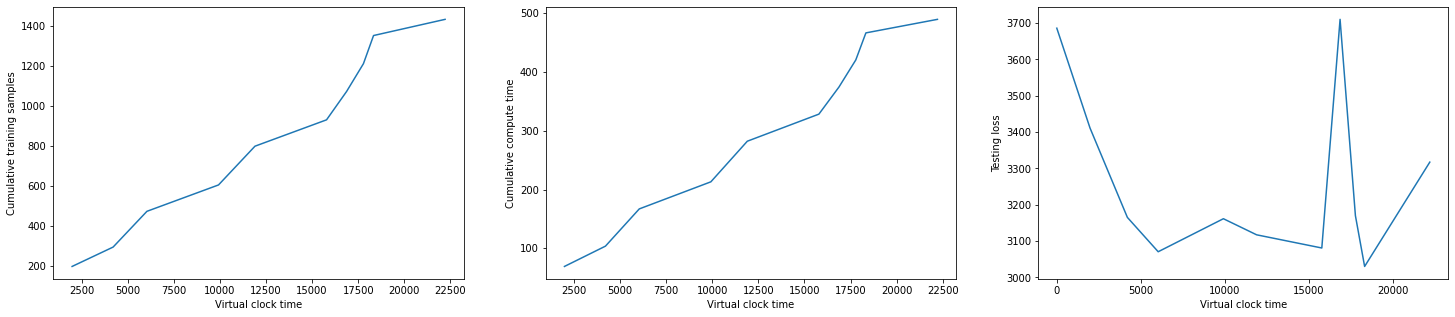

In [ ]:
fig,axs =  plt.subplots(1,3,figsize=(25,5))
axs[0].set_ylabel("Cumulative training samples")
axs[0].plot(p1_round_virtual_clocks[1:],np.cumsum(q9_p1_training_samples_per_round))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(p1_round_virtual_clocks[1:],np.cumsum(q9_p1_compute_units))
axs[2].set_ylabel("Testing loss")
axs[2].plot(p1_round_virtual_clocks,q9_p1_losses)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()

##### 2) Map clients with MOST computation ability (i.e lowest value for computation latency) to LARGEST datasets
- Plot sum of samples included, sum of compute units and reported loss against virtual time

##### Generate Data

In [ ]:
#@title create new generator that leads to desired mapping 
%%capture
# Work out the current mapping from id to amount of data
client_to_num_sample: List[Tuple[int, int]] = [
    (i, q9_flower_client_with_traces_generator(i).get_train_set_size())
    for i in range(num_total_clients)
]
# Order by increasing amounts of data
client_to_num_sample.sort(key=lambda p: p[1])

# Give generator device capacities in increasing order of computation latency
# AND mapping function for decreasing amounts of data
# Note: ordering of client_traces meaningless as not correlated with device capacities
# so fine to use random ordering (is same as part 1)

decreasing_sorted_client_cids = [cid for cid in reversed(increasing_sorted_client_cids)]
q9_p2_client_generator: Callable[
    [int], FlowerRayClientTraces
] = q9_get_flower_client_with_traces_generator(
    clients_device_capacity=sampled_cdc.sort_values("computation",ascending=True).to_dict('records'), # type: ignore
    clients_traces=sampled_cbt.to_dict('records'), # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition,
    mapping_fn = lambda compute_idx: decreasing_sorted_client_cids[compute_idx]) # type: ignore

In [ ]:
#@title test ordering and mapping

print("Checking ordering works")
print(client_to_num_sample[:2], decreasing_sorted_client_cids[:2])
print(client_to_num_sample[-2:], decreasing_sorted_client_cids[-2:])
print("Checking mapping works")
print(
    q9_p2_client_generator(0).properties["device_capacity"]["computation"],
    q9_p2_client_generator(0).get_train_set_size()
)
print(
    q9_p2_client_generator(1).properties["device_capacity"]["computation"],
    q9_p2_client_generator(1).get_train_set_size()
)
print(
    q9_p2_client_generator(num_total_clients-2).properties["device_capacity"]["computation"],
    q9_p2_client_generator(num_total_clients-2).get_train_set_size()
)
print(
    q9_p2_client_generator(num_total_clients-1).properties["device_capacity"]["computation"],
    q9_p2_client_generator(num_total_clients-1).get_train_set_size()
)

Checking ordering works
[(1528, 16), (628, 19)] [178, 447]
[(447, 393), (178, 418)] [628, 1528]
Checking mapping works
Getting client with id 0
Getting client with id 0
15.0 418
Getting client with id 1
Getting client with id 1
15.0 393
Getting client with id 3227
Getting client with id 3227
199.0 19
Getting client with id 3228
Getting client with id 3228
199.0 16


In [ ]:
q9_p2_criterion = ComputationCriterion(16.0)
q9_p2_client_manager = CustomClientManager(criterion=q9_p2_criterion, seed=Seeds.DEFAULT)
q9_p2_server = Server(
    client_manager=q9_p2_client_manager,
    strategy=q9_strategy,
)

#@title run simulation with custom generator and server
#NOTE: need to use new server to reset virtual clock
q9_p2_hist = start_seeded_simulation(
    client_fn=q9_p2_client_generator,
    num_clients=q9_num_total_clients,
    client_resources=client_resources,
    server=q9_p1_server,
    config=ServerConfig(num_rounds=10),
    strategy=strategy,
)

WARNING flwr 2023-02-20 13:11:29,800 | app.py:187 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-02-20 13:11:29,803 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-02-20 13:11:33,316	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-20 13:11:35,412 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3988350566.0, 'memory': 7976701134.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3988350566.0, 'memory': 7976701134.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-02-20 13:11:35,422 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-20 13:11:35,431 | server.py:266 | Using initial paramet

(launch_and_get_properties pid=1951) Getting client with id 68
(launch_and_get_properties pid=1951) Getting client with id 46
(launch_and_get_properties pid=1951) Getting client with id 21


DEBUG flwr 2023-02-20 13:11:54,071 | server.py:215 | fit_round 1: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 1: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 42
(launch_and_get_properties pid=1951) Getting client with id 49
(launch_and_get_properties pid=1951) Getting client with id 69
(launch_and_get_properties pid=1951) Getting client with id 39
(launch_and_get_properties pid=1951) Getting client with id 25
Sampled the following clients:  ['68', '69', '13']
(launch_and_get_properties pid=1951) Getting client with id 44
(launch_and_get_properties pid=1951) Getting client with id 13


DEBUG flwr 2023-02-20 13:11:54,377 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=1951, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-16-a218b4825aa9>", line 79, in fit
Exception: Client 509 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=1951, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return 

(launch_and_fit pid=1951) Getting client with id 69
(launch_and_fit pid=1951) Client 509 --- Current virtual clock time: 0.0
(launch_and_fit pid=1951) Client 509 --- Duration: 541.2541771019421
(launch_and_fit pid=1951) Client 509 --- Traces: {'duration': 541.2541771019421, 'inactive': [31, 564, 593, 612, 14867, 14873, 36306, 49904, 82431, 87033, 88719, 101318, 120936, 122616, 140016, 141323, 141344, 141591, 142126, 144025, 149948, 181453, 199201, 229581, 236167, 263493, 403929, 403938, 408496, 414499, 416994, 418178, 418188, 418219, 418246, 418259, 418346, 419057, 419098, 419118, 419145, 419168, 419187, 420512, 423519, 423530, 494391, 501041, 512686, 513170, 513195, 513218, 517127, 517351, 517371, 517384, 517515, 517597, 517661, 517721, 517735], 'finish_time': 518400, 'active': [0, 544, 575, 595, 627, 14871, 33202, 44430, 81673, 85975, 88446, 92910, 120915, 120942, 122617, 140016, 141332, 141570, 141693, 144014, 149938, 173867, 199190, 207442, 229581, 262127, 401958, 403930, 405089, 4

  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1952) Getting client with id 13
(launch_and_fit pid=1952) Client 121 --- Current virtual clock time: 0.0
(launch_and_fit pid=1952) Client 121 --- Duration: 161.50873941769325
(launch_and_fit pid=1952) Client 121 --- Traces: {'duration': 161.50873941769325, 'inactive': [2201, 2716, 30758, 31118, 33875, 38485, 72527, 80240, 104508, 109590, 109639, 110042, 123096, 139116, 139153, 139155, 158649, 185879, 186998, 187018, 195262, 196909, 197163, 198595, 199762, 245461, 275198, 285671, 289456, 306098, 306696, 306717, 306988, 332339, 423639], 'finish_time': 432000, 'active': [0, 2201, 17237, 30773, 33745, 37133, 38485, 72529, 102313, 109566, 109590, 109640, 110740, 138471, 139134, 139154, 139806, 184133, 186836, 187001, 187029, 196286, 196925, 197163, 198595, 226218, 274138, 277968, 285675, 305745, 306099, 306699, 306725, 306989, 375647], 'model': 'SM-J600GT'}
(launch_and_fit pid=1952) Client 121 --- Predicted completion: 161
(launch_and_fit pid=1952) Client 121 --- isActiv

 88%|████████▊ | 7/8 [00:04<00:00,  1.83it/s]
DEBUG flwr 2023-02-20 13:12:03,164 | server.py:229 | fit_round 1 received 2 results and 1 failures
DEBUG:flwr:fit_round 1 received 2 results and 1 failures
INFO flwr 2023-02-20 13:12:03,170 | strategy.py:186 | Completion times of clients: [1102.5665517494815, 161.50873941769325]
INFO:flwr:Completion times of clients: [1102.5665517494815, 161.50873941769325]
INFO flwr 2023-02-20 13:12:03,172 | strategy.py:188 | Maximum completion time of clients: 1102.5665517494815
INFO:flwr:Maximum completion time of clients: 1102.5665517494815
100%|██████████| 891/891 [00:08<00:00, 99.48it/s]
INFO flwr 2023-02-20 13:12:12,154 | server.py:116 | fit progress: (1, 3472.840443134308, {'accuracy': 0.0051560855840056125}, 21.023440417000018)
INFO:flwr:fit progress: (1, 3472.840443134308, {'accuracy': 0.0051560855840056125}, 21.023440417000018)
INFO flwr 2023-02-20 13:12:12,157 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe

(launch_and_get_properties pid=1952) Getting client with id 68
(launch_and_get_properties pid=1952) Getting client with id 46
(launch_and_get_properties pid=1952) Getting client with id 21
(launch_and_get_properties pid=1952) Getting client with id 42
(launch_and_get_properties pid=1952) Getting client with id 49
Sampled the following clients:  ['68', '69']


 50%|█████     | 1/2 [00:00<00:00,  7.66it/s]
DEBUG flwr 2023-02-20 13:12:12,721 | server.py:179 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
INFO flwr 2023-02-20 13:12:12,728 | strategy.py:186 | Completion times of clients: [412.37417710194205, 972.9665517494815]
INFO:flwr:Completion times of clients: [412.37417710194205, 972.9665517494815]
INFO flwr 2023-02-20 13:12:12,731 | strategy.py:188 | Maximum completion time of clients: 972.9665517494815
INFO:flwr:Maximum completion time of clients: 972.9665517494815
INFO flwr 2023-02-20 13:12:12,733 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_evaluate pid=1951) Getting client with id 68
(launch_and_evaluate pid=1951) Client 146 --- Current virtual clock time: 1102.5665517494815
(launch_and_evaluate pid=1951) Client 146 --- Duration: 972.9665517494815
(launch_and_evaluate pid=1951) Client 146 --- Traces: {'duration': 972.9665517494815, 'inactive': [22374, 50372, 53968, 74487, 78696, 80704, 102883, 115515, 115700, 115817, 115880, 115904, 115998, 116180, 116339, 116533, 116572, 116579, 116648, 116712, 116750, 116874, 117052, 117105, 117376, 122479, 122517, 122567, 122723, 140789, 148967, 162800, 201525, 201707, 203638, 203745, 203761, 203890, 213997, 214487, 235556, 243136, 282945, 330048, 330063, 330510, 337984, 376917, 388965, 409362, 420610, 457878, 506101], 'finish_time': 518400, 'active': [0, 48573, 50374, 72598, 77951, 78707, 86004, 115513, 115681, 115700, 115818, 115883, 115982, 116002, 116282, 116490, 116539, 116572, 116599, 116648, 116739, 116852, 116882, 117104, 117130, 122441, 122497, 122517, 122687, 137

100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


(launch_and_get_properties pid=1951) Getting client with id 65
(launch_and_get_properties pid=1951) Getting client with id 41
(launch_and_get_properties pid=1951) Getting client with id 21
(launch_and_get_properties pid=1951) Getting client with id 46
(launch_and_get_properties pid=1951) Getting client with id 31
(launch_and_get_properties pid=1951) Getting client with id 39
(launch_and_get_properties pid=1951) Getting client with id 66
(launch_and_get_properties pid=1951) Getting client with id 25
(launch_and_get_properties pid=1951) Getting client with id 55
(launch_and_get_properties pid=1951) Getting client with id 11
(launch_and_get_properties pid=1951) Getting client with id 62
(launch_and_get_properties pid=1951) Getting client with id 37
(launch_and_get_properties pid=1951) Getting client with id 12


DEBUG flwr 2023-02-20 13:12:13,739 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 20
(launch_and_get_properties pid=1951) Getting client with id 61
(launch_and_get_properties pid=1951) Getting client with id 1
(launch_and_get_properties pid=1951) Getting client with id 22
(launch_and_get_properties pid=1951) Getting client with id 33
Sampled the following clients:  ['65', '25', '58']


DEBUG flwr 2023-02-20 13:12:13,975 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-16-a218b4825aa9>", line 79, in fit
Exception: Client 282 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return 

(launch_and_get_properties pid=1951) Getting client with id 58


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1952) Getting client with id 25
(launch_and_fit pid=1952) Client 282 --- Current virtual clock time: 2075.533103498963
(launch_and_fit pid=1952) Client 282 --- Duration: 1931.8965021171323
(launch_and_fit pid=1952) Client 282 --- Traces: {'duration': 1931.8965021171323, 'inactive': [3804, 7971, 25527, 69535], 'finish_time': 86400, 'active': [318, 5878, 25399, 25754], 'model': 'SM-A510F'}
(launch_and_fit pid=1952) Client 282 --- Predicted completion: 4006
(launch_and_fit pid=1952) Client 282 --- isActive: False
(launch_and_fit pid=1951) Getting client with id 65
(launch_and_fit pid=1951) Client 294 --- Current virtual clock time: 2075.533103498963
(launch_and_fit pid=1951) Client 294 --- Duration: 531.2712961221505
(launch_and_fit pid=1951) Client 294 --- Traces: {'duration': 531.2712961221505, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=1951) Client 294 --- Predicted completion: 2606
(launch_and_f

 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]
DEBUG flwr 2023-02-20 13:12:20,468 | server.py:229 | fit_round 2 received 2 results and 1 failures
DEBUG:flwr:fit_round 2 received 2 results and 1 failures
INFO flwr 2023-02-20 13:12:20,474 | strategy.py:186 | Completion times of clients: [1008.6978249737421, 531.2712961221505]
INFO:flwr:Completion times of clients: [1008.6978249737421, 531.2712961221505]
INFO flwr 2023-02-20 13:12:20,479 | strategy.py:188 | Maximum completion time of clients: 1008.6978249737421
INFO:flwr:Maximum completion time of clients: 1008.6978249737421
100%|██████████| 891/891 [00:10<00:00, 85.29it/s]
INFO flwr 2023-02-20 13:12:30,963 | server.py:116 | fit progress: (2, 3381.056830406189, {'accuracy': 0.005647141353910909}, 39.83259759800001)
INFO:flwr:fit progress: (2, 3381.056830406189, {'accuracy': 0.005647141353910909}, 39.83259759800001)
INFO flwr 2023-02-20 13:12:30,968 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32

(launch_and_get_properties pid=1951) Getting client with id 65
(launch_and_get_properties pid=1951) Getting client with id 41
(launch_and_get_properties pid=1951) Getting client with id 21
(launch_and_get_properties pid=1951) Getting client with id 46
(launch_and_get_properties pid=1951) Getting client with id 31
(launch_and_get_properties pid=1951) Getting client with id 39


DEBUG flwr 2023-02-20 13:12:31,295 | server.py:165 | evaluate_round 2: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 70)
DEBUG flwr 2023-02-20 13:12:31,378 | ray_client_proxy.py:104 | ray::launch_and_evaluate() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 205, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 282, in _evaluate
    results = self.numpy_client.evaluate(parameters, ins.config)  # type: ignore
  File "<ipython-input-16-a218b4825aa9>", line 128, in evaluate
Exception: Client 282 is not active at the current time step
DEBUG:flwr:ray::launch_and_evaluate() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/d

Sampled the following clients:  ['65', '25']
(launch_and_get_properties pid=1951) Getting client with id 66
(launch_and_get_properties pid=1951) Getting client with id 25
(launch_and_evaluate pid=1951) Getting client with id 65
(launch_and_evaluate pid=1951) Client 294 --- Current virtual clock time: 3084.2309284727053
(launch_and_evaluate pid=1951) Client 294 --- Duration: 401.67129612215047
(launch_and_evaluate pid=1951) Client 294 --- Traces: {'duration': 401.67129612215047, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_evaluate pid=1951) Client 294 --- Predicted completion: 3485
(launch_and_evaluate pid=1951) Client 294 --- isActive: True
(launch_and_evaluate pid=1952) Getting client with id 25
(launch_and_evaluate pid=1952) Client 282 --- Current virtual clock time: 3084.2309284727053
(launch_and_evaluate pid=1952) Client 282 --- Duration: 1797.2565021171324
(launch_and_evaluate pid=1952) Client 282 --- Traces: {'duration

DEBUG flwr 2023-02-20 13:12:31,745 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 61
Sampled the following clients:  ['28', '59', '61']
(launch_and_fit pid=1951) Getting client with id 28
(launch_and_fit pid=1951) Client 225 --- Current virtual clock time: 3485.902224594856
(launch_and_fit pid=1951) Client 225 --- Duration: 1038.028279444181
(launch_and_fit pid=1951) Client 225 --- Traces: {'duration': 1038.028279444181, 'inactive': [1503, 1979, 2397, 2998, 3798, 4814, 5578, 5641, 6645, 17113, 18048, 18685, 20836, 23093, 23364, 24028, 28533, 39302, 40616, 81334, 81561, 83787, 84706, 85011, 87170, 87479, 94271, 94275, 94823, 98521, 109774, 115871, 122099, 186901, 206595, 212668, 212679, 214239, 214910, 218134, 218158, 223329, 242975, 302789, 308405, 350012, 355119, 356615, 366228, 381563], 'finish_time': 432000, 'active': [0, 1504, 1992, 2451, 3037, 3850, 4858, 5579, 5647, 16942, 17114, 18363, 18696, 22508, 23103, 23372, 24038, 38947, 39905, 81283, 81341, 81567, 83796, 84720, 85106, 87179, 93963, 94274, 9441

 88%|████████▊ | 7/8 [00:04<00:00,  1.45it/s]


(launch_and_fit pid=1951) Getting client with id 61
(launch_and_fit pid=1951) Client 493 --- Current virtual clock time: 3485.902224594856
(launch_and_fit pid=1951) Client 493 --- Duration: 216.32631166281186
(launch_and_fit pid=1951) Client 493 --- Traces: {'duration': 216.32631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459, 216490, 225143, 232465, 238697, 240911, 246162, 247946, 256406, 262675, 291030, 330289, 338197, 343158, 347137, 349231], 'model': 'Redmi No

 88%|████████▊ | 7/8 [00:02<00:00,  2.58it/s]
DEBUG flwr 2023-02-20 13:12:39,879 | server.py:229 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-02-20 13:12:39,885 | strategy.py:186 | Completion times of clients: [212.68640570494023, 1038.028279444181, 216.32631166281186]
INFO:flwr:Completion times of clients: [212.68640570494023, 1038.028279444181, 216.32631166281186]
100%|██████████| 8/8 [00:03<00:00,  2.54it/s]
INFO flwr 2023-02-20 13:12:39,891 | strategy.py:188 | Maximum completion time of clients: 1038.028279444181
INFO:flwr:Maximum completion time of clients: 1038.028279444181
100%|██████████| 891/891 [00:11<00:00, 78.73it/s]
INFO flwr 2023-02-20 13:12:51,250 | server.py:116 | fit progress: (3, 3480.9818835258484, {'accuracy': 0.005506839705366538}, 60.119905899)
INFO:flwr:fit progress: (3, 3480.9818835258484, {'accuracy': 0.005506839705366538}, 60.119905899)
INFO flwr 2023-02-20 13:12:51,257 | client_manager

(launch_and_get_properties pid=1951) Getting client with id 49
(launch_and_get_properties pid=1951) Getting client with id 11
(launch_and_get_properties pid=1951) Getting client with id 28
Sampled the following clients:  ['28', '59']


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:12:51,686 | server.py:179 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
INFO flwr 2023-02-20 13:12:51,692 | strategy.py:186 | Completion times of clients: [82.36640570494025, 904.108279444181]
INFO:flwr:Completion times of clients: [82.36640570494025, 904.108279444181]
INFO flwr 2023-02-20 13:12:51,694 | strategy.py:188 | Maximum completion time of clients: 904.108279444181
INFO:flwr:Maximum completion time of clients: 904.108279444181
INFO flwr 2023-02-20 13:12:51,697 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_get_properties pid=1951) Getting client with id 47
(launch_and_get_properties pid=1951) Getting client with id 43
(launch_and_get_properties pid=1951) Getting client with id 59
(launch_and_evaluate pid=1951) Getting client with id 59
(launch_and_evaluate pid=1951) Client 618 --- Current virtual clock time: 4523.930504039037
(launch_and_evaluate pid=1951) Client 618 --- Duration: 82.36640570494025
(launch_and_evaluate pid=1951) Client 618 --- Traces: {'duration': 82.36640570494025, 'inactive': [1953, 2613, 4362, 5880, 5898, 6348, 35108, 91683, 94112, 94425, 119836, 152387, 171820, 173157, 195457, 205897, 205924, 219513, 238882, 258495, 260143, 265246, 266104, 273172, 276273, 293829, 328288, 328316, 328403, 328738, 333673, 341111, 343721, 345965, 350689, 350691, 351236, 352667, 366902, 380020, 380022], 'finish_time': 518400, 'active': [1760, 2173, 2615, 4410, 5881, 5898, 9160, 90606, 91825, 94113, 94426, 148477, 166337, 172079, 179520, 205886, 205913, 205930, 236845, 253567, 

100%|██████████| 2/2 [00:00<00:00, 21.18it/s]


(launch_and_get_properties pid=1951) Getting client with id 8
(launch_and_get_properties pid=1951) Getting client with id 5
(launch_and_get_properties pid=1951) Getting client with id 58
(launch_and_get_properties pid=1951) Getting client with id 7
(launch_and_get_properties pid=1951) Getting client with id 65
(launch_and_get_properties pid=1951) Getting client with id 1
(launch_and_get_properties pid=1951) Getting client with id 34


DEBUG flwr 2023-02-20 13:12:52,109 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 70)


Sampled the following clients:  ['5', '65', '28']
(launch_and_get_properties pid=1951) Getting client with id 23
(launch_and_get_properties pid=1951) Getting client with id 20
(launch_and_get_properties pid=1951) Getting client with id 28
(launch_and_fit pid=1951) Getting client with id 65
(launch_and_fit pid=1951) Client 294 --- Current virtual clock time: 5428.038783483218
(launch_and_fit pid=1951) Client 294 --- Duration: 531.2712961221505
(launch_and_fit pid=1951) Client 294 --- Traces: {'duration': 531.2712961221505, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=1951) Client 294 --- Predicted completion: 5959
(launch_and_fit pid=1951) Client 294 --- isActive: True
(launch_and_fit pid=1952) Getting client with id 5
(launch_and_fit pid=1952) Client 117 --- Current virtual clock time: 5428.038783483218
(launch_and_fit pid=1952) Client 117 --- Duration: 2075.8080183612196
(launch_and_fit pid=1952) Client 117 --- Trace

  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1952) Getting client with id 28
(launch_and_fit pid=1952) Client 225 --- Current virtual clock time: 5428.038783483218
(launch_and_fit pid=1952) Client 225 --- Duration: 1038.028279444181
(launch_and_fit pid=1952) Client 225 --- Traces: {'duration': 1038.028279444181, 'inactive': [1503, 1979, 2397, 2998, 3798, 4814, 5578, 5641, 6645, 17113, 18048, 18685, 20836, 23093, 23364, 24028, 28533, 39302, 40616, 81334, 81561, 83787, 84706, 85011, 87170, 87479, 94271, 94275, 94823, 98521, 109774, 115871, 122099, 186901, 206595, 212668, 212679, 214239, 214910, 218134, 218158, 223329, 242975, 302789, 308405, 350012, 355119, 356615, 366228, 381563], 'finish_time': 432000, 'active': [0, 1504, 1992, 2451, 3037, 3850, 4858, 5579, 5647, 16942, 17114, 18363, 18696, 22508, 23103, 23372, 24038, 38947, 39905, 81283, 81341, 81567, 83796, 84720, 85106, 87179, 93963, 94274, 94410, 94832, 106762, 113673, 121851, 185031, 203581, 211429, 212676, 213814, 214256, 217655, 218143, 218164, 223351, 

 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]
DEBUG flwr 2023-02-20 13:13:01,456 | server.py:229 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
INFO flwr 2023-02-20 13:13:01,464 | strategy.py:186 | Completion times of clients: [2075.8080183612196, 1038.028279444181, 531.2712961221505]
INFO:flwr:Completion times of clients: [2075.8080183612196, 1038.028279444181, 531.2712961221505]
100%|██████████| 8/8 [00:04<00:00,  1.97it/s]
INFO flwr 2023-02-20 13:13:01,474 | strategy.py:188 | Maximum completion time of clients: 2075.8080183612196
INFO:flwr:Maximum completion time of clients: 2075.8080183612196
100%|██████████| 891/891 [00:11<00:00, 79.91it/s] 
INFO flwr 2023-02-20 13:13:12,659 | server.py:116 | fit progress: (4, 3432.279261827469, {'accuracy': 0.009435285864608909}, 81.52891212200001)
INFO:flwr:fit progress: (4, 3432.279261827469, {'accuracy': 0.009435285864608909}, 81.52891212200001)
INFO flwr 2023-02-20 13:13:12,665 | clien

(launch_and_get_properties pid=1952) Getting client with id 8
(launch_and_get_properties pid=1952) Getting client with id 5
(launch_and_get_properties pid=1952) Getting client with id 58
(launch_and_get_properties pid=1952) Getting client with id 7
Sampled the following clients:  ['5', '65']


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]
DEBUG flwr 2023-02-20 13:13:13,136 | server.py:179 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
INFO flwr 2023-02-20 13:13:13,140 | strategy.py:186 | Completion times of clients: [401.67129612215047, 1936.8480183612198]
INFO:flwr:Completion times of clients: [401.67129612215047, 1936.8480183612198]
INFO flwr 2023-02-20 13:13:13,142 | strategy.py:188 | Maximum completion time of clients: 1936.8480183612198
INFO:flwr:Maximum completion time of clients: 1936.8480183612198
INFO flwr 2023-02-20 13:13:13,144 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_get_properties pid=1952) Getting client with id 65
(launch_and_evaluate pid=1952) Getting client with id 5
(launch_and_evaluate pid=1952) Client 117 --- Current virtual clock time: 7503.846801844438
(launch_and_evaluate pid=1952) Client 117 --- Duration: 1936.8480183612198
(launch_and_evaluate pid=1952) Client 117 --- Traces: {'duration': 1936.8480183612198, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_evaluate pid=1952) Client 117 --- Predicted completion: 9439
(launch_and_evaluate pid=1952) Client 117 --- isActive: True
(launch_and_evaluate pid=1951) Getting client with id 65
(launch_and_evaluate pid=1951) Client 294 --- Current virtual clock time: 7503.846801844438
(launch_and_evaluate pid=1951) Client 294 --- Duration: 401.

100%|██████████| 2/2 [00:00<00:00, 28.92it/s]


(launch_and_get_properties pid=1951) Getting client with id 63
(launch_and_get_properties pid=1951) Getting client with id 31
(launch_and_get_properties pid=1951) Getting client with id 0
(launch_and_get_properties pid=1951) Getting client with id 27
(launch_and_get_properties pid=1951) Getting client with id 54
(launch_and_get_properties pid=1951) Getting client with id 68
(launch_and_get_properties pid=1951) Getting client with id 12
(launch_and_get_properties pid=1951) Getting client with id 3
(launch_and_get_properties pid=1951) Getting client with id 23


DEBUG flwr 2023-02-20 13:13:13,793 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 49
(launch_and_get_properties pid=1951) Getting client with id 1
(launch_and_get_properties pid=1951) Getting client with id 44
(launch_and_get_properties pid=1951) Getting client with id 18
(launch_and_get_properties pid=1951) Getting client with id 19
(launch_and_get_properties pid=1951) Getting client with id 38
Sampled the following clients:  ['68', '18', '61']


DEBUG flwr 2023-02-20 13:13:13,867 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=1951, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "<ipython-input-16-a218b4825aa9>", line 79, in fit
Exception: Client 8 is not active at the current time step
DEBUG:flwr:ray::launch_and_fit() (pid=1951, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return cl

(launch_and_get_properties pid=1951) Getting client with id 61
(launch_and_fit pid=1951) Getting client with id 18
(launch_and_fit pid=1951) Client 8 --- Current virtual clock time: 9440.694820205657
(launch_and_fit pid=1951) Client 8 --- Duration: 1014.457824973742
(launch_and_fit pid=1951) Client 8 --- Traces: {'duration': 1014.457824973742, 'inactive': [9554, 17143, 24203, 33600, 40729, 53934, 55687, 86370], 'finish_time': 86400, 'active': [7949, 14518, 23368, 27632, 38218, 46780, 55248, 84719], 'model': 'Twist (2018)'}
(launch_and_fit pid=1951) Client 8 --- Predicted completion: 10454
(launch_and_fit pid=1951) Client 8 --- isActive: False
(launch_and_fit pid=1951) Getting client with id 61
(launch_and_fit pid=1951) Client 493 --- Current virtual clock time: 9440.694820205657
(launch_and_fit pid=1951) Client 493 --- Duration: 216.32631166281186
(launch_and_fit pid=1951) Client 493 --- Traces: {'duration': 216.32631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 317

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]
DEBUG flwr 2023-02-20 13:13:17,838 | server.py:229 | fit_round 5 received 2 results and 1 failures
DEBUG:flwr:fit_round 5 received 2 results and 1 failures
INFO flwr 2023-02-20 13:13:17,841 | strategy.py:186 | Completion times of clients: [1102.5665517494815, 216.32631166281186]
INFO:flwr:Completion times of clients: [1102.5665517494815, 216.32631166281186]
INFO flwr 2023-02-20 13:13:17,843 | strategy.py:188 | Maximum completion time of clients: 1102.5665517494815
INFO:flwr:Maximum completion time of clients: 1102.5665517494815
100%|██████████| 891/891 [00:13<00:00, 65.92it/s]
INFO flwr 2023-02-20 13:13:31,384 | server.py:116 | fit progress: (5, 3533.9088830947876, {'accuracy': 0.005506839705366538}, 100.25401564600003)
INFO:flwr:fit progress: (5, 3533.9088830947876, {'accuracy': 0.005506839705366538}, 100.25401564600003)
INFO flwr 2023-02-20 13:13:31,391 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe

(launch_and_get_properties pid=1952) Getting client with id 63
(launch_and_get_properties pid=1952) Getting client with id 31
(launch_and_get_properties pid=1952) Getting client with id 0
(launch_and_get_properties pid=1952) Getting client with id 27
(launch_and_get_properties pid=1952) Getting client with id 54
(launch_and_get_properties pid=1952) Getting client with id 68
(launch_and_get_properties pid=1952) Getting client with id 12
(launch_and_get_properties pid=1952) Getting client with id 3
(launch_and_get_properties pid=1952) Getting client with id 23
(launch_and_get_properties pid=1952) Getting client with id 49


DEBUG flwr 2023-02-20 13:13:32,009 | server.py:165 | evaluate_round 5: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 70)


(launch_and_get_properties pid=1952) Getting client with id 1
(launch_and_get_properties pid=1952) Getting client with id 44
(launch_and_get_properties pid=1952) Getting client with id 18
Sampled the following clients:  ['68', '61']
(launch_and_get_properties pid=1952) Getting client with id 19
(launch_and_get_properties pid=1952) Getting client with id 38
(launch_and_get_properties pid=1952) Getting client with id 61


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:13:32,229 | server.py:179 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
INFO flwr 2023-02-20 13:13:32,233 | strategy.py:186 | Completion times of clients: [972.9665517494815, 86.00631166281185]
INFO:flwr:Completion times of clients: [972.9665517494815, 86.00631166281185]
INFO flwr 2023-02-20 13:13:32,234 | strategy.py:188 | Maximum completion time of clients: 972.9665517494815
INFO:flwr:Maximum completion time of clients: 972.9665517494815
INFO flwr 2023-02-20 13:13:32,241 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
100%|██████████| 2/2 [00:00<00:00, 24.63it/s]
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_evaluate pid=1951) Getting client with id 61
(launch_and_evaluate pid=1951) Client 493 --- Current virtual clock time: 10543.26137195514
(launch_and_evaluate pid=1951) Client 493 --- Duration: 86.00631166281185
(launch_and_evaluate pid=1951) Client 493 --- Traces: {'duration': 86.00631166281185, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459, 216490, 225143, 232465, 238697, 240911, 246162, 247946, 256406, 262675, 291030, 330289, 338197, 343158, 347137, 349231], 

100%|██████████| 2/2 [00:00<00:00, 39.02it/s]


(launch_and_get_properties pid=1952) Getting client with id 58
(launch_and_get_properties pid=1952) Getting client with id 31
(launch_and_get_properties pid=1952) Getting client with id 47
(launch_and_get_properties pid=1952) Getting client with id 51
(launch_and_get_properties pid=1952) Getting client with id 37
(launch_and_get_properties pid=1952) Getting client with id 32
(launch_and_get_properties pid=1952) Getting client with id 5
(launch_and_get_properties pid=1952) Getting client with id 54
(launch_and_get_properties pid=1952) Getting client with id 46
(launch_and_get_properties pid=1952) Getting client with id 40
(launch_and_get_properties pid=1952) Getting client with id 26
(launch_and_get_properties pid=1952) Getting client with id 60
(launch_and_get_properties pid=1952) Getting client with id 28
(launch_and_get_properties pid=1952) Getting client with id 42


DEBUG flwr 2023-02-20 13:13:33,103 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1952) Getting client with id 56
(launch_and_get_properties pid=1952) Getting client with id 62
(launch_and_get_properties pid=1952) Getting client with id 8
(launch_and_get_properties pid=1952) Getting client with id 20
(launch_and_get_properties pid=1952) Getting client with id 52
(launch_and_get_properties pid=1952) Getting client with id 67
Sampled the following clients:  ['37', '5', '65']


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1951) Getting client with id 5
(launch_and_fit pid=1951) Client 117 --- Current virtual clock time: 11516.22792370462
(launch_and_fit pid=1951) Client 117 --- Duration: 2075.8080183612196
(launch_and_fit pid=1951) Client 117 --- Traces: {'duration': 2075.8080183612196, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_fit pid=1951) Client 117 --- Predicted completion: 13591
(launch_and_fit pid=1951) Client 117 --- isActive: True
(launch_and_get_properties pid=1952) Getting client with id 65
(launch_and_fit pid=1952) Getting client with id 37
(launch_and_fit pid=1952) Client 482 --- Current virtual clock time: 11516.22792370462
(launch_and_fit pid=1952) Client 482 --- Duration: 638.1249531626647
(launch_and_fit pid=1952) Clie

 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]


(launch_and_fit pid=1951) Getting client with id 65
(launch_and_fit pid=1951) Client 294 --- Current virtual clock time: 11516.22792370462
(launch_and_fit pid=1951) Client 294 --- Duration: 531.2712961221505
(launch_and_fit pid=1951) Client 294 --- Traces: {'duration': 531.2712961221505, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=1951) Client 294 --- Predicted completion: 12047
(launch_and_fit pid=1951) Client 294 --- isActive: True


 88%|████████▊ | 7/8 [00:01<00:00,  4.45it/s]
DEBUG flwr 2023-02-20 13:13:38,747 | server.py:229 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures
INFO flwr 2023-02-20 13:13:38,750 | strategy.py:186 | Completion times of clients: [531.2712961221505, 638.1249531626647, 2075.8080183612196]
INFO:flwr:Completion times of clients: [531.2712961221505, 638.1249531626647, 2075.8080183612196]
INFO flwr 2023-02-20 13:13:38,756 | strategy.py:188 | Maximum completion time of clients: 2075.8080183612196
INFO:flwr:Maximum completion time of clients: 2075.8080183612196
100%|██████████| 891/891 [00:13<00:00, 63.97it/s] 
INFO flwr 2023-02-20 13:13:52,717 | server.py:116 | fit progress: (6, 3437.2635674476624, {'accuracy': 0.005647141353910909}, 121.586245916)
INFO:flwr:fit progress: (6, 3437.2635674476624, {'accuracy': 0.005647141353910909}, 121.586245916)
INFO flwr 2023-02-20 13:13:52,722 | client_manager.py:49 | Sampling using <__main__.Computati

(launch_and_get_properties pid=1951) Getting client with id 58
(launch_and_get_properties pid=1951) Getting client with id 31
(launch_and_get_properties pid=1951) Getting client with id 47
(launch_and_get_properties pid=1951) Getting client with id 51
(launch_and_get_properties pid=1951) Getting client with id 37
(launch_and_get_properties pid=1951) Getting client with id 32
(launch_and_get_properties pid=1951) Getting client with id 5
(launch_and_get_properties pid=1951) Getting client with id 54
(launch_and_get_properties pid=1951) Getting client with id 46


DEBUG flwr 2023-02-20 13:13:53,367 | server.py:165 | evaluate_round 6: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 70)
DEBUG flwr 2023-02-20 13:13:53,439 | ray_client_proxy.py:104 | ray::launch_and_evaluate() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/client.py", line 205, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)
  File "/usr/local/lib/python3.8/dist-packages/flwr/client/app.py", line 282, in _evaluate
    results = self.numpy_client.evaluate(parameters, ins.config)  # type: ignore
  File "<ipython-input-16-a218b4825aa9>", line 128, in evaluate
Exception: Client 333 is not active at the current time step
DEBUG:flwr:ray::launch_and_evaluate() (pid=1952, ip=172.28.0.12)
  File "/usr/local/lib/python3.8/d

(launch_and_get_properties pid=1951) Getting client with id 40
(launch_and_get_properties pid=1951) Getting client with id 26
(launch_and_get_properties pid=1951) Getting client with id 60
(launch_and_get_properties pid=1951) Getting client with id 28
(launch_and_get_properties pid=1951) Getting client with id 42
Sampled the following clients:  ['5', '56']


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:13:53,515 | server.py:179 | evaluate_round 6 received 1 results and 1 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 1 failures
INFO flwr 2023-02-20 13:13:53,517 | strategy.py:186 | Completion times of clients: [1936.8480183612198]
INFO:flwr:Completion times of clients: [1936.8480183612198]
INFO flwr 2023-02-20 13:13:53,530 | strategy.py:188 | Maximum completion time of clients: 1936.8480183612198
INFO:flwr:Maximum completion time of clients: 1936.8480183612198
INFO flwr 2023-02-20 13:13:53,536 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
100%|██████████| 2/2 [00:00<00:00, 26.92it/s]


(launch_and_get_properties pid=1951) Getting client with id 56
(launch_and_evaluate pid=1951) Getting client with id 5
(launch_and_evaluate pid=1951) Client 117 --- Current virtual clock time: 13592.03594206584
(launch_and_evaluate pid=1951) Client 117 --- Duration: 1936.8480183612198
(launch_and_evaluate pid=1951) Client 117 --- Traces: {'duration': 1936.8480183612198, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_evaluate pid=1951) Client 117 --- Predicted completion: 15528
(launch_and_evaluate pid=1951) Client 117 --- isActive: True
(launch_and_evaluate pid=1952) Getting client with id 56
(launch_and_evaluate pid=1952) Client 333 --- Current virtual clock time: 13592.03594206584
(launch_and_evaluate pid=1952) Client 333 --- Duration: 709

DEBUG flwr 2023-02-20 13:13:54,233 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 45
Sampled the following clients:  ['15', '59', '68']
(launch_and_get_properties pid=1951) Getting client with id 8
(launch_and_get_properties pid=1951) Getting client with id 68


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1951) Getting client with id 15
(launch_and_fit pid=1951) Client 546 --- Current virtual clock time: 15528.88396042706
(launch_and_fit pid=1951) Client 546 --- Duration: 172.2141058686726
(launch_and_fit pid=1951) Client 546 --- Traces: {'duration': 172.2141058686726, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_fit pid=1951) Client 546 --- Predicted completion: 15700
(launch_and_fit pid=1951) Client 546 --- isActive: True
(launch_and_fit pid=1952) Getting client with id 59
(launch_and_fit pid=1952) Client 618 --- Current virtual clock time: 15528.88396042706
(launch_and_fit pid=1952) Client 618 --- Duration: 212.68640570494023
(launch_and_fit pid=1952) Client 618 --- Traces: {'duration': 212.68640570494023, 'inactive': [1953, 2613, 4362, 5880, 5898, 6348, 35108, 91683,

  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1952) Getting client with id 68
(launch_and_fit pid=1952) Client 146 --- Current virtual clock time: 15528.88396042706
(launch_and_fit pid=1952) Client 146 --- Duration: 1102.5665517494815
(launch_and_fit pid=1952) Client 146 --- Traces: {'duration': 1102.5665517494815, 'inactive': [22374, 50372, 53968, 74487, 78696, 80704, 102883, 115515, 115700, 115817, 115880, 115904, 115998, 116180, 116339, 116533, 116572, 116579, 116648, 116712, 116750, 116874, 117052, 117105, 117376, 122479, 122517, 122567, 122723, 140789, 148967, 162800, 201525, 201707, 203638, 203745, 203761, 203890, 213997, 214487, 235556, 243136, 282945, 330048, 330063, 330510, 337984, 376917, 388965, 409362, 420610, 457878, 506101], 'finish_time': 518400, 'active': [0, 48573, 50374, 72598, 77951, 78707, 86004, 115513, 115681, 115700, 115818, 115883, 115982, 116002, 116282, 116490, 116539, 116572, 116599, 116648, 116739, 116852, 116882, 117104, 117130, 122441, 122497, 122517, 122687, 137855, 148230, 155272

 88%|████████▊ | 7/8 [00:01<00:00,  4.40it/s]
DEBUG flwr 2023-02-20 13:13:59,725 | server.py:229 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures
INFO flwr 2023-02-20 13:13:59,728 | strategy.py:186 | Completion times of clients: [212.68640570494023, 172.2141058686726, 1102.5665517494815]
INFO:flwr:Completion times of clients: [212.68640570494023, 172.2141058686726, 1102.5665517494815]
INFO flwr 2023-02-20 13:13:59,731 | strategy.py:188 | Maximum completion time of clients: 1102.5665517494815
INFO:flwr:Maximum completion time of clients: 1102.5665517494815
100%|██████████| 891/891 [00:14<00:00, 62.83it/s]
INFO flwr 2023-02-20 13:14:13,938 | server.py:116 | fit progress: (7, 3449.236010789871, {'accuracy': 0.005506839705366538}, 142.80764600000003)
INFO:flwr:fit progress: (7, 3449.236010789871, {'accuracy': 0.005506839705366538}, 142.80764600000003)
INFO flwr 2023-02-20 13:14:13,953 | client_manager.py:49 | Sampling using <__main__.

(launch_and_get_properties pid=1952) Getting client with id 15
(launch_and_get_properties pid=1952) Getting client with id 43
(launch_and_get_properties pid=1952) Getting client with id 69
Sampled the following clients:  ['15', '59']
(launch_and_get_properties pid=1952) Getting client with id 59


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:14:14,354 | server.py:179 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
INFO flwr 2023-02-20 13:14:14,360 | strategy.py:186 | Completion times of clients: [82.36640570494025, 36.134105868672584]
INFO:flwr:Completion times of clients: [82.36640570494025, 36.134105868672584]
INFO flwr 2023-02-20 13:14:14,365 | strategy.py:188 | Maximum completion time of clients: 82.36640570494025
INFO:flwr:Maximum completion time of clients: 82.36640570494025
INFO flwr 2023-02-20 13:14:14,371 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_evaluate pid=1951) Getting client with id 15
(launch_and_evaluate pid=1951) Client 546 --- Current virtual clock time: 16631.45051217654
(launch_and_evaluate pid=1951) Client 546 --- Duration: 36.134105868672584
(launch_and_evaluate pid=1951) Client 546 --- Traces: {'duration': 36.134105868672584, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_evaluate pid=1951) Client 546 --- Predicted completion: 16667
(launch_and_evaluate pid=1951) Client 546 --- isActive: True
(launch_and_evaluate pid=1952) Getting client with id 59
(launch_and_evaluate pid=1952) Client 618 --- Current virtual clock time: 16631.45051217654
(launch_and_evaluate pid=1952) Client 618 --- Duration: 82.36640570494025
(launch_and_evaluate pid=1952) Client 618 --- Traces: {'duration': 82.36640570494025, 'inactive': 

100%|██████████| 2/2 [00:00<00:00, 19.34it/s]


(launch_and_get_properties pid=1951) Getting client with id 63
(launch_and_get_properties pid=1951) Getting client with id 57
(launch_and_get_properties pid=1951) Getting client with id 2
(launch_and_get_properties pid=1951) Getting client with id 20


DEBUG flwr 2023-02-20 13:14:14,765 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 67
(launch_and_get_properties pid=1951) Getting client with id 22
(launch_and_get_properties pid=1951) Getting client with id 7
(launch_and_get_properties pid=1951) Getting client with id 9
Sampled the following clients:  ['67', '9', '15']
(launch_and_get_properties pid=1951) Getting client with id 15
(launch_and_fit pid=1952) Getting client with id 9
(launch_and_fit pid=1952) Client 28 --- Current virtual clock time: 16713.81691788148
(launch_and_fit pid=1952) Client 28 --- Duration: 587.2590377296483
(launch_and_fit pid=1952) Client 28 --- Traces: {'duration': 587.2590377296483, 'inactive': [31111, 118085, 214122, 242680, 243879, 294436, 294442, 378194], 'finish_time': 432000, 'active': [2637, 88322, 180514, 240987, 242699, 265577, 294436, 347159], 'model': 'vivo 1816'}
(launch_and_fit pid=1952) Client 28 --- Predicted completion: 17300
(launch_and_fit pid=1952) Client 28 --- isActive: True
(launch_and_fit pid=1951) Getting 

 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]


(launch_and_fit pid=1951) Getting client with id 15
(launch_and_fit pid=1951) Client 546 --- Current virtual clock time: 16713.81691788148
(launch_and_fit pid=1951) Client 546 --- Duration: 172.2141058686726
(launch_and_fit pid=1951) Client 546 --- Traces: {'duration': 172.2141058686726, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_fit pid=1951) Client 546 --- Predicted completion: 16885
(launch_and_fit pid=1951) Client 546 --- isActive: True


 88%|████████▊ | 7/8 [00:01<00:00,  4.26it/s]
DEBUG flwr 2023-02-20 13:14:20,389 | server.py:229 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures
INFO flwr 2023-02-20 13:14:20,394 | strategy.py:186 | Completion times of clients: [587.2590377296483, 172.2141058686726, 148.47144461456492]
INFO:flwr:Completion times of clients: [587.2590377296483, 172.2141058686726, 148.47144461456492]
INFO flwr 2023-02-20 13:14:20,398 | strategy.py:188 | Maximum completion time of clients: 587.2590377296483
INFO:flwr:Maximum completion time of clients: 587.2590377296483
100%|██████████| 891/891 [00:13<00:00, 64.41it/s]
INFO flwr 2023-02-20 13:14:34,264 | server.py:116 | fit progress: (8, 3463.8566086292267, {'accuracy': 0.005506839705366538}, 163.13351225900004)
INFO:flwr:fit progress: (8, 3463.8566086292267, {'accuracy': 0.005506839705366538}, 163.13351225900004)
INFO flwr 2023-02-20 13:14:34,267 | client_manager.py:49 | Sampling using <__main__.Co

(launch_and_get_properties pid=1951) Getting client with id 60
(launch_and_get_properties pid=1951) Getting client with id 63
(launch_and_get_properties pid=1951) Getting client with id 57
(launch_and_get_properties pid=1951) Getting client with id 2


DEBUG flwr 2023-02-20 13:14:34,668 | server.py:165 | evaluate_round 8: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 20
(launch_and_get_properties pid=1951) Getting client with id 67
(launch_and_get_properties pid=1951) Getting client with id 22
(launch_and_get_properties pid=1951) Getting client with id 7
(launch_and_get_properties pid=1951) Getting client with id 9
Sampled the following clients:  ['67', '9']


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:14:34,865 | server.py:179 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
INFO flwr 2023-02-20 13:14:34,868 | strategy.py:186 | Completion times of clients: [450.45903772964834, 18.871444614564922]
INFO:flwr:Completion times of clients: [450.45903772964834, 18.871444614564922]
100%|██████████| 2/2 [00:00<00:00, 18.39it/s]
INFO flwr 2023-02-20 13:14:34,876 | strategy.py:188 | Maximum completion time of clients: 450.45903772964834
INFO:flwr:Maximum completion time of clients: 450.45903772964834
INFO flwr 2023-02-20 13:14:34,880 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
100%|██████████| 2/2 [00:00<00:00, 18.08it/s]
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>


(launch_and_evaluate pid=1951) Getting client with id 67
(launch_and_evaluate pid=1951) Client 242 --- Current virtual clock time: 17301.075955611126
(launch_and_evaluate pid=1951) Client 242 --- Duration: 18.871444614564922
(launch_and_evaluate pid=1951) Client 242 --- Traces: {'duration': 18.871444614564922, 'inactive': [18711, 19368, 20441, 20604, 25523, 67844, 76179, 77212, 83346], 'finish_time': 86400, 'active': [16613, 18722, 20382, 20496, 21614, 49049, 67866, 76257, 81739], 'model': 'SM-G610M'}
(launch_and_evaluate pid=1951) Client 242 --- Predicted completion: 17319
(launch_and_evaluate pid=1951) Client 242 --- isActive: True
(launch_and_evaluate pid=1952) Getting client with id 9
(launch_and_evaluate pid=1952) Client 28 --- Current virtual clock time: 17301.075955611126
(launch_and_evaluate pid=1952) Client 28 --- Duration: 450.45903772964834
(launch_and_evaluate pid=1952) Client 28 --- Traces: {'duration': 450.45903772964834, 'inactive': [31111, 118085, 214122, 242680, 243879

DEBUG flwr 2023-02-20 13:14:35,467 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1952) Getting client with id 37
(launch_and_get_properties pid=1952) Getting client with id 13
(launch_and_get_properties pid=1952) Getting client with id 57
Sampled the following clients:  ['61', '13', '9']
(launch_and_get_properties pid=1952) Getting client with id 9


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1951) Getting client with id 9
(launch_and_fit pid=1951) Client 28 --- Current virtual clock time: 17751.534993340774
(launch_and_fit pid=1951) Client 28 --- Duration: 587.2590377296483
(launch_and_fit pid=1951) Client 28 --- Traces: {'duration': 587.2590377296483, 'inactive': [31111, 118085, 214122, 242680, 243879, 294436, 294442, 378194], 'finish_time': 432000, 'active': [2637, 88322, 180514, 240987, 242699, 265577, 294436, 347159], 'model': 'vivo 1816'}
(launch_and_fit pid=1951) Client 28 --- Predicted completion: 18338
(launch_and_fit pid=1951) Client 28 --- isActive: True
(launch_and_fit pid=1952) Getting client with id 61
(launch_and_fit pid=1952) Client 493 --- Current virtual clock time: 17751.534993340774
(launch_and_fit pid=1952) Client 493 --- Duration: 216.32631166281186
(launch_and_fit pid=1952) Client 493 --- Traces: {'duration': 216.32631166281186, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 

 88%|████████▊ | 7/8 [00:03<00:00,  2.30it/s]


(launch_and_fit pid=1951) Getting client with id 13
(launch_and_fit pid=1951) Client 121 --- Current virtual clock time: 17751.534993340774
(launch_and_fit pid=1951) Client 121 --- Duration: 161.50873941769325
(launch_and_fit pid=1951) Client 121 --- Traces: {'duration': 161.50873941769325, 'inactive': [2201, 2716, 30758, 31118, 33875, 38485, 72527, 80240, 104508, 109590, 109639, 110042, 123096, 139116, 139153, 139155, 158649, 185879, 186998, 187018, 195262, 196909, 197163, 198595, 199762, 245461, 275198, 285671, 289456, 306098, 306696, 306717, 306988, 332339, 423639], 'finish_time': 432000, 'active': [0, 2201, 17237, 30773, 33745, 37133, 38485, 72529, 102313, 109566, 109590, 109640, 110740, 138471, 139134, 139154, 139806, 184133, 186836, 187001, 187029, 196286, 196925, 197163, 198595, 226218, 274138, 277968, 285675, 305745, 306099, 306699, 306725, 306989, 375647], 'model': 'SM-J600GT'}
(launch_and_fit pid=1951) Client 121 --- Predicted completion: 17912
(launch_and_fit pid=1951) Clien

 88%|████████▊ | 7/8 [00:01<00:00,  4.05it/s]
DEBUG flwr 2023-02-20 13:14:40,999 | server.py:229 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures
INFO flwr 2023-02-20 13:14:41,009 | strategy.py:186 | Completion times of clients: [216.32631166281186, 161.50873941769325, 587.2590377296483]
100%|██████████| 8/8 [00:01<00:00,  4.07it/s]
INFO:flwr:Completion times of clients: [216.32631166281186, 161.50873941769325, 587.2590377296483]
INFO flwr 2023-02-20 13:14:41,017 | strategy.py:188 | Maximum completion time of clients: 587.2590377296483
INFO:flwr:Maximum completion time of clients: 587.2590377296483
100%|██████████| 891/891 [00:13<00:00, 67.36it/s]
INFO flwr 2023-02-20 13:14:54,270 | server.py:116 | fit progress: (9, 3527.816954135895, {'accuracy': 0.005506839705366538}, 183.13948772200007)
INFO:flwr:fit progress: (9, 3527.816954135895, {'accuracy': 0.005506839705366538}, 183.13948772200007)
INFO flwr 2023-02-20 13:14:54,276 | clie

(launch_and_get_properties pid=1951) Getting client with id 42
(launch_and_get_properties pid=1951) Getting client with id 41
(launch_and_get_properties pid=1951) Getting client with id 46
(launch_and_get_properties pid=1951) Getting client with id 39
(launch_and_get_properties pid=1951) Getting client with id 45
(launch_and_get_properties pid=1951) Getting client with id 19
(launch_and_get_properties pid=1951) Getting client with id 47
(launch_and_get_properties pid=1951) Getting client with id 61


DEBUG flwr 2023-02-20 13:14:54,995 | server.py:165 | evaluate_round 9: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 36
(launch_and_get_properties pid=1951) Getting client with id 16
(launch_and_get_properties pid=1951) Getting client with id 37
Sampled the following clients:  ['61', '13']


  0%|          | 0/2 [00:00<?, ?it/s]


(launch_and_get_properties pid=1951) Getting client with id 13
(launch_and_evaluate pid=1951) Getting client with id 61
(launch_and_evaluate pid=1951) Client 493 --- Current virtual clock time: 18338.79403107042
(launch_and_evaluate pid=1951) Client 493 --- Duration: 86.00631166281185
(launch_and_evaluate pid=1951) Client 493 --- Traces: {'duration': 86.00631166281185, 'inactive': [3284, 3408, 3789, 3794, 4779, 4800, 4863, 31722, 32454, 32472, 32653, 32873, 33014, 33864, 70281, 117388, 117810, 117860, 159914, 162454, 164955, 165359, 167701, 170090, 170986, 184479, 186532, 216490, 216504, 227745, 238695, 240909, 242338, 247944, 249074, 262673, 291029, 291785, 332040, 343156, 347135, 349230, 375434], 'finish_time': 432000, 'active': [3066, 3292, 3419, 3789, 3814, 4781, 4814, 7571, 31723, 32455, 32473, 32654, 32874, 33015, 69589, 81431, 117389, 117811, 158295, 159916, 163455, 164957, 165361, 167703, 170091, 181960, 184481, 204459, 216490, 225143, 232465, 238697, 240911, 246162, 247946, 25

100%|██████████| 2/2 [00:00<00:00, 12.15it/s]
DEBUG flwr 2023-02-20 13:14:55,300 | server.py:179 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
INFO flwr 2023-02-20 13:14:55,305 | strategy.py:186 | Completion times of clients: [24.708739417693234, 86.00631166281185]
INFO:flwr:Completion times of clients: [24.708739417693234, 86.00631166281185]
INFO flwr 2023-02-20 13:14:55,307 | strategy.py:188 | Maximum completion time of clients: 86.00631166281185
INFO:flwr:Maximum completion time of clients: 86.00631166281185
INFO flwr 2023-02-20 13:14:55,309 | client_manager.py:49 | Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
INFO:flwr:Sampling using <__main__.ComputationCriterion object at 0x7fe939a32910>
100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


(launch_and_get_properties pid=1952) Getting client with id 26
(launch_and_get_properties pid=1952) Getting client with id 30
(launch_and_get_properties pid=1952) Getting client with id 16
(launch_and_get_properties pid=1952) Getting client with id 44
(launch_and_get_properties pid=1952) Getting client with id 7
(launch_and_get_properties pid=1952) Getting client with id 37
(launch_and_get_properties pid=1952) Getting client with id 22
(launch_and_get_properties pid=1952) Getting client with id 66
(launch_and_get_properties pid=1952) Getting client with id 62
(launch_and_get_properties pid=1952) Getting client with id 55
(launch_and_get_properties pid=1952) Getting client with id 17
(launch_and_get_properties pid=1952) Getting client with id 15
(launch_and_get_properties pid=1952) Getting client with id 5


DEBUG flwr 2023-02-20 13:14:56,282 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 70)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 70)


(launch_and_get_properties pid=1952) Getting client with id 39
(launch_and_get_properties pid=1952) Getting client with id 21
(launch_and_get_properties pid=1952) Getting client with id 19
(launch_and_get_properties pid=1952) Getting client with id 57
Sampled the following clients:  ['15', '5', '65']
(launch_and_get_properties pid=1952) Getting client with id 25
(launch_and_get_properties pid=1952) Getting client with id 6
(launch_and_get_properties pid=1952) Getting client with id 65
(launch_and_fit pid=1951) Getting client with id 65
(launch_and_fit pid=1951) Client 294 --- Current virtual clock time: 18424.800342733233
(launch_and_fit pid=1951) Client 294 --- Duration: 531.2712961221505
(launch_and_fit pid=1951) Client 294 --- Traces: {'duration': 531.2712961221505, 'inactive': [44488, 84257], 'finish_time': 86400, 'active': [0, 80632], 'model': 'SM-J600GT'}
(launch_and_fit pid=1951) Client 294 --- Predicted completion: 18955
(launch_and_fit pid=1951) Client 294 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s]


(launch_and_fit pid=1952) Getting client with id 15
(launch_and_fit pid=1952) Client 546 --- Current virtual clock time: 18424.800342733233
(launch_and_fit pid=1952) Client 546 --- Duration: 172.2141058686726
(launch_and_fit pid=1952) Client 546 --- Traces: {'duration': 172.2141058686726, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_fit pid=1952) Client 546 --- Predicted completion: 18596
(launch_and_fit pid=1952) Client 546 --- isActive: True


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


(launch_and_fit pid=1951) Getting client with id 5
(launch_and_fit pid=1951) Client 117 --- Current virtual clock time: 18424.800342733233
(launch_and_fit pid=1951) Client 117 --- Duration: 2075.8080183612196
(launch_and_fit pid=1951) Client 117 --- Traces: {'duration': 2075.8080183612196, 'inactive': [29682, 76529, 117228, 157270, 177210, 202274, 226274, 246593, 289380, 311613, 332662, 374328, 374338, 422416], 'finish_time': 432000, 'active': [7, 73228, 85943, 151317, 164177, 183100, 223146, 236976, 262768, 307045, 322079, 347343, 374328, 416722], 'model': 'CPH1803'}
(launch_and_fit pid=1951) Client 117 --- Predicted completion: 20499
(launch_and_fit pid=1951) Client 117 --- isActive: True


 88%|████████▊ | 7/8 [00:01<00:00,  4.09it/s]
DEBUG flwr 2023-02-20 13:15:02,071 | server.py:229 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
INFO flwr 2023-02-20 13:15:02,074 | strategy.py:186 | Completion times of clients: [2075.8080183612196, 531.2712961221505, 172.2141058686726]
INFO:flwr:Completion times of clients: [2075.8080183612196, 531.2712961221505, 172.2141058686726]
INFO flwr 2023-02-20 13:15:02,079 | strategy.py:188 | Maximum completion time of clients: 2075.8080183612196
INFO:flwr:Maximum completion time of clients: 2075.8080183612196
100%|██████████| 891/891 [00:12<00:00, 70.03it/s]
INFO flwr 2023-02-20 13:15:14,832 | server.py:116 | fit progress: (10, 3441.042594909668, {'accuracy': 0.005647141353910909}, 203.70148857400005)
INFO:flwr:fit progress: (10, 3441.042594909668, {'accuracy': 0.005647141353910909}, 203.70148857400005)
INFO flwr 2023-02-20 13:15:14,835 | client_manager.py:49 | Sampling using <__main_

(launch_and_get_properties pid=1951) Getting client with id 26
(launch_and_get_properties pid=1951) Getting client with id 30
(launch_and_get_properties pid=1951) Getting client with id 16
(launch_and_get_properties pid=1951) Getting client with id 44
(launch_and_get_properties pid=1951) Getting client with id 7
(launch_and_get_properties pid=1951) Getting client with id 37
(launch_and_get_properties pid=1951) Getting client with id 22
(launch_and_get_properties pid=1951) Getting client with id 66


DEBUG flwr 2023-02-20 13:15:15,626 | server.py:165 | evaluate_round 10: strategy sampled 2 clients (out of 70)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 70)


(launch_and_get_properties pid=1951) Getting client with id 62
(launch_and_get_properties pid=1951) Getting client with id 55
(launch_and_get_properties pid=1951) Getting client with id 17
Sampled the following clients:  ['15', '5']
(launch_and_get_properties pid=1951) Getting client with id 15
(launch_and_get_properties pid=1951) Getting client with id 5


  0%|          | 0/2 [00:00<?, ?it/s]
DEBUG flwr 2023-02-20 13:15:15,923 | server.py:179 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-02-20 13:15:15,926 | strategy.py:186 | Completion times of clients: [1936.8480183612198, 36.134105868672584]
INFO:flwr:Completion times of clients: [1936.8480183612198, 36.134105868672584]
INFO flwr 2023-02-20 13:15:15,933 | strategy.py:188 | Maximum completion time of clients: 1936.8480183612198
INFO:flwr:Maximum completion time of clients: 1936.8480183612198
INFO flwr 2023-02-20 13:15:15,935 | server.py:144 | FL finished in 204.80479846400004
INFO:flwr:FL finished in 204.80479846400004
INFO flwr 2023-02-20 13:15:15,940 | app.py:202 | app_fit: losses_distributed [(1, 7.266112685203552), (2, 7.701005697250366), (3, 7.846941113471985), (4, 7.870029926300049), (5, 7.255159854888916), (6, 8.218054056167603), (7, 7.605634450912476), (8, 7.534463167190552), (9, 7.7535023689

(launch_and_evaluate pid=1951) Getting client with id 15
(launch_and_evaluate pid=1951) Client 546 --- Current virtual clock time: 20500.60836109445
(launch_and_evaluate pid=1951) Client 546 --- Duration: 36.134105868672584
(launch_and_evaluate pid=1951) Client 546 --- Traces: {'duration': 36.134105868672584, 'inactive': [1490, 3791, 4982, 5686, 6040, 8367, 12839, 13919, 14771, 15395, 16041, 43941, 43950], 'finish_time': 86400, 'active': [56, 2355, 4288, 5640, 5703, 6674, 12739, 13733, 14236, 14777, 15398, 16044, 43946], 'model': '5058'}
(launch_and_evaluate pid=1951) Client 546 --- Predicted completion: 20536
(launch_and_evaluate pid=1951) Client 546 --- isActive: True
(launch_and_evaluate pid=1952) Getting client with id 5
(launch_and_evaluate pid=1952) Client 117 --- Current virtual clock time: 20500.60836109445
(launch_and_evaluate pid=1952) Client 117 --- Duration: 1936.8480183612198
(launch_and_evaluate pid=1952) Client 117 --- Traces: {'duration': 1936.8480183612198, 'inactive':

100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


In [ ]:
# I am viewing each round as ending after BOTH train and eval are complete
p2_round_virtual_clocks = [
    0.0,       # end of 0th eval
    # 1102.5665517494815,  # end of 1st round
    2075.533103498963,   # end of 1st eval
    # 3084.2309284727053,   # end of 2nd train 
    3485.902224594856,    # end of 2nd eval
    # 4523.930504039037, # end of 3rd train
    5428.038783483218,   # end of 3rd eval
    # 7503.846801844438, # end of 4th train
    9440.694820205657,   # end of 4th eval
    # 10543.26137195514, # end of 5th train
    11516.22792370462,   # end of 5th eval
    # 13592.03594206584,  # end of 6th train
    15528.88396042706,   # end of 6th eval
    # 16631.45051217654,  # end of 7th train
    16713.81691788148,   # end of 7th eval
    # 17301.075955611126,   # end of 8th train
    17751.534993340774,    # end of 8th eval
    # 18338.79403107042, # end of 9th train
    18424.800342733233,    # end of 9th eval
    # 20500.60836109445  # end of 10th train
    22436,                # end of 10th eval (approx)
]

In [ ]:
q9_p2_hist

History (loss, distributed):
	round 1: 7.266112685203552
	round 2: 7.701005697250366
	round 3: 7.846941113471985
	round 4: 7.870029926300049
	round 5: 7.255159854888916
	round 6: 8.218054056167603
	round 7: 7.605634450912476
	round 8: 7.534463167190552
	round 9: 7.753502368927002
	round 10: 7.702684760093689
History (loss, centralized):
	round 0: 3686.001587867737
	round 1: 3472.840443134308
	round 2: 3381.056830406189
	round 3: 3480.9818835258484
	round 4: 3432.279261827469
	round 5: 3533.9088830947876
	round 6: 3437.2635674476624
	round 7: 3449.236010789871
	round 8: 3463.8566086292267
	round 9: 3527.816954135895
	round 10: 3441.042594909668
History (metrics, distributed):
{'local_accuracy': [(1, {'avg': 0.0975609756097561, 'all': [(2, 0.12195121951219512), (2, 0.07317073170731707)]}), (2, {'avg': 0.07317073170731707, 'all': [(2, 0.07317073170731707)]}), (3, {'avg': 0.11738648947951273, 'all': [(2, 0.09523809523809523), (2, 0.13953488372093023)]}), (4, {'avg': 0.058481152993348114, '

In [ ]:
# prevent annoying client generation logging from being displayed:

## Using copy pasted history object

q9_p2_cids = [[comp[1] for comp in a[1]["all"]] for a in q9_p2_hist.metrics_distributed["cid"]]
## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
q9_p2_training_samples = [[q9_flower_client_with_traces_generator(c).get_train_set_size() for c in round_cids] for round_cids in q9_p2_cids]
q9_p2_training_samples_per_round = [sum(a) for a in q9_p2_training_samples]

# note use // division as client is configured to only use full batches (drop_last=True)
# Same batch size used for part 1 and part 2
q9_p2_num_batches = [[num_samples//q9_p1_batch_size for num_samples in round_client_samples] for round_client_samples in q9_p2_training_samples]

q9_p2_compute_units = np.array([
  sum([
    # 8 rounds per epoch, augmentation factor of 3
    (8.0 * 3.0 * q9_p1_batch_size * batches * comp[1]/1000) 
    for comp,batches in zip(round_computes[1]["all"],round_batches)
  ]) 
  for round_computes,round_batches in zip(q9_p2_hist.metrics_distributed["computation"],q9_p2_num_batches)
])

q9_p2_losses = [l[1] for l in q9_p2_hist.losses_centralized]


Getting client with id 509
Getting client with id 146
Getting client with id 294
Getting client with id 618
Getting client with id 225
Getting client with id 294
Getting client with id 117
Getting client with id 146
Getting client with id 493
Getting client with id 117
Getting client with id 618
Getting client with id 546
Getting client with id 28
Getting client with id 242
Getting client with id 121
Getting client with id 493
Getting client with id 117
Getting client with id 546


In [ ]:
q9_p2_training_samples

[[363, 364],
 [365],
 [366, 376],
 [365, 390],
 [364, 366],
 [390],
 [366, 383],
 [385, 364],
 [384, 366],
 [390, 383]]

##### Plot graphs

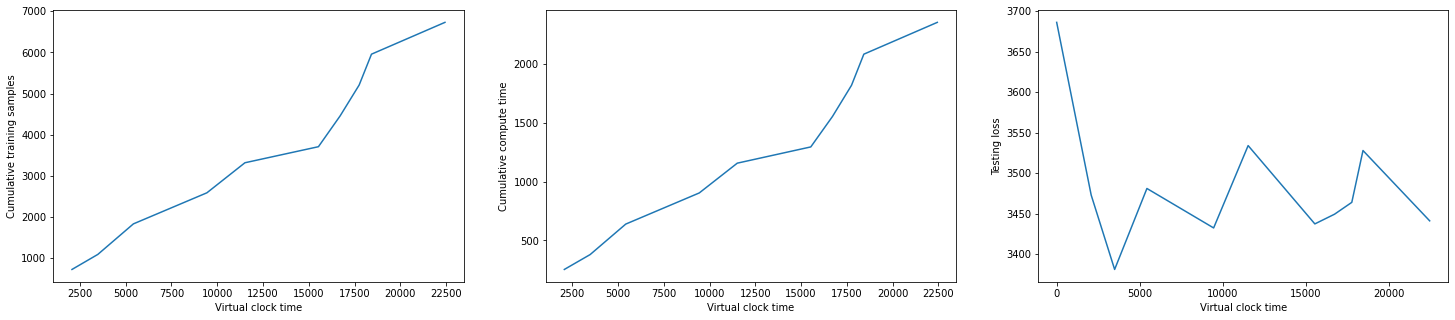

In [ ]:
fig,axs =  plt.subplots(1,3,figsize=(25,5))
axs[0].set_ylabel("Cumulative training samples")
axs[0].plot(p2_round_virtual_clocks[1:],np.cumsum(q9_p2_training_samples_per_round))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(p2_round_virtual_clocks[1:],np.cumsum(q9_p2_compute_units))
axs[2].set_ylabel("Testing loss")
axs[2].plot(p2_round_virtual_clocks,q9_p2_losses)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()

##### 3} Compare loss values, total sample count, total compute and virtual clock time
- which ordering seems the most efficient at reaching a given loss value in terms of virtual clock time? 
- Explain the trade-offs you observe. 

ANSWER:
- As this question focusses on the clients with "most computational ability", the time per round is mostly dictated by communication speeds and so both experiments take roughly the same length of time to complete (i.e. end with similar virtual clock times)
- In this same time frame, the second experiment (where clients have larger datasets) sees a lot more training samples within the same time frame.
- Additionally, with the same amount of communication, a lot more time is spent on compute. As discussed above, these compute units are "free" if "the entity running the federation does not own nor pay for the resources of the underlying devices [e.g. if using people's smartphones]" so the model gets to train more during the same length of time.
- However, using only the datasets with the largest amounts of data does end up (in this experiment) with a higher final loss. So using the smaller datasets seems to reduce the loss a lot more efficiently
- This is somewhat surprising (especially as the increased computation time from using larger datasets is largely irrelevant with everything being communication bound)
- This implies that the additional training examples aren't helping the federated model train. In this scenario this may be because all these additional examples are essentially "repeats": i.e the difference is that the model sees more examples **drawn by the same number of people**
- These extra examples could even cause the model to start overfitting the training data slightly (which makes it a bit worse at generalising to the overall population).
- Another explanation is that dataset size is not independant to the distribution of training examples (e.g. if the people who submitted the most examples were related to eachtoher then their handwriting might be similar) and so the second experiment is seeing a less representative cross section of the testing population.

#### ! **Question 10 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Moving away from simple dataset size as a measure of client utility, we will now consider the intrinsic properties of client data. In real FL client-selection systems such as [OORT](https://arxiv.org/abs/2010.06081), a notion of the statistical utility of a client is determined based on the loss of the client. However, that approach requires taking staleness into account as the loss of the model is a moving target changing as the model converges. 

To avoid the issue of staleness, we shall use a static metric of sample difficulty for this lab, which will not change as the model converges. As there are no easily computable generally accepted metrics for image difficulty, we shall use one of the standards in both [Curriculum Learning](https://arxiv.org/abs/2010.13166) and Hard Example Mining, namely the loss of a pre-trained model on the given sample.  We have two options in defining client difficulty; one would be the average of the `pre-trained-loss` across the client's data points, while the other would be the sum. OORT not only sums losses across all samples, it double-counts the dataset size of each client in its statistical utility estimation. However, we want to avoid dataset size being the primary predictor of client utility as we have already explored that particular association. As such, we will use the average of the ``pre-trained-loss`` computed on the test set of clients.

As discussed in the previous labs, centralised models often serve as the baselines for FL. In this notebook, we shall use a pre-trained centralised model in the cell below to act as our oracle. The loss values have been saved to a CSV to save you from the horrendous preprocessing time. 

Deciding if clients with lower or higher `pre-trained-loss` should be prioritised during training is complex. These two approaches are contrasted in the difference between Curriculum Learning (training the easiest examples first) and Hard Example Mining (training only the most challenging examples). Thus, it lacks a definitive answer as both often provide benefits over uniform weightings---potentially comaprable benefits on the same task. From a hardware perspective, newer cameras may have less noise (lower loss) however; other new sensors may have increased resolution (e.g., sensors gathering time-series data at a higher frequency) making their data harder. 

1. Using a mapping function like the one outlined above, map the clients with the most computational ability to those with the **highest** `pre-trained-loss`. Then, repeat the basic experimentation and plotting from the previous question 9 for `threshold=16`.

2. Repeat the previous experiment (1), changing the mapping to associate the clients with the most computational ability to the **lowest** `pre-trained-loss`. 

3. Looking at the loss values, total sample count, total compute and virtual clock time, how do the two orderings behave? Interpret their behaviours. 


##### Code provided (not used)

In [ ]:
# Train a centralised model, use it to evaluate all clients
def get_pre_train_loss_function() -> Callable[[int], float]:
  centralized_train_config: Dict[str, Any] = {
    "epochs": 20,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
  }
  centralized_flower_client_generator: Callable[
    [int], FlowerRayClient
  ] = get_flower_client_generator(network_generator_cnn, data_dir, centralized_partition) # type: ignore
  centralized_flower_client = centralized_flower_client_generator(0)
  trained_params, num_examples, train_metrics = fit_client_seeded(centralized_flower_client,
    seed_model_cnn_params, centralized_train_config, 
    max_batches = 100, shuffle = True
  ) 
  loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=get_default_test_config()
  )
  print(loss, test_metrics)
  flower_client_generator = get_flower_client_generator(network_generator_cnn, data_dir, federated_partition)

  def get_client_pre_train_loss(cid: int):
    client = flower_client_generator(cid)
    loss, *rest = client.evaluate(parameters = trained_params, config=get_default_test_config())
    return loss
  return get_client_pre_train_loss

get_client_pre_train_loss = get_pre_train_loss_function()


In [ ]:
# Example of loss calculation

get_client_pre_train_loss(0)

In [ ]:
# Cached list of clients with their centralised model loss
# Provided here for brevity, you can re-run all the evaluations of the centralised model
# If you want to convince yourself or change parameters

with open(statistical_utility, mode="r") as f:
    client_to_pre_train_loss = list(csv.reader(f))
print(client_to_pre_train_loss)

##### 1) Most computation ability mapped to Highest pre-trained loss

##### Processing provided History

In [ ]:
"""
History (loss, distributed): 
round 1: 3.888654589653015 
round 2: 8.20073688030243 
round 3: 3.6210230588912964 
round 4: 7.251557906468709 
round 5: 7.620046615600586 
round 6: 6.537368694941203 
round 7: 8.767045259475708 
round 8: 3.722535729408264 
round 9: 3.8842291831970215 
round 10: 6.252715905507405 

History (loss, centralized): 
round 0: 3686.001477241516 
round 1: 3404.1202363967896 
round 2: 3400.9520695209503 
round 3: 3124.0501935482025 
round 4: 3322.5770444869995 
round 5: 3533.4028663635254 
round 6: 3270.9152040481567 
round 7: 3330.9751460552216 
round 8: 3276.0829639434814 
round 9: 3359.6993668079376 
round 10: 3359.243089914322 

History (metrics, distributed, fit): 
{'train_loss': [(1, {'avg': 0.10944205820560456, 'all': [(6, 0.11275180305043857), (4, 0.10447744093835354)]}), (2, {'avg': 0.11156264361408022, 'all': [(9, 0.11004050489928988), (9, 0.11308478232887056)]}), (3, {'avg': 0.10597802450259526, 'all': [(4, 0.10243236273527145), (4, 0.10142427310347557), (7, 0.11060626059770584)]}), (4, {'avg': 0.11126372000823419, 'all': [(6, 0.10889118909835815), (10, 0.11316706389188766), (8, 0.11066393833607435)]}), (5, {'avg': 0.11308124112455469, 'all': [(10, 0.11483816280961037), (9, 0.11112910591893727)]}), (6, {'avg': 0.10892139688918465, 'all': [(5, 0.10553432703018188), (4, 0.10548409819602966), (10, 0.11198985129594803)]}), (7, {'avg': 0.10887330397963524, 'all': [(10, 0.11142097115516662), (4, 0.10250413604080677)]}), (8, {'avg': 0.11406343365493028, 'all': [(4, 0.10728986747562885), (9, 0.11407007690933016), (10, 0.11676688119769096)]}), (9, {'avg': 0.11148747305075328, 'all': [(9, 0.11317215032047695), (8, 0.11059045605361462), (7, 0.11034662170069558)]}), (10, {'avg': 0.10949908863557012, 'all': [(6, 0.11232500895857811), (9, 0.11040550387567943), (4, 0.10322077386081219)]})], 
'client_completion_time': [(1, {'avg': 241.19339440931677, 'all': [(6, 266.95591988861185), (4, 202.54960619037408)]}), (2, {'avg': 1183.7730302133352, 'all': [(9, 1184.5213100928497), (9, 1183.0247503338205)]}), (3, {'avg': 208.67345476156365, 'all': [(4, 181.33968243984728), (4, 119.35239285540493), (7, 275.3333600346351)]}), (4, {'avg': 963.0888711636857, 'all': [(6, 329.62124359027337), (10, 1261.5677517204613), (8, 1065.0909911477752)]}), (5, {'avg': 542.4142831436872, 'all': [(10, 553.3189433641635), (9, 530.2979940098244)]}), (6, {'avg': 703.7444570100612, 'all': [(5, 180.331556474767), (4, 986.4303286120052), (10, 852.3765586369307)]}), (7, {'avg': 541.9077961452821, 'all': [(10, 449.89949114862264), (4, 771.9285586369307)]}), (8, {'avg': 646.2601780143146, 'all': [(4, 221.28326501655192), (9, 352.69094353942734), (10, 1080.4632542408183)]}), (9, {'avg': 645.9532429164038, 'all': [(9, 1237.6777852052828), (8, 236.23906687906572), (7, 353.4093183019455)]}), (10, {'avg': 809.636186893131, 'all': [(6, 1409.215784455384), (9, 249.0550156263655), (4, 1171.5744258999741)]})], 
'computation': [(1, {'avg': 22.8, 'all': [(6, 22.0), (4, 24.0)]}), (2, {'avg': 21.0, 'all': [(9, 24.0), (9, 18.0)]}), (3, {'avg': 24.2, 'all': [(4, 23.0), (4, 24.0), (7, 25.0)]}), (4, {'avg': 29.583333333333332, 'all': [(6, 20.0), (10, 19.0), (8, 50.0)]}), (5, {'avg': 31.94736842105263, 'all': [(10, 22.0), (9, 43.0)]}), (6, {'avg': 26.526315789473685, 'all': [(5, 24.0), (4, 41.0), (10, 22.0)]}), (7, {'avg': 28.857142857142858, 'all': [(10, 28.0), (4, 31.0)]}), (8, {'avg': 23.08695652173913, 'all': [(4, 24.0), (9, 25.0), (10, 21.0)]}), (9, {'avg': 29.375, 'all': [(9, 19.0), (8, 23.0), (7, 50.0)]}), (10, {'avg': 25.473684210526315, 'all': [(6, 23.0), (9, 26.0), (4, 28.0)]})], 
'communication': [(1, {'avg': 14346.149902118254, 'all': [(6, 12078.759316621428), (4, 17747.235780363495)]}), (2, {'avg': 1939.2589200477923, 'all': [(9, 1976.82897458832), (9, 1901.6888655072644)]}), (3, {'avg': 25800.025420921684, 'all': [(4, 18437.311985652217), (4, 51663.04256805362), (7, 15228.423299857415)]}), (4, {'avg': 3838.7328285964627, 'all': [(6, 8703.930611352389), (10, 1810.440126491114), (8, 2725.2003691612053)]}), (5, {'avg': 7092.816270813982, 'all': [(10, 5320.409089720225), (9, 9062.157583140379)]}), (6, {'avg': 8204.248526451533, 'all': [(5, 23291.68410175639), (4, 2401.1727463733982), (10, 2981.761050830359)]}), (7, {'avg': 7383.096587922398, 'all': [(10, 9143.630802759213), (4, 2981.761050830359)]}), (8, {'avg': 8263.088093568798, 'all': [(4, 14457.211405313634), (9, 12263.096629375368), (10, 2185.4310866449496)]}), (9, {'avg': 17989.401674311153, 'all': [(9, 1819.7471560742927), (8, 25166.391726481786), (7, 30576.683138134966)]}), (10, {'avg': 15603.382865762482, 'all': [(6, 1547.75786695079), (9, 31079.54055631987), (4, 1865.465560225895)]})], 
'num_samples': [(1, {'avg': 5.2, 'all': [(6, 6), (4, 4)]}), (2, {'avg': 9.0, 'all': [(9, 9), (9, 9)]}), (3, {'avg': 5.4, 'all': [(4, 4), (4, 4), (7, 7)]}), (4, {'avg': 8.333333333333334, 'all': [(6, 6), (10, 10), (8, 8)]}), (5, {'avg': 9.526315789473685, 'all': [(10, 10), (9, 9)]}), (6, {'avg': 7.421052631578948, 'all': [(5, 5), (4, 4), (10, 10)]}), (7, {'avg': 8.285714285714286, 'all': [(10, 10), (4, 4)]}), (8, {'avg': 8.565217391304348, 'all': [(4, 4), (9, 9), (10, 10)]}), (9, {'avg': 8.083333333333334, 'all': [(9, 9), (8, 8), (7, 7)]}), (10, {'avg': 7.0, 'all': [(6, 6), (9, 9), (4, 4)]})]}

## IGNORE THESE ONES
# History (metrics, distributed, eval): 
# {'local_accuracy': [(1, {'avg': 0.0, 'all': [(1, 0.0), (1, 0.0)]}), (2, {'avg': 0.0861344537815126, 'all': [(2, 0.14285714285714285), (2, 0.029411764705882353)]}), (3, {'avg': 0.09375, 'all': [(1, 0.125), (1, 0.0625)]}), (4, {'avg': 0.06196581196581197, 'all': [(1, 0.08333333333333333), (2, 0.05128205128205128)]}), (5, {'avg': 0.10256410256410256, 'all': [(2, 0.10256410256410256)]}), (6, {'avg': 0.017543859649122806, 'all': [(1, 0.05263157894736842), (2, 0.0)]}), (7, {'avg': 0.02564102564102564, 'all': [(2, 0.02564102564102564)]}), (8, {'avg': 0.0, 'all': [(1, 0.0), (1, 0.0)]}), (9, {'avg': 0.03125, 'all': [(1, 0.0), (1, 0.0625)]}), (10, {'avg': 0.04738562091503268, 'all': [(1, 0.08333333333333333), (2, 0.029411764705882353)]})], 
# 'client_completion_time': [(1, {'avg': 985.5968729925631, 'all': [(1, 112.69360619037408), (1, 1858.5001397947522)]}), (2, {'avg': 1033.7250302133352, 'all': [(2, 1053.4247503338206), (2, 1014.0253100928497)]}), (3, {'avg': 73.59403764762611, 'all': [(1, 108.47568243984728), (1, 38.712392855404936)]}), (4, {'avg': 814.2789156770654, 'all': [(1, 229.78124359027333), (2, 1106.5277517204613)]}), (5, {'avg': 378.0229433641635, 'all': [(2, 378.0229433641635)]}), (6, {'avg': 477.1935579162095, 'all': [(1, 85.86755647476703), (2, 672.8565586369307)]}), (7, {'avg': 221.41949114862263, 'all': [(2, 221.41949114862263)]}), (8, {'avg': 273.21893108838884, 'all': [(1, 138.33926501655193), (1, 408.0985971602258)]}), (9, {'avg': 56.49088183423116, 'all': [(1, 31.3026967893966), (1, 81.67906687906572)]}), (10, {'avg': 475.295271902705, 'all': [(1, 1292.1917844553839), (2, 66.84701562636549)]})], 
# 'computation': [(1, {'avg': 32.0, 'all': [(1, 24.0), (1, 40.0)]}), (2, {'avg': 21.0, 'all': [(2, 18.0), (2, 24.0)]}), (3, {'avg': 23.5, 'all': [(1, 23.0), (1, 24.0)]}), (4, {'avg': 19.333333333333332, 'all': [(1, 20.0), (2, 19.0)]}), (5, {'avg': 22.0, 'all': [(2, 22.0)]}), (6, {'avg': 22.666666666666668, 'all': [(1, 24.0), (2, 22.0)]}), (7, {'avg': 28.0, 'all': [(2, 28.0)]}), (8, {'avg': 35.0, 'all': [(1, 24.0), (1, 46.0)]}), (9, {'avg': 42.0, 'all': [(1, 61.0), (1, 23.0)]}), (10, {'avg': 25.0, 'all': [(1, 23.0), (2, 26.0)]})], 
# 'communication': [(1, {'avg': 9411.686184387223, 'all': [(1, 17747.235780363495), (1, 1076.136588410951)]}), (2, {'avg': 1939.2589200477923, 'all': [(2, 1901.6888655072644), (2, 1976.82897458832)]}), (3, {'avg': 35050.17727685292, 'all': [(1, 18437.311985652217), (1, 51663.04256805362)]}), (4, {'avg': 4108.270288111539, 'all': [(1, 8703.930611352389), (2, 1810.440126491114)]}), (5, {'avg': 5320.409089720225, 'all': [(2, 5320.409089720225)]}), (6, {'avg': 9751.735401139036, 'all': [(1, 23291.68410175639), (2, 2981.761050830359)]}), (7, {'avg': 9143.630802759213, 'all': [(2, 9143.630802759213)]}), (8, {'avg': 9678.993934712867, 'all': [(1, 14457.211405313634), (1, 4900.776464112101)]}), (9, {'avg': 44529.32519286267, 'all': [(1, 63892.25865924355), (1, 25166.391726481786)]}), (10, {'avg': 21235.612993196843, 'all': [(1, 1547.75786695079), (2, 31079.54055631987)]})], 
# 'num_samples': [(1, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (2, {'avg': 2.0, 'all': [(2, 2), (2, 2)]}), (3, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (4, {'avg': 1.6666666666666667, 'all': [(1, 1), (2, 2)]}), (5, {'avg': 2.0, 'all': [(2, 2)]}), (6, {'avg': 1.6666666666666667, 'all': [(1, 1), (2, 2)]}), (7, {'avg': 2.0, 'all': [(2, 2)]}), (8, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (9, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (10, {'avg': 1.6666666666666667, 'all': [(1, 1), (2, 2)]})]}

History (metrics, centralized): 
{'accuracy': [(0, 0.005892669238863556), (1, 0.07134338828481235), (2, 0.009435285864608909), (3, 0.07969133637320239), (4, 0.005647141353910909), (5, 0.005506839705366538), (6, 0.07969133637320239), (7, 0.005506839705366538), (8, 0.005647141353910909), (9, 0.005647141353910909), (10, 0.005647141353910909)]}
"""

In [ ]:
q10_p1_hist_num_samples = [(1, {'avg': 5.2, 'all': [(6, 6), (4, 4)]}), (2, {'avg': 9.0, 'all': [(9, 9), (9, 9)]}), (3, {'avg': 5.4, 'all': [(4, 4), (4, 4), (7, 7)]}), (4, {'avg': 8.333333333333334, 'all': [(6, 6), (10, 10), (8, 8)]}), (5, {'avg': 9.526315789473685, 'all': [(10, 10), (9, 9)]}), (6, {'avg': 7.421052631578948, 'all': [(5, 5), (4, 4), (10, 10)]}), (7, {'avg': 8.285714285714286, 'all': [(10, 10), (4, 4)]}), (8, {'avg': 8.565217391304348, 'all': [(4, 4), (9, 9), (10, 10)]}), (9, {'avg': 8.083333333333334, 'all': [(9, 9), (8, 8), (7, 7)]}), (10, {'avg': 7.0, 'all': [(6, 6), (9, 9), (4, 4)]})]
q10_p1_hist_computation = [(1, {'avg': 22.8, 'all': [(6, 22.0), (4, 24.0)]}), (2, {'avg': 21.0, 'all': [(9, 24.0), (9, 18.0)]}), (3, {'avg': 24.2, 'all': [(4, 23.0), (4, 24.0), (7, 25.0)]}), (4, {'avg': 29.583333333333332, 'all': [(6, 20.0), (10, 19.0), (8, 50.0)]}), (5, {'avg': 31.94736842105263, 'all': [(10, 22.0), (9, 43.0)]}), (6, {'avg': 26.526315789473685, 'all': [(5, 24.0), (4, 41.0), (10, 22.0)]}), (7, {'avg': 28.857142857142858, 'all': [(10, 28.0), (4, 31.0)]}), (8, {'avg': 23.08695652173913, 'all': [(4, 24.0), (9, 25.0), (10, 21.0)]}), (9, {'avg': 29.375, 'all': [(9, 19.0), (8, 23.0), (7, 50.0)]}), (10, {'avg': 25.473684210526315, 'all': [(6, 23.0), (9, 26.0), (4, 28.0)]})]
q10_p1_hist_client_completion_time_fit = [(1, {'avg': 241.19339440931677, 'all': [(6, 266.95591988861185), (4, 202.54960619037408)]}), (2, {'avg': 1183.7730302133352, 'all': [(9, 1184.5213100928497), (9, 1183.0247503338205)]}), (3, {'avg': 208.67345476156365, 'all': [(4, 181.33968243984728), (4, 119.35239285540493), (7, 275.3333600346351)]}), (4, {'avg': 963.0888711636857, 'all': [(6, 329.62124359027337), (10, 1261.5677517204613), (8, 1065.0909911477752)]}), (5, {'avg': 542.4142831436872, 'all': [(10, 553.3189433641635), (9, 530.2979940098244)]}), (6, {'avg': 703.7444570100612, 'all': [(5, 180.331556474767), (4, 986.4303286120052), (10, 852.3765586369307)]}), (7, {'avg': 541.9077961452821, 'all': [(10, 449.89949114862264), (4, 771.9285586369307)]}), (8, {'avg': 646.2601780143146, 'all': [(4, 221.28326501655192), (9, 352.69094353942734), (10, 1080.4632542408183)]}), (9, {'avg': 645.9532429164038, 'all': [(9, 1237.6777852052828), (8, 236.23906687906572), (7, 353.4093183019455)]}), (10, {'avg': 809.636186893131, 'all': [(6, 1409.215784455384), (9, 249.0550156263655), (4, 1171.5744258999741)]})]
q10_p1_hist_client_completion_time_eval = [(1, {'avg': 985.5968729925631, 'all': [(1, 112.69360619037408), (1, 1858.5001397947522)]}), (2, {'avg': 1033.7250302133352, 'all': [(2, 1053.4247503338206), (2, 1014.0253100928497)]}), (3, {'avg': 73.59403764762611, 'all': [(1, 108.47568243984728), (1, 38.712392855404936)]}), (4, {'avg': 814.2789156770654, 'all': [(1, 229.78124359027333), (2, 1106.5277517204613)]}), (5, {'avg': 378.0229433641635, 'all': [(2, 378.0229433641635)]}), (6, {'avg': 477.1935579162095, 'all': [(1, 85.86755647476703), (2, 672.8565586369307)]}), (7, {'avg': 221.41949114862263, 'all': [(2, 221.41949114862263)]}), (8, {'avg': 273.21893108838884, 'all': [(1, 138.33926501655193), (1, 408.0985971602258)]}), (9, {'avg': 56.49088183423116, 'all': [(1, 31.3026967893966), (1, 81.67906687906572)]}), (10, {'avg': 475.295271902705, 'all': [(1, 1292.1917844553839), (2, 66.84701562636549)]})]


In [ ]:
import numpy as np

## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
q10_p1_batches = [[c[1] for c in r[1]["all"]] for r in q10_p1_hist_num_samples]
q10_p1_training_samples = [sum(r) for r in q10_p1_batches]


q10_p1_computation_values = [[c[1] for c in r[1]["all"]] for r in q10_p1_hist_computation]

q10_p1_compute_units = np.array([
  sum([
    # 8 rounds per epoch, augmentation factor of 3, assume default batch size of 32
    (8.0 * 3.0 * 32 * c_batch * c_comp/1000) 
    for c_comp,c_batch in zip(r_comps,r_batches)
  ]) 
  for r_comps,r_batches in zip(q10_p1_computation_values,q10_p1_batches)
])


q10_p1_losses = [3686.001477241516, 3404.1202363967896, 3400.9520695209503, 3124.0501935482025, 3322.5770444869995, 3533.4028663635254, 3270.9152040481567, 3330.9751460552216, 3276.0829639434814, 3359.6993668079376, 3359.243089914322]

## As before, will consider round to have ended after BOTH fit and eval have finished for sake of plotting
q10_p1_fit_round_length = np.array([max([c[1] for c in r[1]["all"]]) for r in q10_p1_hist_client_completion_time_fit])
q10_p1_eval_round_length = np.array([max([c[1] for c in r[1]["all"]]) for r in q10_p1_hist_client_completion_time_eval])
q10_p1_virtual_clock_times = np.concatenate((np.array([0.0]),np.cumsum(q10_p1_fit_round_length + q10_p1_eval_round_length)))

In [ ]:
q10_p1_batches, q10_p1_training_samples, q10_p1_computation_values, q10_p1_compute_units, q10_p1_fit_round_length, q10_p1_eval_round_length, q10_p1_virtual_clock_times

##### Plotting results

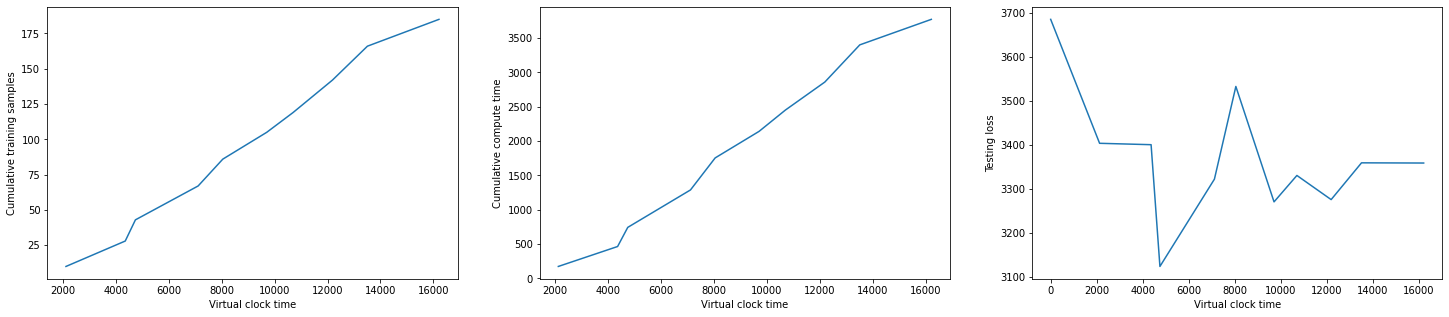

In [ ]:
import matplotlib.pyplot as plt 
fig,axs =  plt.subplots(1,3,figsize=(25,5))
axs[0].set_ylabel("Cumulative training samples")
axs[0].plot(q10_p1_virtual_clock_times[1:],np.cumsum(q10_p1_training_samples))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(q10_p1_virtual_clock_times[1:],np.cumsum(q10_p1_compute_units))
axs[2].set_ylabel("Testing loss")
axs[2].plot(q10_p1_virtual_clock_times,q10_p1_losses)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()

##### 2) Most computation ability mapped to Lowest pre-trained loss

##### Processing provided History

In [ ]:
"""
History (loss, distributed):
	round 1: 6.79397177696228
	round 2: 3.4294859170913696
	round 3: 3.658427596092224
	round 4: 3.1818536520004272
	round 5: 2.5512397289276123
	round 6: 2.8590667247772217
	round 7: 2.9242355823516846
	round 8: 2.618921637535095
	round 9: 2.7983769178390503
	round 10: 2.5491920709609985
History (loss, centralized):
	round 0: 3686.001477241516
	round 1: 3177.198085308075
	round 2: 3121.9546916484833
	round 3: 3286.2414844036102
	round 4: 3067.0951368808746
	round 5: 3152.127385377884
	round 6: 2732.312898159027
	round 7: 3234.7425812482834
	round 8: 2510.598071217537
	round 9: 2437.844105362892
	round 10: 2502.306437790394
History (metrics, distributed, fit):
'train_loss': [(1, {'avg': 0.10416626557707787, 'all': [(4, 0.10340193472802639), (4, 0.10493059642612934)]}), (2, {'avg': 0.09534119442105293, 'all': [(4, 0.09705942124128342), (4, 0.09362296760082245)]}), (3, {'avg': 0.10663583163510669, 'all': [(10, 0.11371938288211822), (8, 0.10967111308127642), (4, 0.08285639062523842)]}), (4, {'avg': 0.09462230537946408, 'all': [(4, 0.08938499540090561), (5, 0.09375378489494324), (4, 0.10094526596367359)]}), (5, {'avg': 0.08367680344316694, 'all': [(5, 0.07904402166604996), (4, 0.08946778066456318)]}), (6, {'avg': 0.06430957380395669, 'all': [(4, 0.05033217743039131), (4, 0.07192464172840118), (5, 0.0693994365632534)]}), (7, {'avg': 0.06968692827381585, 'all': [(8, 0.07311955746263266), (4, 0.043699310161173344), (7, 0.08061399097953524)]}), (8, {'avg': 0.05347819005449613, 'all': [(4, 0.04630762059241533), (4, 0.06033186428248882), (4, 0.05379508528858423)]}), (9, {'avg': 0.055505714324467326, 'all': [(4, 0.056694911792874336), (8, 0.062259944155812263), (5, 0.04374758861958981)]}), (10, {'avg': 0.0365122507459351, 'all': [(5, 0.04043226465582848), (5, 0.04327987693250179), (4, 0.023152700625360012)]})] 
'client_completion_time': [(1, {'avg': 223.13676303949296, 'all': [(4, 202.54960619037408), (4, 243.72391988861185)]}), (2, {'avg': 1109.1810302133351, 'all': [(4, 1119.0887503338206), (4, 1099.2733100928497)]}), (3, {'avg': 268.75293778576133, 'all': [(10, 332.93336003463514), (8, 258.6196824398473), (4, 128.56839285540494)]}), (4, {'avg': 810.5282259216782, 'all': [(4, 1172.1917517204613), (5, 925.8909911477753), (4, 304.66124359027333)]}), (5, {'avg': 421.7434103177905, 'all': [(5, 460.3909433641635), (4, 373.43399400982435)]}), (6, {'avg': 603.0662562591983, 'all': [(4, 751.0005586369307), (4, 986.4303286120052), (5, 178.02755647476704)]}), (7, {'avg': 815.2345155830981, 'all': [(8, 1211.755640436348), (4, 783.8325586369307), (7, 380.01149114862267)]}), (8, {'avg': 213.25012782348244, 'all': [(4, 221.28326501655192), (4, 256.69094353942734), (4, 161.77617491446804)]}), (9, {'avg': 982.5468327764273, 'all': [(4, 1168.3657852052827), (8, 1398.8597102478504), (5, 167.7910668790657)]}), (10, {'avg': 962.7047938773038, 'all': [(5, 1187.7024258999743), (5, 1380.5117844553838), (4, 159.1990156263655)]})]
'computation': [(1, {'avg': 23.0, 'all': [(4, 24.0), (4, 22.0)]}), (2, {'avg': 21.0, 'all': [(4, 18.0), (4, 24.0)]}), (3, {'avg': 24.09090909090909, 'all': [(10, 25.0), (8, 23.0), (4, 24.0)]}), (4, {'avg': 31.23076923076923, 'all': [(4, 19.0), (5, 50.0), (4, 20.0)]}), (5, {'avg': 31.333333333333332, 'all': [(5, 22.0), (4, 43.0)]}), (6, {'avg': 28.615384615384617, 'all': [(4, 22.0), (4, 41.0), (5, 24.0)]}), (7, {'avg': 34.10526315789474, 'all': [(8, 41.0), (4, 31.0), (7, 28.0)]}), (8, {'avg': 29.0, 'all': [(4, 24.0), (4, 25.0), (4, 38.0)]}), (9, {'avg': 25.823529411764707, 'all': [(4, 19.0), (8, 31.0), (5, 23.0)]}), (10, {'avg': 25.642857142857142, 'all': [(5, 28.0), (5, 23.0), (4, 26.0)]})]
'communication': [(1, {'avg': 14912.997548492462, 'all': [(4, 17747.235780363495), (4, 12078.759316621428)]}), (2, {'avg': 1939.2589200477923, 'all': [(4, 1901.6888655072644), (4, 1976.82897458832)]}), (3, {'avg': 23019.768143454836, 'all': [(10, 15228.423299857415), (8, 18437.311985652217), (4, 51663.04256805362)]}), (4, {'avg': 4283.3449843984645, 'all': [(4, 1810.440126491114), (5, 2725.2003691612053), (4, 8703.930611352389)]}), (5, {'avg': 6983.408420129183, 'all': [(5, 5320.409089720225), (4, 9062.157583140379)]}), (6, {'avg': 10614.627361353612, 'all': [(4, 2981.761050830359), (4, 2401.1727463733982), (5, 23291.68410175639)]}), (7, {'avg': 4877.386235993188, 'all': [(8, 2092.234832654331), (4, 2981.761050830359), (7, 9143.630802759213)]}), (8, {'avg': 37701.76027467111, 'all': [(4, 14457.211405313634), (4, 12263.096629375368), (4, 86384.97278932433)]}), (9, {'avg': 8608.92017954256, 'all': [(4, 1819.7471560742927), (8, 1655.0869744396773), (5, 25166.391726481786)]}), (10, {'avg': 10098.877097225923, 'all': [(5, 1865.465560225895), (5, 1547.75786695079), (4, 31079.54055631987)]})]
'num_samples': [(1, {'avg': 4.0, 'all': [(4, 4), (4, 4)]}), (2, {'avg': 4.0, 'all': [(4, 4), (4, 4)]}), (3, {'avg': 8.181818181818182, 'all': [(10, 10), (8, 8), (4, 4)]}), (4, {'avg': 4.384615384615385, 'all': [(4, 4), (5, 5), (4, 4)]}), (5, {'avg': 4.555555555555555, 'all': [(5, 5), (4, 4)]}), (6, {'avg': 4.384615384615385, 'all': [(4, 4), (4, 4), (5, 5)]}), (7, {'avg': 6.7894736842105265, 'all': [(8, 8), (4, 4), (7, 7)]}), (8, {'avg': 4.0, 'all': [(4, 4), (4, 4), (4, 4)]}), (9, {'avg': 6.176470588235294, 'all': [(4, 4), (8, 8), (5, 5)]}), (10, {'avg': 4.714285714285714, 'all': [(5, 5), (5, 5), (4, 4)]})]

History (metrics, distributed, eval):
'local_accuracy': [(1, {'avg': 0.03809523809523809, 'all': [(2, 0.05714285714285714), (1, 0.0)]}), (2, {'avg': 0.027777777777777776, 'all': [(1, 0.0), (1, 0.05555555555555555)]}), (3, {'avg': 0.04838709677419355, 'all': [(1, 0.0967741935483871), (1, 0.0)]}), (4, {'avg': 0.08660130718954248, 'all': [(1, 0.05555555555555555), (1, 0.11764705882352941)]}), (5, {'avg': 0.21052631578947367, 'all': [(1, 0.21052631578947367)]}), (6, {'avg': 0.19005847953216373, 'all': [(1, 0.15789473684210525), (1, 0.2222222222222222)]}), (7, {'avg': 0.25925925925925924, 'all': [(1, 0.25925925925925924)]}), (8, {'avg': 0.4520123839009288, 'all': [(1, 0.5882352941176471), (1, 0.3157894736842105)]}), (9, {'avg': 0.37664473684210525, 'all': [(1, 0.3157894736842105), (1, 0.4375)]}), (10, {'avg': 0.43567251461988304, 'all': [(1, 0.3157894736842105), (1, 0.5555555555555556)]})]
'client_completion_time': [(1, {'avg': 1279.1246285932928, 'all': [(2, 1862.340139794752), (1, 112.69360619037408)]}), (2, {'avg': 1031.7090302133352, 'all': [(1, 1011.7213100928498), (1, 1051.6967503338205)]}), (3, {'avg': 73.59403764762611, 'all': [(1, 108.47568243984728), (1, 38.712392855404936)]}), (4, {'avg': 667.2424976553673, 'all': [(1, 229.78124359027333), (1, 1104.7037517204612)]}), (5, {'avg': 375.9109433641635, 'all': [(1, 375.9109433641635)]}), (6, {'avg': 378.3060575558489, 'all': [(1, 85.86755647476703), (1, 670.7445586369307)]}), (7, {'avg': 218.73149114862264, 'all': [(1, 218.73149114862264)]}), (8, {'avg': 150.71510427798964, 'all': [(1, 138.33926501655193), (1, 163.09094353942734)]}), (9, {'avg': 72.4401925905056, 'all': [(1, 79.47106687906572), (1, 65.4093183019455)]}), (10, {'avg': 678.2714000408747, 'all': [(1, 1292.1917844553839), (1, 64.3510156263655)]})]
'computation': [(1, {'avg': 23.0, 'all': [(4, 24.0), (4, 22.0)]}), (2, {'avg': 21.0, 'all': [(4, 18.0), (4, 24.0)]}), (3, {'avg': 24.09090909090909, 'all': [(10, 25.0), (8, 23.0), (4, 24.0)]}), (4, {'avg': 31.23076923076923, 'all': [(4, 19.0), (5, 50.0), (4, 20.0)]}), (5, {'avg': 31.333333333333332, 'all': [(5, 22.0), (4, 43.0)]}), (6, {'avg': 28.615384615384617, 'all': [(4, 22.0), (4, 41.0), (5, 24.0)]}), (7, {'avg': 34.10526315789474, 'all': [(8, 41.0), (4, 31.0), (7, 28.0)]}), (8, {'avg': 29.0, 'all': [(4, 24.0), (4, 25.0), (4, 38.0)]}), (9, {'avg': 25.823529411764707, 'all': [(4, 19.0), (8, 31.0), (5, 23.0)]}), (10, {'avg': 25.642857142857142, 'all': [(5, 28.0), (5, 23.0), (4, 26.0)]})]
'communication': [(1, {'avg': 6633.169652395132, 'all': [(2, 1076.136588410951), (1, 17747.235780363495)]}), (2, {'avg': 1939.2589200477923, 'all': [(1, 1976.82897458832), (1, 1901.6888655072644)]}), (3, {'avg': 35050.17727685292, 'all': [(1, 18437.311985652217), (1, 51663.04256805362)]}), (4, {'avg': 5257.185368921751, 'all': [(1, 8703.930611352389), (1, 1810.440126491114)]}), (5, {'avg': 5320.409089720225, 'all': [(1, 5320.409089720225)]}), (6, {'avg': 13136.722576293374, 'all': [(1, 23291.68410175639), (1, 2981.761050830359)]}), (7, {'avg': 9143.630802759213, 'all': [(1, 9143.630802759213)]}), (8, {'avg': 13360.154017344501, 'all': [(1, 14457.211405313634), (1, 12263.096629375368)]}), (9, {'avg': 27871.537432308374, 'all': [(1, 25166.391726481786), (1, 30576.683138134966)]}), (10, {'avg': 16313.64921163533, 'all': [(1, 1547.75786695079), (1, 31079.54055631987)]})]
'num_samples': [(1, {'avg': 1.6666666666666667, 'all': [(2, 2), (1, 1)]}), (2, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (3, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (4, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (5, {'avg': 1.0, 'all': [(1, 1)]}), (6, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (7, {'avg': 1.0, 'all': [(1, 1)]}), (8, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (9, {'avg': 1.0, 'all': [(1, 1), (1, 1)]}), (10, {'avg': 1.0, 'all': [(1, 1), (1, 1)]})]

History (metrics, centralized):
{'accuracy': [(0, 0.005892669238863556), (1, 0.07134338828481235), (2, 0.0753419852683269), (3, 0.005506839705366538), (4, 0.08446159242371098), (5, 0.18782883198877587), (6, 0.2517011574886005), (7, 0.21122413188354963), (8, 0.34398456681866013), (9, 0.3762539459838653), (10, 0.40736583654857944)]}

"""

In [ ]:
q10_p2_hist_num_samples = [(1, {'avg': 4.0, 'all': [(4, 4), (4, 4)]}), (2, {'avg': 4.0, 'all': [(4, 4), (4, 4)]}), (3, {'avg': 8.181818181818182, 'all': [(10, 10), (8, 8), (4, 4)]}), (4, {'avg': 4.384615384615385, 'all': [(4, 4), (5, 5), (4, 4)]}), (5, {'avg': 4.555555555555555, 'all': [(5, 5), (4, 4)]}), (6, {'avg': 4.384615384615385, 'all': [(4, 4), (4, 4), (5, 5)]}), (7, {'avg': 6.7894736842105265, 'all': [(8, 8), (4, 4), (7, 7)]}), (8, {'avg': 4.0, 'all': [(4, 4), (4, 4), (4, 4)]}), (9, {'avg': 6.176470588235294, 'all': [(4, 4), (8, 8), (5, 5)]}), (10, {'avg': 4.714285714285714, 'all': [(5, 5), (5, 5), (4, 4)]})]
q10_p2_hist_computation = [(1, {'avg': 22.8, 'all': [(6, 22.0), (4, 24.0)]}), (2, {'avg': 21.0, 'all': [(9, 24.0), (9, 18.0)]}), (3, {'avg': 24.2, 'all': [(4, 23.0), (4, 24.0), (7, 25.0)]}), (4, {'avg': 29.583333333333332, 'all': [(6, 20.0), (10, 19.0), (8, 50.0)]}), (5, {'avg': 31.94736842105263, 'all': [(10, 22.0), (9, 43.0)]}), (6, {'avg': 26.526315789473685, 'all': [(5, 24.0), (4, 41.0), (10, 22.0)]}), (7, {'avg': 28.857142857142858, 'all': [(10, 28.0), (4, 31.0)]}), (8, {'avg': 23.08695652173913, 'all': [(4, 24.0), (9, 25.0), (10, 21.0)]}), (9, {'avg': 29.375, 'all': [(9, 19.0), (8, 23.0), (7, 50.0)]}), (10, {'avg': 25.473684210526315, 'all': [(6, 23.0), (9, 26.0), (4, 28.0)]})]
q10_p2_hist_client_completion_time_fit = [(1, {'avg': 223.13676303949296, 'all': [(4, 202.54960619037408), (4, 243.72391988861185)]}), (2, {'avg': 1109.1810302133351, 'all': [(4, 1119.0887503338206), (4, 1099.2733100928497)]}), (3, {'avg': 268.75293778576133, 'all': [(10, 332.93336003463514), (8, 258.6196824398473), (4, 128.56839285540494)]}), (4, {'avg': 810.5282259216782, 'all': [(4, 1172.1917517204613), (5, 925.8909911477753), (4, 304.66124359027333)]}), (5, {'avg': 421.7434103177905, 'all': [(5, 460.3909433641635), (4, 373.43399400982435)]}), (6, {'avg': 603.0662562591983, 'all': [(4, 751.0005586369307), (4, 986.4303286120052), (5, 178.02755647476704)]}), (7, {'avg': 815.2345155830981, 'all': [(8, 1211.755640436348), (4, 783.8325586369307), (7, 380.01149114862267)]}), (8, {'avg': 213.25012782348244, 'all': [(4, 221.28326501655192), (4, 256.69094353942734), (4, 161.77617491446804)]}), (9, {'avg': 982.5468327764273, 'all': [(4, 1168.3657852052827), (8, 1398.8597102478504), (5, 167.7910668790657)]}), (10, {'avg': 962.7047938773038, 'all': [(5, 1187.7024258999743), (5, 1380.5117844553838), (4, 159.1990156263655)]})]
q10_p2_hist_client_completion_time_eval = [(1, {'avg': 1279.1246285932928, 'all': [(2, 1862.340139794752), (1, 112.69360619037408)]}), (2, {'avg': 1031.7090302133352, 'all': [(1, 1011.7213100928498), (1, 1051.6967503338205)]}), (3, {'avg': 73.59403764762611, 'all': [(1, 108.47568243984728), (1, 38.712392855404936)]}), (4, {'avg': 667.2424976553673, 'all': [(1, 229.78124359027333), (1, 1104.7037517204612)]}), (5, {'avg': 375.9109433641635, 'all': [(1, 375.9109433641635)]}), (6, {'avg': 378.3060575558489, 'all': [(1, 85.86755647476703), (1, 670.7445586369307)]}), (7, {'avg': 218.73149114862264, 'all': [(1, 218.73149114862264)]}), (8, {'avg': 150.71510427798964, 'all': [(1, 138.33926501655193), (1, 163.09094353942734)]}), (9, {'avg': 72.4401925905056, 'all': [(1, 79.47106687906572), (1, 65.4093183019455)]}), (10, {'avg': 678.2714000408747, 'all': [(1, 1292.1917844553839), (1, 64.3510156263655)]})]


In [ ]:
# prevent annoying client generation logging from being displayed:
import numpy as np

## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
q10_p2_batches = [[c[1] for c in r[1]["all"]] for r in q10_p2_hist_num_samples]
q10_p2_training_samples = [sum(r) for r in q10_p2_batches]


q10_p2_computation_values = [[c[1] for c in r[1]["all"]] for r in q10_p2_hist_computation]

q10_p2_compute_units = np.array([
  sum([
    # 8 rounds per epoch, augmentation factor of 3, assume default batch size of 32
    (8.0 * 3.0 * 32 * c_batch * c_comp/1000) 
    for c_comp,c_batch in zip(r_comps,r_batches)
  ]) 
  for r_comps,r_batches in zip(q10_p2_computation_values,q10_p2_batches)
])

q10_p2_losses = [3686.001477241516, 3177.198085308075, 3121.9546916484833, 3286.2414844036102, 3067.0951368808746, 3152.127385377884, 2732.312898159027, 3234.7425812482834, 2510.598071217537, 2437.844105362892, 2502.306437790394]

## As before, will consider round to have ended after BOTH fit and eval have finished for sake of plotting
q10_p2_fit_round_length = np.array([max([c[1] for c in r[1]["all"]]) for r in q10_p2_hist_client_completion_time_fit])
q10_p2_eval_round_length = np.array([max([c[1] for c in r[1]["all"]]) for r in q10_p2_hist_client_completion_time_eval])
q10_p2_virtual_clock_times = np.concatenate((np.array([0.0]),np.cumsum(q10_p2_fit_round_length + q10_p2_eval_round_length)))



In [ ]:
q10_p2_training_samples, q10_p2_compute_units, q10_p2_fit_round_length, q10_p2_eval_round_length, q10_p2_virtual_clock_times

([8, 8, 22, 13, 9, 13, 19, 12, 17, 14],
 array([141.312, 129.024, 400.896, 288.   , 216.576, 284.16 , 267.264,
        215.04 , 391.68 , 274.176]),
 array([ 243.72391989, 1119.08875033,  332.93336003, 1172.19175172,
         460.39094336,  986.43032861, 1211.75564044,  256.69094354,
        1398.85971025, 1380.51178446]),
 array([1862.34013979, 1051.69675033,  108.47568244, 1104.70375172,
         375.91094336,  670.74455864,  218.73149115,  163.09094354,
          79.47106688, 1292.19178446]),
 array([    0.        ,  2106.06405968,  4276.84956035,  4718.25860283,
         6995.15410627,  7831.45599299,  9488.63088024, 10919.11801183,
        11338.89989891, 12817.23067603, 15489.93424495]))

##### Plotting results

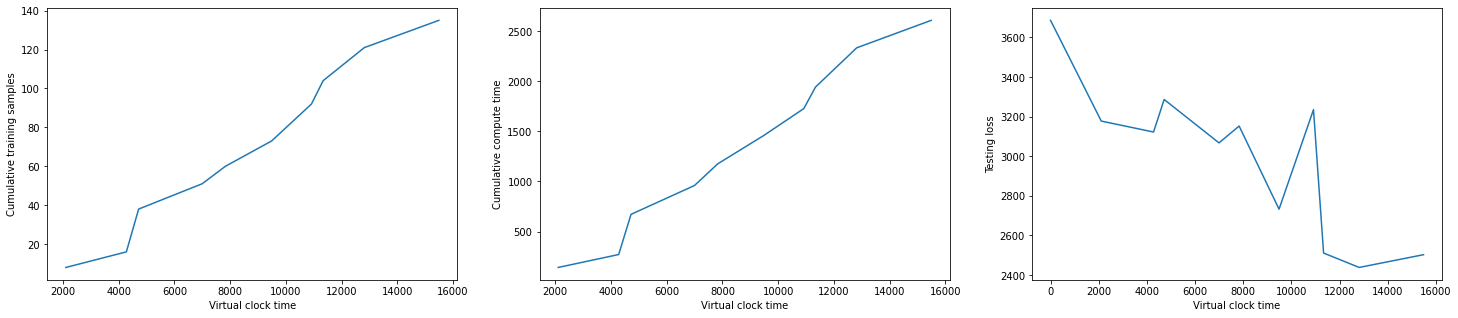

In [ ]:
import matplotlib.pyplot as plt 
fig,axs =  plt.subplots(1,3,figsize=(25,5))
axs[0].set_ylabel("Cumulative training samples")
axs[0].plot(q10_p2_virtual_clock_times[1:],np.cumsum(q10_p2_training_samples))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(q10_p2_virtual_clock_times[1:],np.cumsum(q10_p2_compute_units))
axs[2].set_ylabel("Testing loss")
axs[2].plot(q10_p2_virtual_clock_times,q10_p2_losses)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()

##### 3) Compare loss values, total sample count, total compute and virtual clock time

- In both experiments, everything is communication bound again, so the differences in dataset sizes on the clients makes little difference to the overall running time (aso the two experiments end at a similar virtual clock time)
- The 2nd experiment which trained on the "easiest" low pretrained loss examples overall trained on fewer sample (and therefore consumed fewer compute units)
- However, it led to a much lower final loss than the first experiment (which trained on the "hardest" high pretrained loss examples)
- In order to draw much of a conclusion from these reults, we need to assume that pretrained loss is meaningful. 
- However the pretrained model is essentially random and so the loss is difficult to interpret. 
- One possible explanation for the results is that there are multiple local training-loss minima to which the federated model could converge. In the first experiment we attempt to train the model on the examples it is initially worse at (drawing it to a minima far away in parameter space from its initial location) whereas in the second experiment the model is trained on the examples the model is already good at (and so needs to move the model less far in parameter space to find the nearest minima, which is perhaps an easier training task)
 - To test this theory this you would need to look at the model updates being performed which I don't have access to

